In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import os
import torch.optim as optim
import matplotlib.pyplot as plt

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)


In [2]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs = model(batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy

In [3]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp3/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp3/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp3/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [4]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Training on bin 1/50
Bin 1, Epoch 1/4000, Train Loss: 0.7144, Validation Loss: 0.6709,  Accuracy: 0.7825, LR: 0.000010
Bin 1, Epoch 101/4000, Train Loss: 0.6288, Validation Loss: 0.6174,  Accuracy: 0.8333, LR: 0.000010
Bin 1, Epoch 201/4000, Train Loss: 0.5708, Validation Loss: 0.5588,  Accuracy: 0.8333, LR: 0.000010
Bin 1, Epoch 301/4000, Train Loss: 0.5222, Validation Loss: 0.4808,  Accuracy: 0.8729, LR: 0.000010
Bin 1, Epoch 401/4000, Train Loss: 0.4765, Validation Loss: 0.4406,  Accuracy: 0.8785, LR: 0.000010
Bin 1, Epoch 501/4000, Train Loss: 0.4439, Validation Loss: 0.4215,  Accuracy: 0.8814, LR: 0.000010
Bin 1, Epoch 601/4000, Train Loss: 0.4205, Validation Loss: 0.3800,  Accuracy: 0.8898, LR: 0.000010
Bin 1, Epoch 701/4000, Train Loss: 0.3958, Validation Loss: 0.3039,  Accuracy: 0.8983, LR: 0.000010
Bin 1, Epoch 801/4000, Train Loss: 0.3581, Validation Loss: 0.3135,  Accuracy: 0.9040, LR: 0.000009
Bin 1, Epoch 901/4000, Train Loss: 0.3453, Validation Loss: 0.3279,  Accuracy: 0.

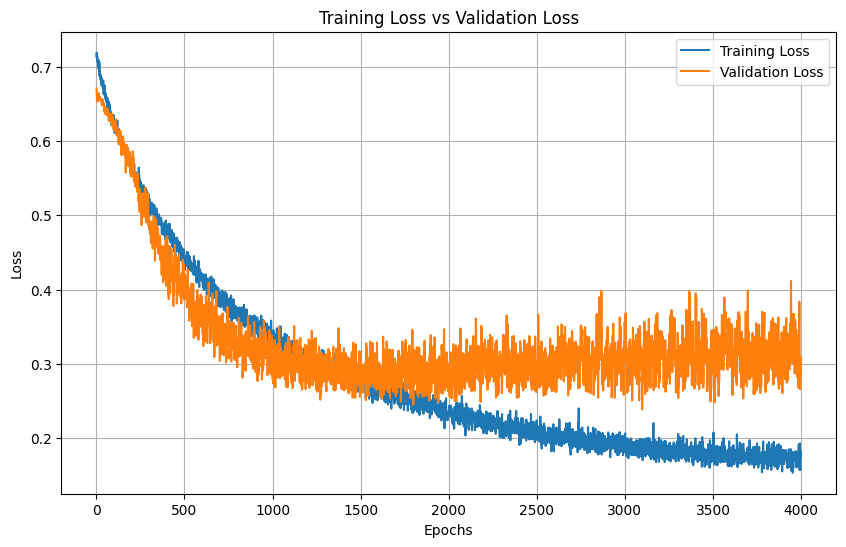

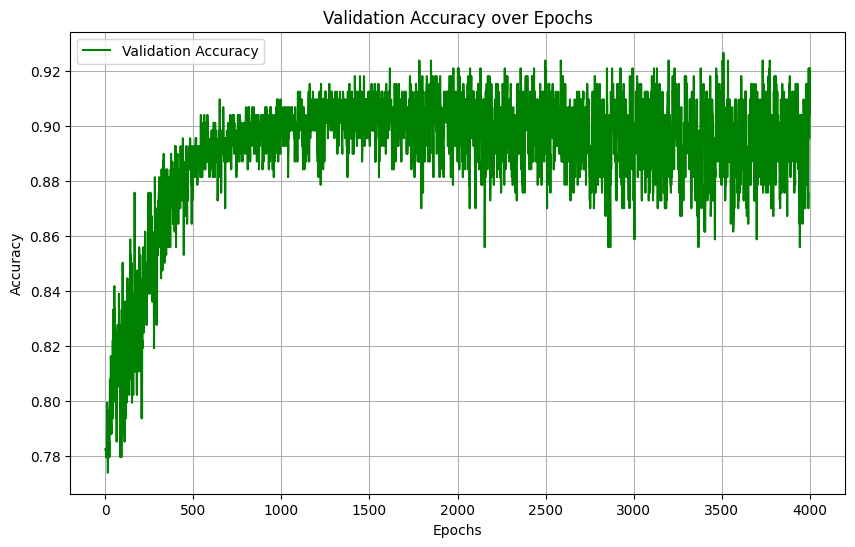

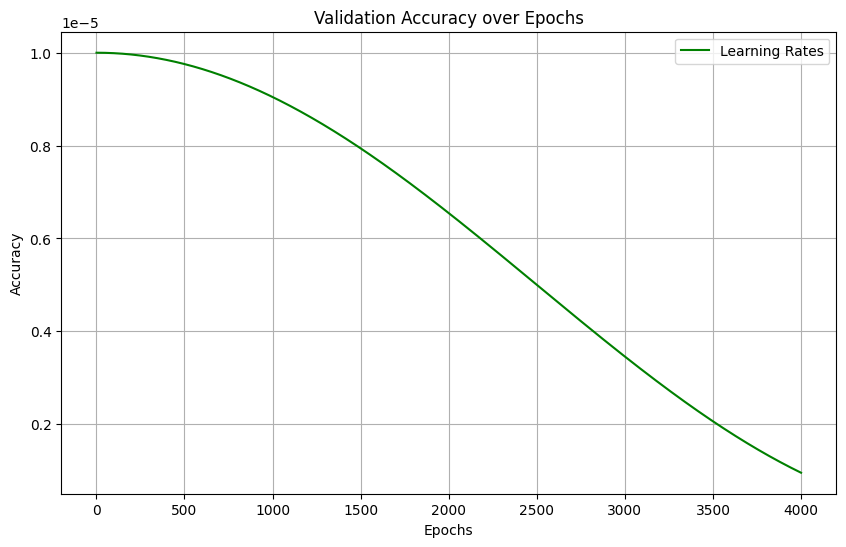

Model for bin 1 saved to GCNModels-5A_exp3/model_bin_1.pth
Training on bin 2/50
Bin 2, Epoch 1/4000, Train Loss: 0.6965, Validation Loss: 0.6989,  Accuracy: 0.2175, LR: 0.000010
Bin 2, Epoch 101/4000, Train Loss: 0.6392, Validation Loss: 0.6758,  Accuracy: 0.5960, LR: 0.000010
Bin 2, Epoch 201/4000, Train Loss: 0.5757, Validation Loss: 0.5888,  Accuracy: 0.7825, LR: 0.000010
Bin 2, Epoch 301/4000, Train Loss: 0.5169, Validation Loss: 0.5537,  Accuracy: 0.7627, LR: 0.000010
Bin 2, Epoch 401/4000, Train Loss: 0.4748, Validation Loss: 0.4815,  Accuracy: 0.8023, LR: 0.000010
Bin 2, Epoch 501/4000, Train Loss: 0.4388, Validation Loss: 0.4597,  Accuracy: 0.7938, LR: 0.000010
Bin 2, Epoch 601/4000, Train Loss: 0.4098, Validation Loss: 0.3608,  Accuracy: 0.8616, LR: 0.000010
Bin 2, Epoch 701/4000, Train Loss: 0.3857, Validation Loss: 0.3639,  Accuracy: 0.8531, LR: 0.000010
Bin 2, Epoch 801/4000, Train Loss: 0.3671, Validation Loss: 0.3301,  Accuracy: 0.8616, LR: 0.000009
Bin 2, Epoch 901/4000,

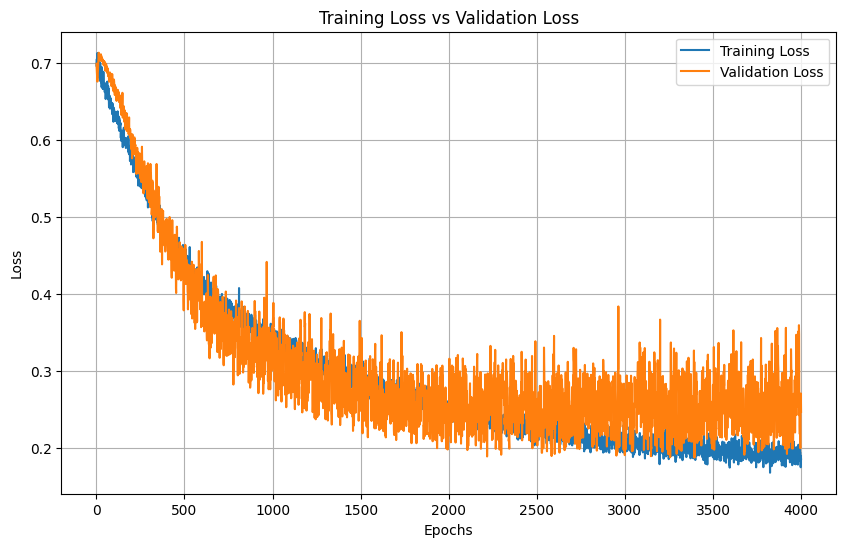

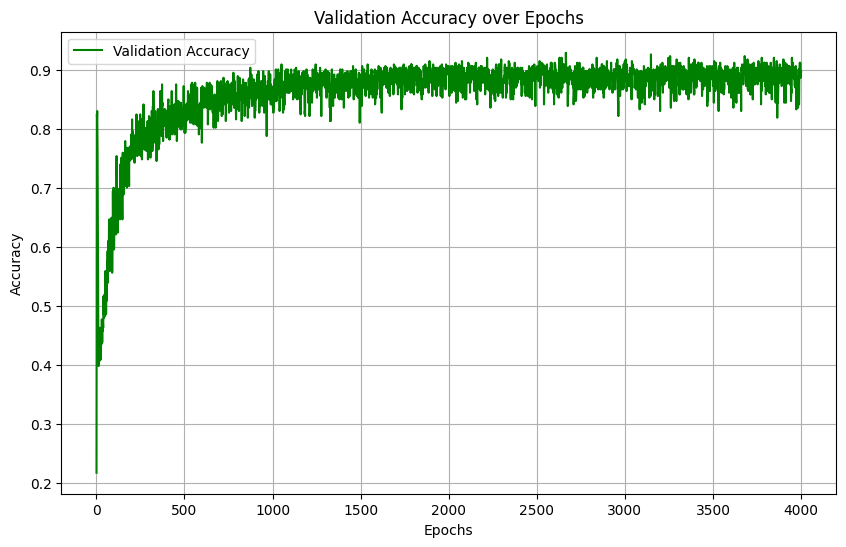

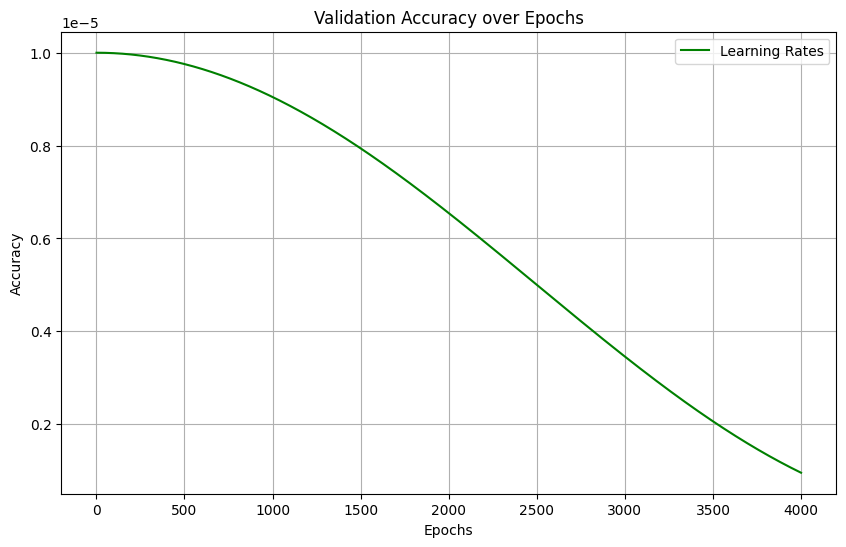

Model for bin 2 saved to GCNModels-5A_exp3/model_bin_2.pth
Training on bin 3/50
Bin 3, Epoch 1/4000, Train Loss: 0.7102, Validation Loss: 0.6971,  Accuracy: 0.2175, LR: 0.000010
Bin 3, Epoch 101/4000, Train Loss: 0.6162, Validation Loss: 0.6242,  Accuracy: 0.8136, LR: 0.000010
Bin 3, Epoch 201/4000, Train Loss: 0.5560, Validation Loss: 0.5502,  Accuracy: 0.8644, LR: 0.000010
Bin 3, Epoch 301/4000, Train Loss: 0.5063, Validation Loss: 0.4655,  Accuracy: 0.8983, LR: 0.000010
Bin 3, Epoch 401/4000, Train Loss: 0.4718, Validation Loss: 0.4371,  Accuracy: 0.8757, LR: 0.000010
Bin 3, Epoch 501/4000, Train Loss: 0.4375, Validation Loss: 0.3657,  Accuracy: 0.9011, LR: 0.000010
Bin 3, Epoch 601/4000, Train Loss: 0.4031, Validation Loss: 0.3419,  Accuracy: 0.9124, LR: 0.000010
Bin 3, Epoch 701/4000, Train Loss: 0.3853, Validation Loss: 0.3440,  Accuracy: 0.9068, LR: 0.000010
Bin 3, Epoch 801/4000, Train Loss: 0.3604, Validation Loss: 0.3136,  Accuracy: 0.9153, LR: 0.000009
Bin 3, Epoch 901/4000,

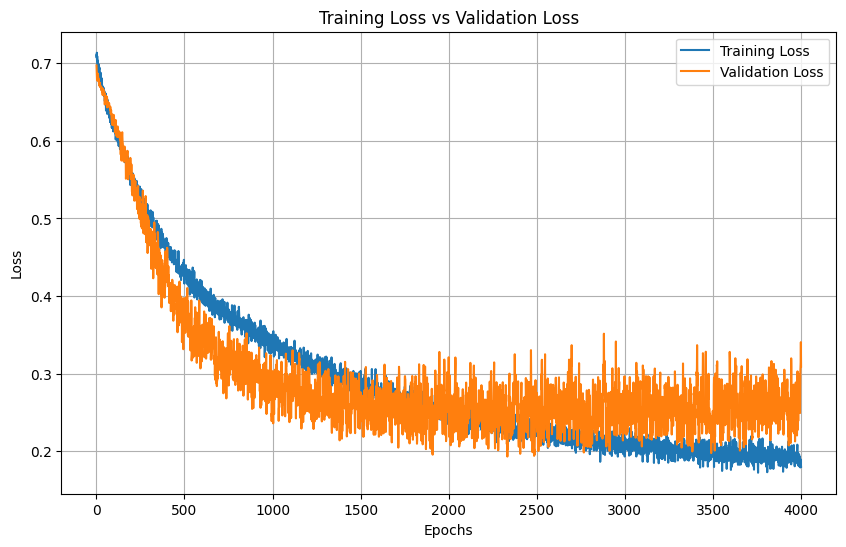

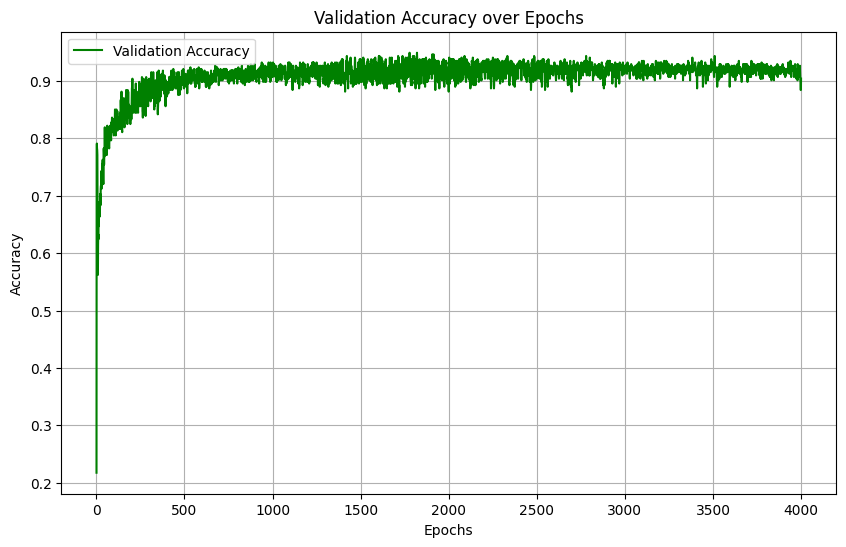

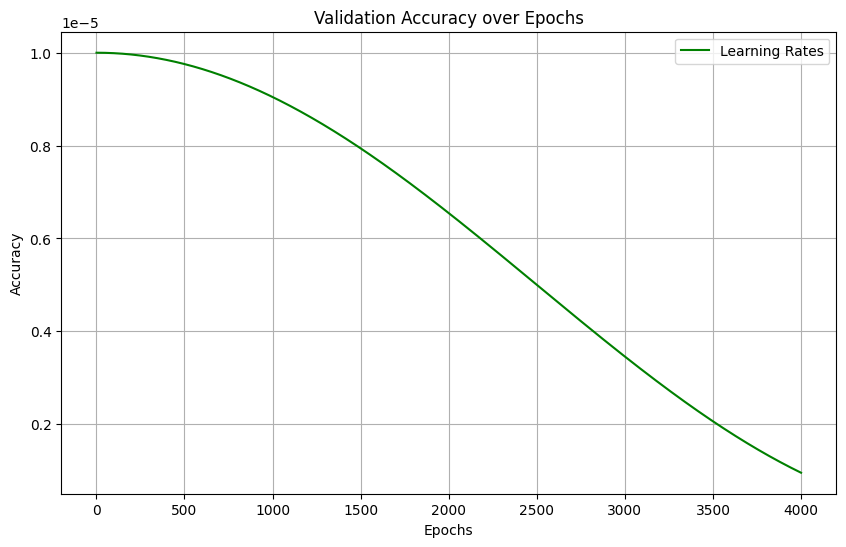

Model for bin 3 saved to GCNModels-5A_exp3/model_bin_3.pth
Training on bin 4/50
Bin 4, Epoch 1/4000, Train Loss: 0.7047, Validation Loss: 0.6939,  Accuracy: 0.2232, LR: 0.000010
Bin 4, Epoch 101/4000, Train Loss: 0.6364, Validation Loss: 0.6344,  Accuracy: 0.7853, LR: 0.000010
Bin 4, Epoch 201/4000, Train Loss: 0.6110, Validation Loss: 0.5787,  Accuracy: 0.8107, LR: 0.000010
Bin 4, Epoch 301/4000, Train Loss: 0.5397, Validation Loss: 0.4927,  Accuracy: 0.8588, LR: 0.000010
Bin 4, Epoch 401/4000, Train Loss: 0.4894, Validation Loss: 0.4230,  Accuracy: 0.8588, LR: 0.000010
Bin 4, Epoch 501/4000, Train Loss: 0.4421, Validation Loss: 0.4142,  Accuracy: 0.8333, LR: 0.000010
Bin 4, Epoch 601/4000, Train Loss: 0.4238, Validation Loss: 0.3641,  Accuracy: 0.8559, LR: 0.000010
Bin 4, Epoch 701/4000, Train Loss: 0.4047, Validation Loss: 0.3105,  Accuracy: 0.8785, LR: 0.000010
Bin 4, Epoch 801/4000, Train Loss: 0.3540, Validation Loss: 0.2623,  Accuracy: 0.8955, LR: 0.000009
Bin 4, Epoch 901/4000,

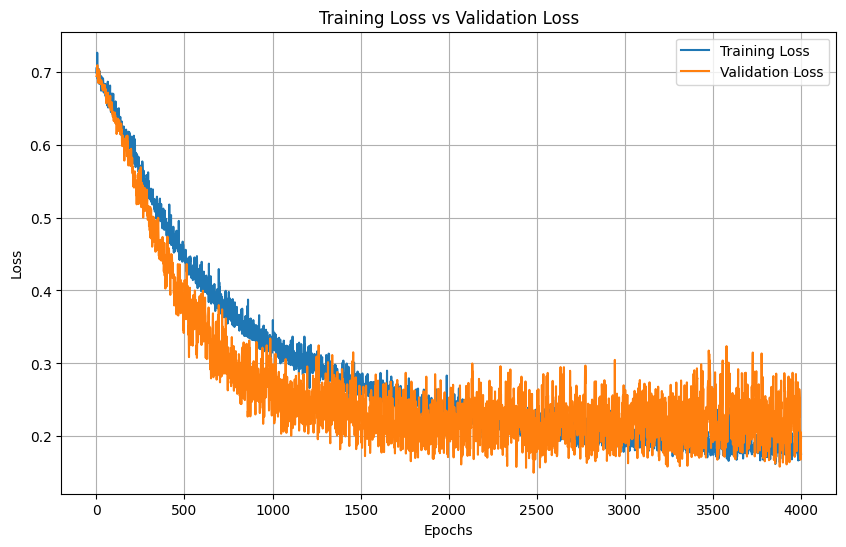

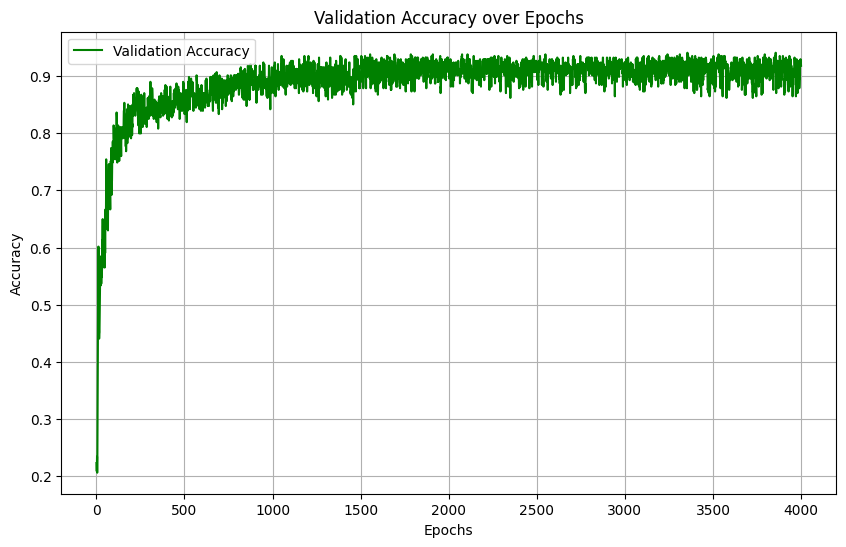

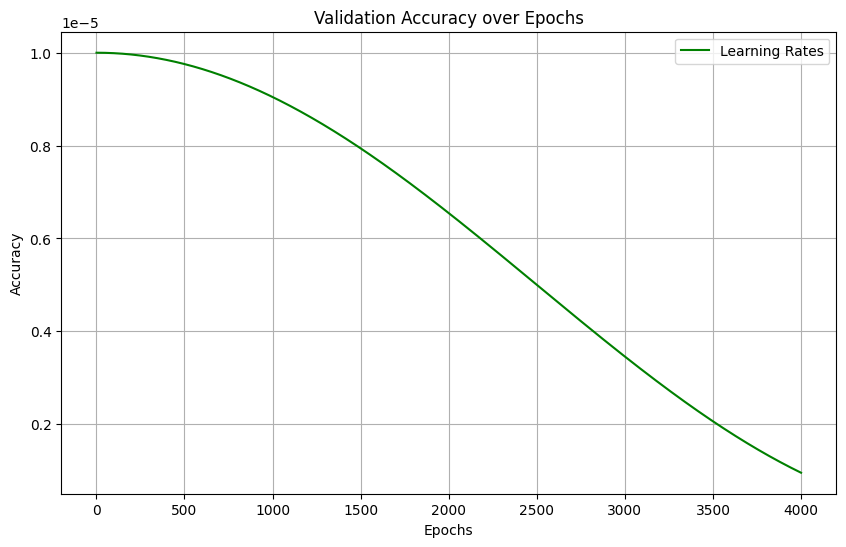

Model for bin 4 saved to GCNModels-5A_exp3/model_bin_4.pth
Training on bin 5/50
Bin 5, Epoch 1/4000, Train Loss: 0.7337, Validation Loss: 0.6757,  Accuracy: 0.7825, LR: 0.000010
Bin 5, Epoch 101/4000, Train Loss: 0.6749, Validation Loss: 0.6528,  Accuracy: 0.7712, LR: 0.000010
Bin 5, Epoch 201/4000, Train Loss: 0.6173, Validation Loss: 0.6003,  Accuracy: 0.8220, LR: 0.000010
Bin 5, Epoch 301/4000, Train Loss: 0.5593, Validation Loss: 0.5409,  Accuracy: 0.8277, LR: 0.000010
Bin 5, Epoch 401/4000, Train Loss: 0.5258, Validation Loss: 0.4645,  Accuracy: 0.8644, LR: 0.000010
Bin 5, Epoch 501/4000, Train Loss: 0.4868, Validation Loss: 0.4218,  Accuracy: 0.8531, LR: 0.000010
Bin 5, Epoch 601/4000, Train Loss: 0.4696, Validation Loss: 0.3534,  Accuracy: 0.8814, LR: 0.000010
Bin 5, Epoch 701/4000, Train Loss: 0.4218, Validation Loss: 0.3488,  Accuracy: 0.8701, LR: 0.000010
Bin 5, Epoch 801/4000, Train Loss: 0.4102, Validation Loss: 0.3093,  Accuracy: 0.8898, LR: 0.000009
Bin 5, Epoch 901/4000,

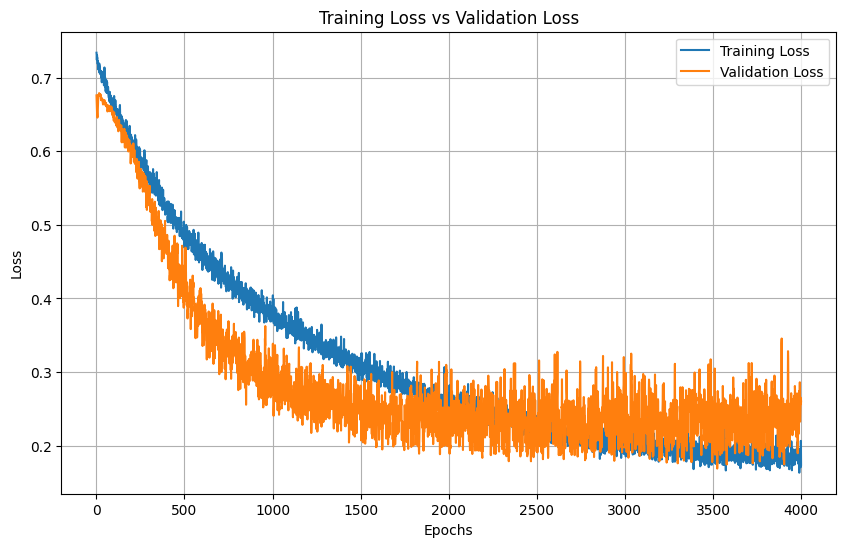

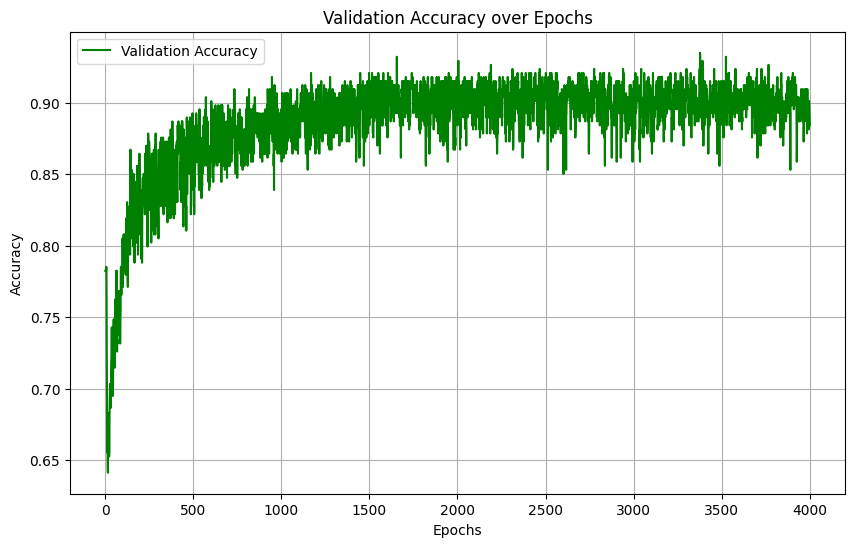

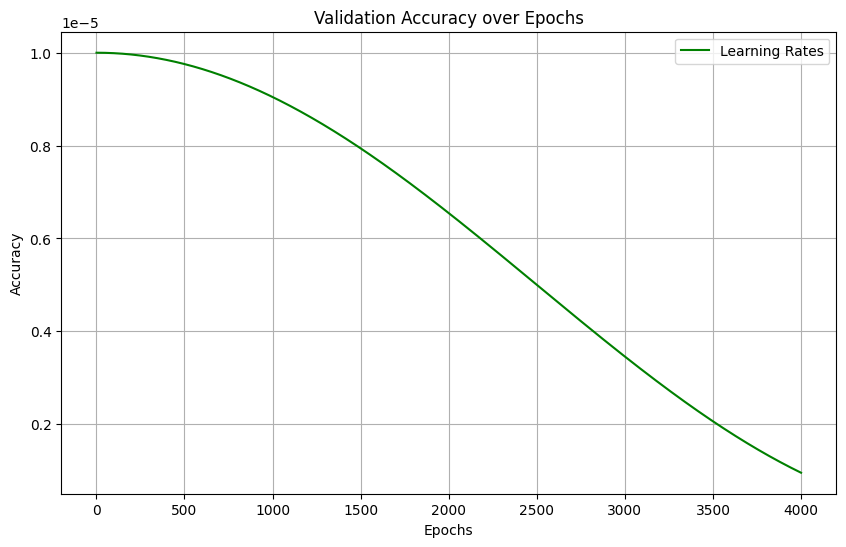

Model for bin 5 saved to GCNModels-5A_exp3/model_bin_5.pth
Training on bin 6/50
Bin 6, Epoch 1/4000, Train Loss: 0.6980, Validation Loss: 0.6904,  Accuracy: 0.7825, LR: 0.000010
Bin 6, Epoch 101/4000, Train Loss: 0.6147, Validation Loss: 0.6380,  Accuracy: 0.8051, LR: 0.000010
Bin 6, Epoch 201/4000, Train Loss: 0.5547, Validation Loss: 0.5852,  Accuracy: 0.8277, LR: 0.000010
Bin 6, Epoch 301/4000, Train Loss: 0.5079, Validation Loss: 0.5402,  Accuracy: 0.8333, LR: 0.000010
Bin 6, Epoch 401/4000, Train Loss: 0.4663, Validation Loss: 0.5180,  Accuracy: 0.8220, LR: 0.000010
Bin 6, Epoch 501/4000, Train Loss: 0.4491, Validation Loss: 0.4318,  Accuracy: 0.8531, LR: 0.000010
Bin 6, Epoch 601/4000, Train Loss: 0.4197, Validation Loss: 0.4684,  Accuracy: 0.8249, LR: 0.000010
Bin 6, Epoch 701/4000, Train Loss: 0.4028, Validation Loss: 0.3984,  Accuracy: 0.8588, LR: 0.000010
Bin 6, Epoch 801/4000, Train Loss: 0.4012, Validation Loss: 0.3974,  Accuracy: 0.8503, LR: 0.000009
Bin 6, Epoch 901/4000,

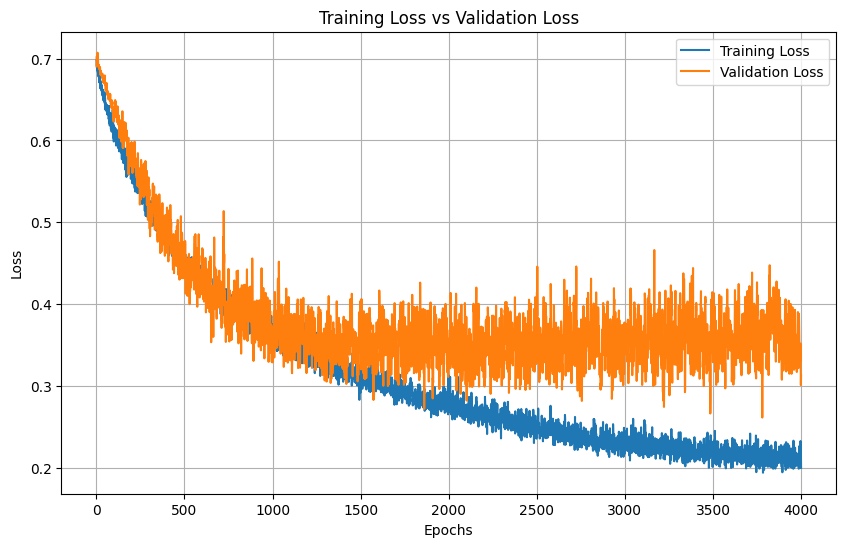

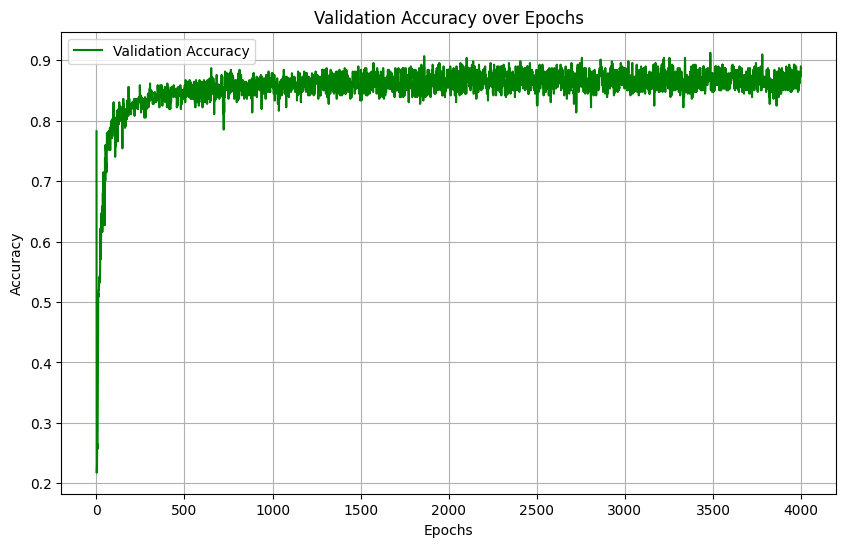

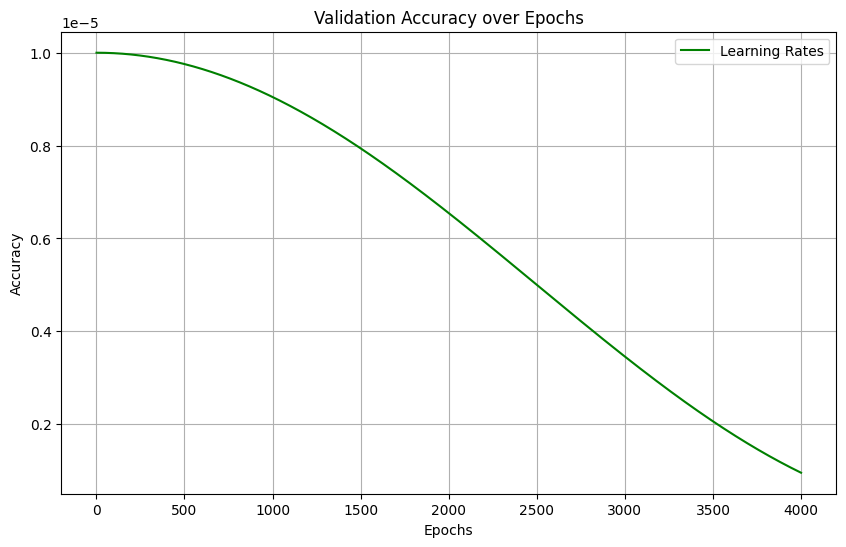

Model for bin 6 saved to GCNModels-5A_exp3/model_bin_6.pth
Training on bin 7/50
Bin 7, Epoch 1/4000, Train Loss: 0.6869, Validation Loss: 0.6782,  Accuracy: 0.7825, LR: 0.000010
Bin 7, Epoch 101/4000, Train Loss: 0.6278, Validation Loss: 0.6192,  Accuracy: 0.8079, LR: 0.000010
Bin 7, Epoch 201/4000, Train Loss: 0.5838, Validation Loss: 0.5535,  Accuracy: 0.8588, LR: 0.000010
Bin 7, Epoch 301/4000, Train Loss: 0.5315, Validation Loss: 0.4765,  Accuracy: 0.8785, LR: 0.000010
Bin 7, Epoch 401/4000, Train Loss: 0.4815, Validation Loss: 0.4315,  Accuracy: 0.8785, LR: 0.000010
Bin 7, Epoch 501/4000, Train Loss: 0.4542, Validation Loss: 0.3989,  Accuracy: 0.8870, LR: 0.000010
Bin 7, Epoch 601/4000, Train Loss: 0.4185, Validation Loss: 0.3013,  Accuracy: 0.9124, LR: 0.000010
Bin 7, Epoch 701/4000, Train Loss: 0.4084, Validation Loss: 0.2912,  Accuracy: 0.8983, LR: 0.000010
Bin 7, Epoch 801/4000, Train Loss: 0.3902, Validation Loss: 0.2471,  Accuracy: 0.9266, LR: 0.000009
Bin 7, Epoch 901/4000,

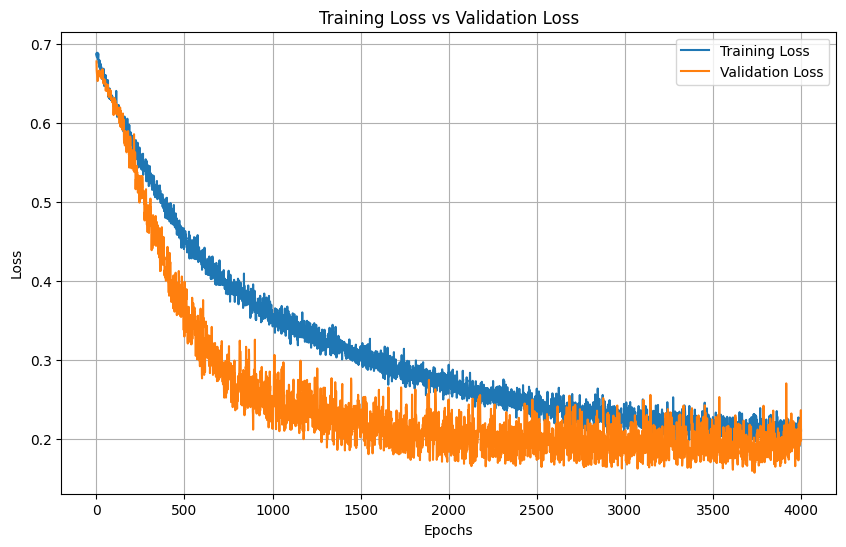

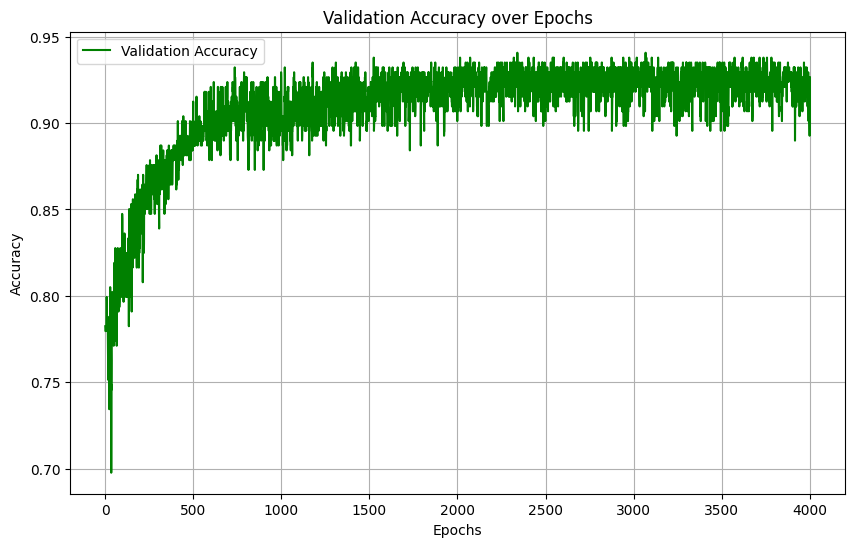

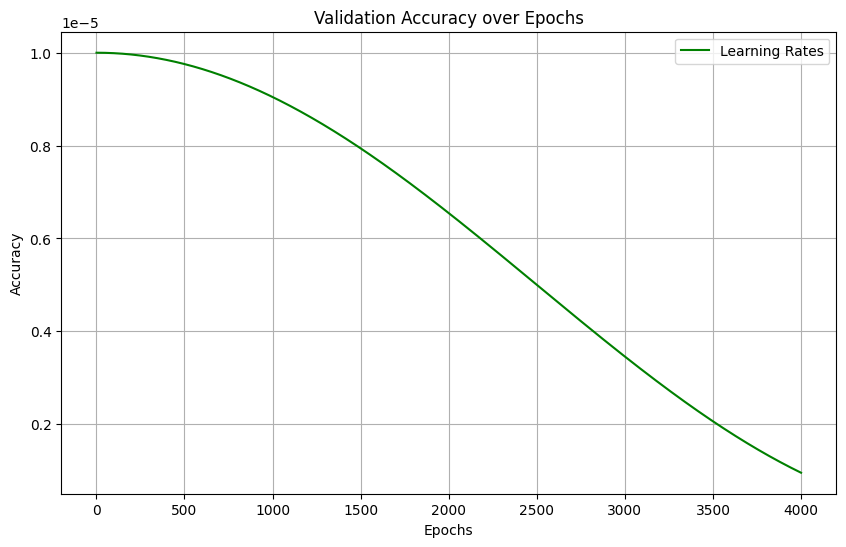

Model for bin 7 saved to GCNModels-5A_exp3/model_bin_7.pth
Training on bin 8/50
Bin 8, Epoch 1/4000, Train Loss: 0.7468, Validation Loss: 0.6761,  Accuracy: 0.7825, LR: 0.000010
Bin 8, Epoch 101/4000, Train Loss: 0.6466, Validation Loss: 0.6225,  Accuracy: 0.8390, LR: 0.000010
Bin 8, Epoch 201/4000, Train Loss: 0.5892, Validation Loss: 0.5709,  Accuracy: 0.8446, LR: 0.000010
Bin 8, Epoch 301/4000, Train Loss: 0.5334, Validation Loss: 0.5370,  Accuracy: 0.8475, LR: 0.000010
Bin 8, Epoch 401/4000, Train Loss: 0.4760, Validation Loss: 0.4765,  Accuracy: 0.8559, LR: 0.000010
Bin 8, Epoch 501/4000, Train Loss: 0.4525, Validation Loss: 0.4290,  Accuracy: 0.8559, LR: 0.000010
Bin 8, Epoch 601/4000, Train Loss: 0.4154, Validation Loss: 0.3923,  Accuracy: 0.8644, LR: 0.000010
Bin 8, Epoch 701/4000, Train Loss: 0.4069, Validation Loss: 0.3780,  Accuracy: 0.8729, LR: 0.000010
Bin 8, Epoch 801/4000, Train Loss: 0.3680, Validation Loss: 0.3208,  Accuracy: 0.8870, LR: 0.000009
Bin 8, Epoch 901/4000,

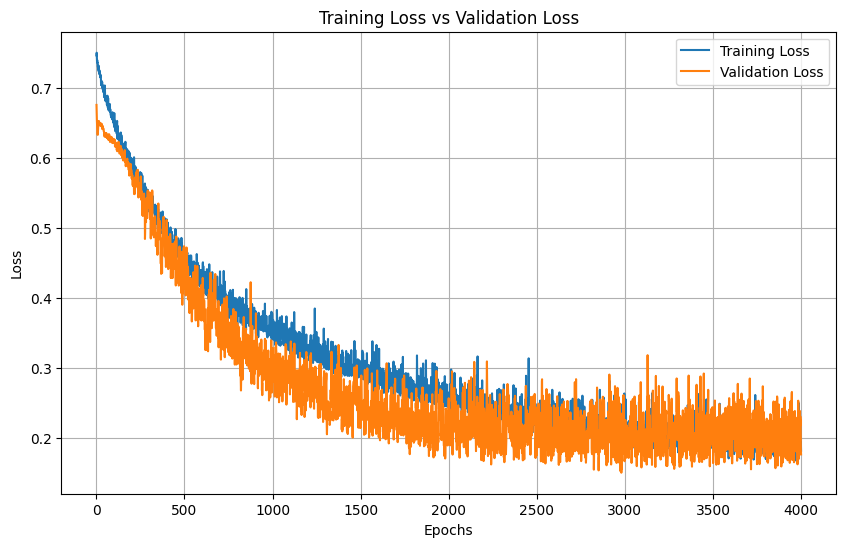

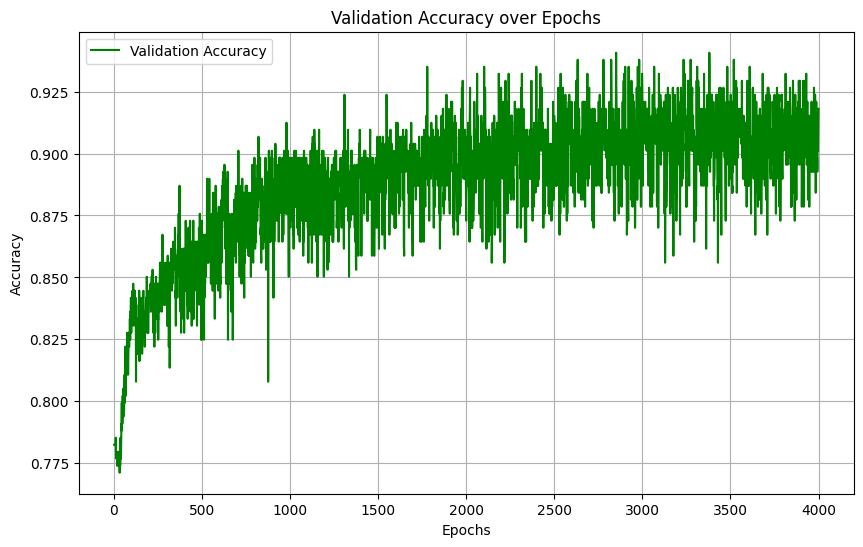

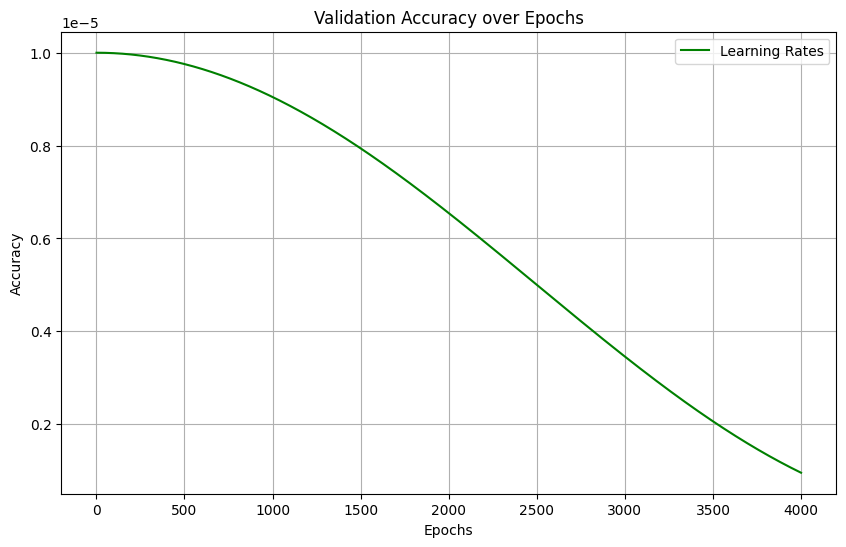

Model for bin 8 saved to GCNModels-5A_exp3/model_bin_8.pth
Training on bin 9/50
Bin 9, Epoch 1/4000, Train Loss: 0.7133, Validation Loss: 0.7374,  Accuracy: 0.2175, LR: 0.000010
Bin 9, Epoch 101/4000, Train Loss: 0.6391, Validation Loss: 0.6698,  Accuracy: 0.6356, LR: 0.000010
Bin 9, Epoch 201/4000, Train Loss: 0.5828, Validation Loss: 0.6047,  Accuracy: 0.7712, LR: 0.000010
Bin 9, Epoch 301/4000, Train Loss: 0.5361, Validation Loss: 0.5261,  Accuracy: 0.8305, LR: 0.000010
Bin 9, Epoch 401/4000, Train Loss: 0.4978, Validation Loss: 0.4956,  Accuracy: 0.8277, LR: 0.000010
Bin 9, Epoch 501/4000, Train Loss: 0.4535, Validation Loss: 0.4049,  Accuracy: 0.8757, LR: 0.000010
Bin 9, Epoch 601/4000, Train Loss: 0.4262, Validation Loss: 0.3806,  Accuracy: 0.8672, LR: 0.000010
Bin 9, Epoch 701/4000, Train Loss: 0.4214, Validation Loss: 0.3700,  Accuracy: 0.8701, LR: 0.000010
Bin 9, Epoch 801/4000, Train Loss: 0.4066, Validation Loss: 0.3715,  Accuracy: 0.8701, LR: 0.000009
Bin 9, Epoch 901/4000,

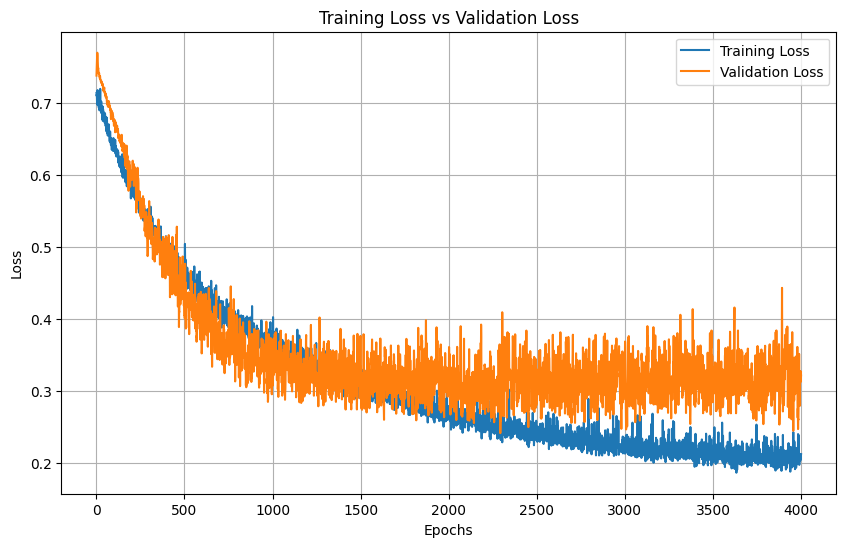

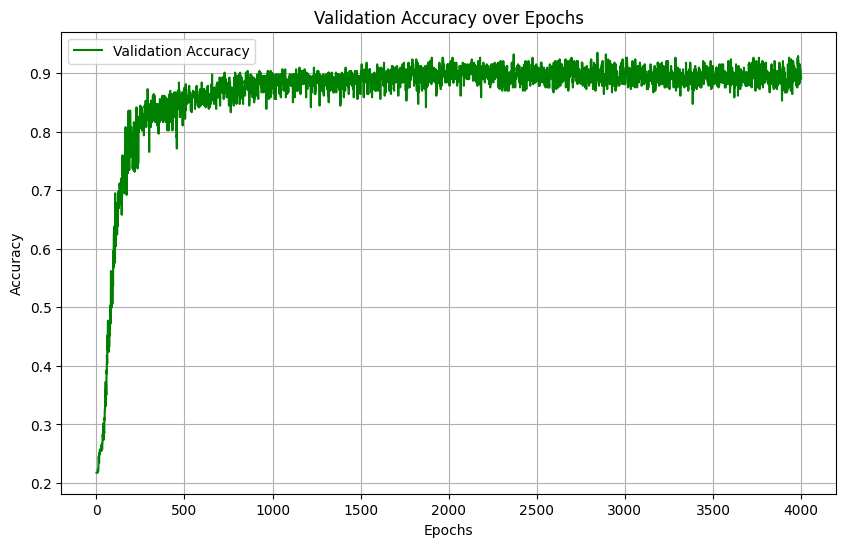

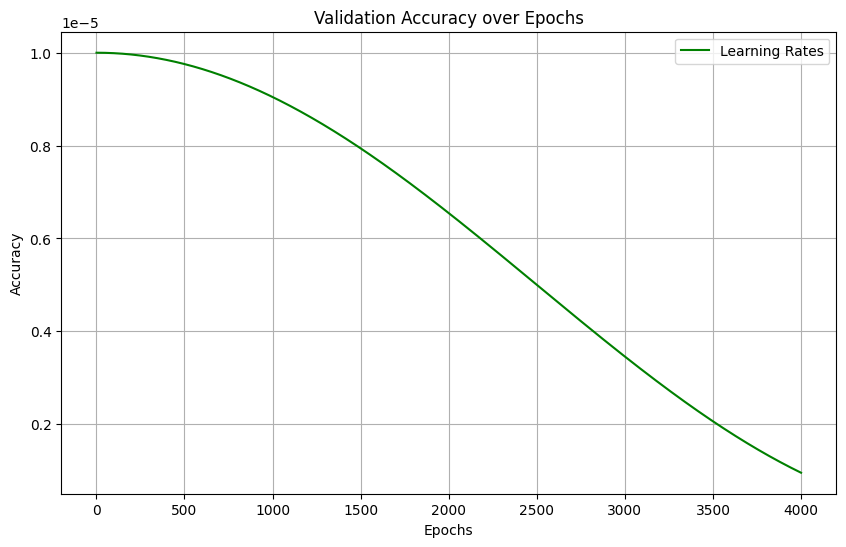

Model for bin 9 saved to GCNModels-5A_exp3/model_bin_9.pth
Training on bin 10/50
Bin 10, Epoch 1/4000, Train Loss: 0.7043, Validation Loss: 0.6953,  Accuracy: 0.1667, LR: 0.000010
Bin 10, Epoch 101/4000, Train Loss: 0.6148, Validation Loss: 0.6453,  Accuracy: 0.7260, LR: 0.000010
Bin 10, Epoch 201/4000, Train Loss: 0.5670, Validation Loss: 0.5613,  Accuracy: 0.8305, LR: 0.000010
Bin 10, Epoch 301/4000, Train Loss: 0.5064, Validation Loss: 0.4899,  Accuracy: 0.8418, LR: 0.000010
Bin 10, Epoch 401/4000, Train Loss: 0.4874, Validation Loss: 0.4436,  Accuracy: 0.8475, LR: 0.000010
Bin 10, Epoch 501/4000, Train Loss: 0.4482, Validation Loss: 0.3915,  Accuracy: 0.8785, LR: 0.000010
Bin 10, Epoch 601/4000, Train Loss: 0.4113, Validation Loss: 0.3330,  Accuracy: 0.8870, LR: 0.000010
Bin 10, Epoch 701/4000, Train Loss: 0.4003, Validation Loss: 0.3264,  Accuracy: 0.8898, LR: 0.000010
Bin 10, Epoch 801/4000, Train Loss: 0.3683, Validation Loss: 0.2393,  Accuracy: 0.9096, LR: 0.000009
Bin 10, Epoc

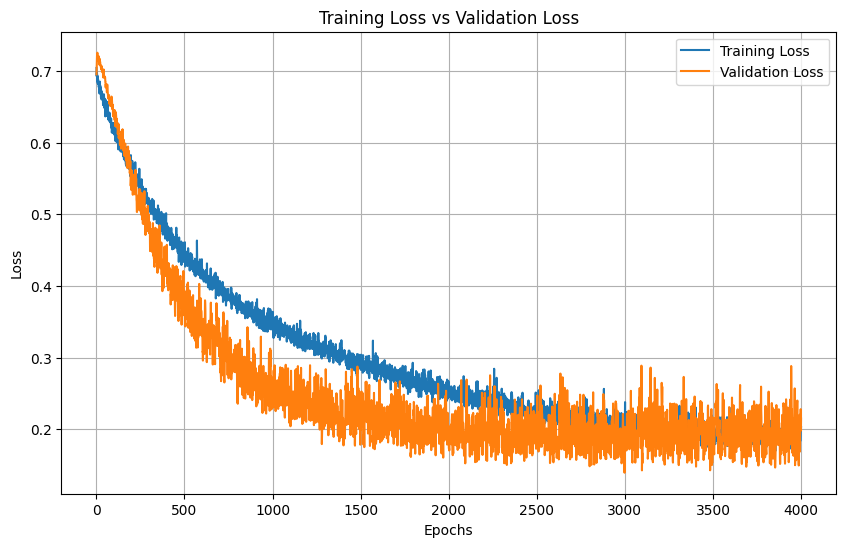

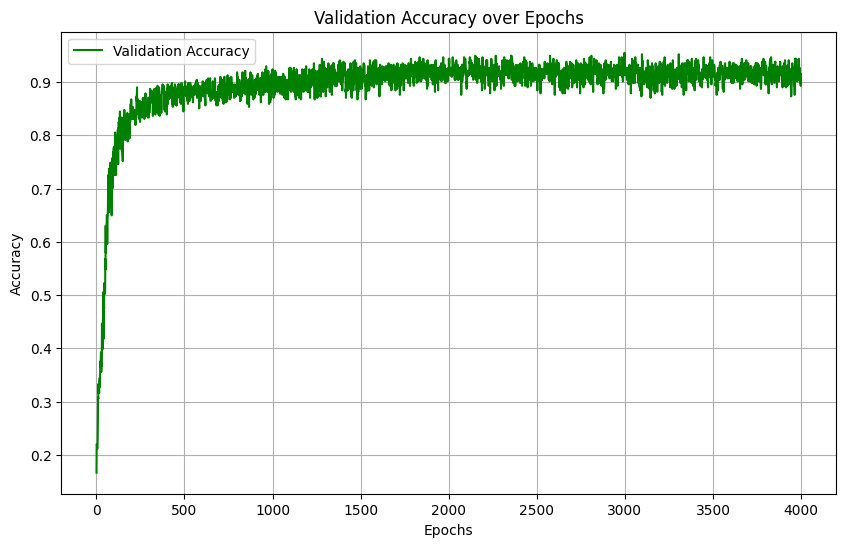

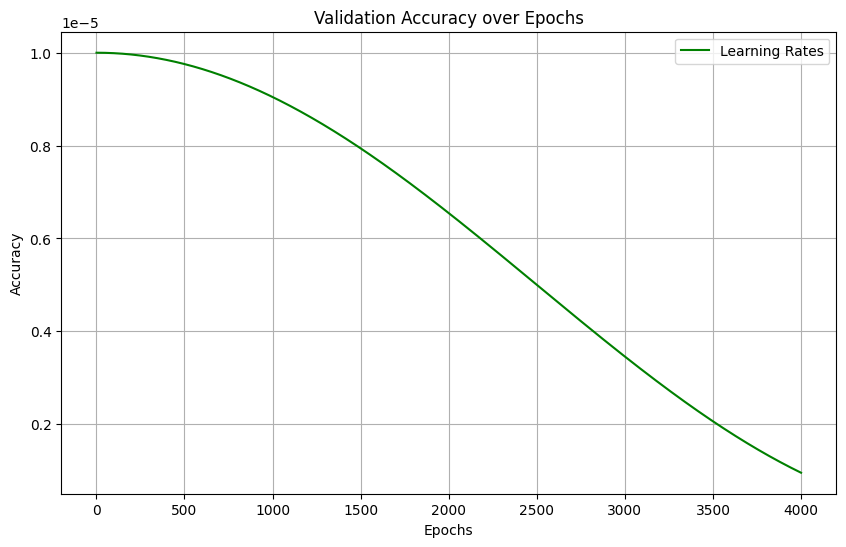

Model for bin 10 saved to GCNModels-5A_exp3/model_bin_10.pth
Training on bin 11/50
Bin 11, Epoch 1/4000, Train Loss: 0.7257, Validation Loss: 0.6721,  Accuracy: 0.7825, LR: 0.000010
Bin 11, Epoch 101/4000, Train Loss: 0.6366, Validation Loss: 0.6265,  Accuracy: 0.8164, LR: 0.000010
Bin 11, Epoch 201/4000, Train Loss: 0.5965, Validation Loss: 0.5863,  Accuracy: 0.8051, LR: 0.000010
Bin 11, Epoch 301/4000, Train Loss: 0.5430, Validation Loss: 0.5298,  Accuracy: 0.8249, LR: 0.000010
Bin 11, Epoch 401/4000, Train Loss: 0.5016, Validation Loss: 0.4485,  Accuracy: 0.8559, LR: 0.000010
Bin 11, Epoch 501/4000, Train Loss: 0.4759, Validation Loss: 0.3845,  Accuracy: 0.8672, LR: 0.000010
Bin 11, Epoch 601/4000, Train Loss: 0.4603, Validation Loss: 0.4097,  Accuracy: 0.8503, LR: 0.000010
Bin 11, Epoch 701/4000, Train Loss: 0.4245, Validation Loss: 0.3367,  Accuracy: 0.8870, LR: 0.000010
Bin 11, Epoch 801/4000, Train Loss: 0.4049, Validation Loss: 0.3890,  Accuracy: 0.8390, LR: 0.000009
Bin 11, Ep

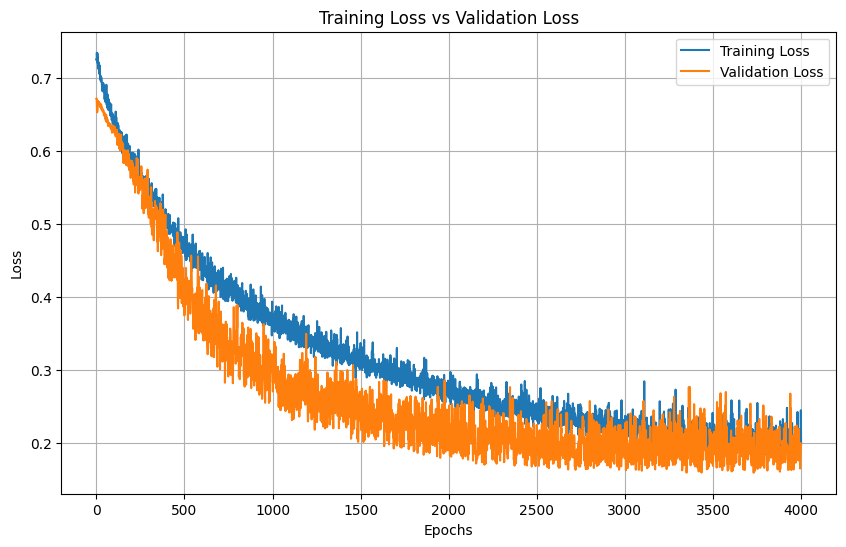

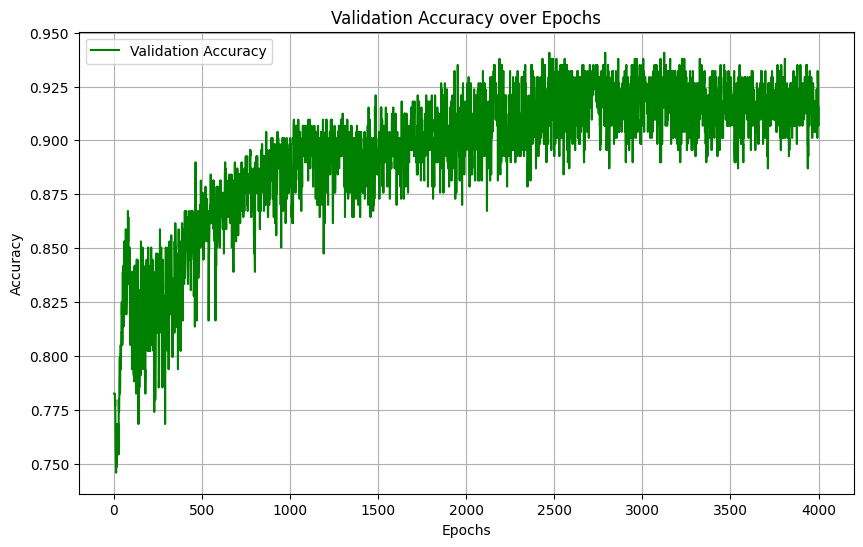

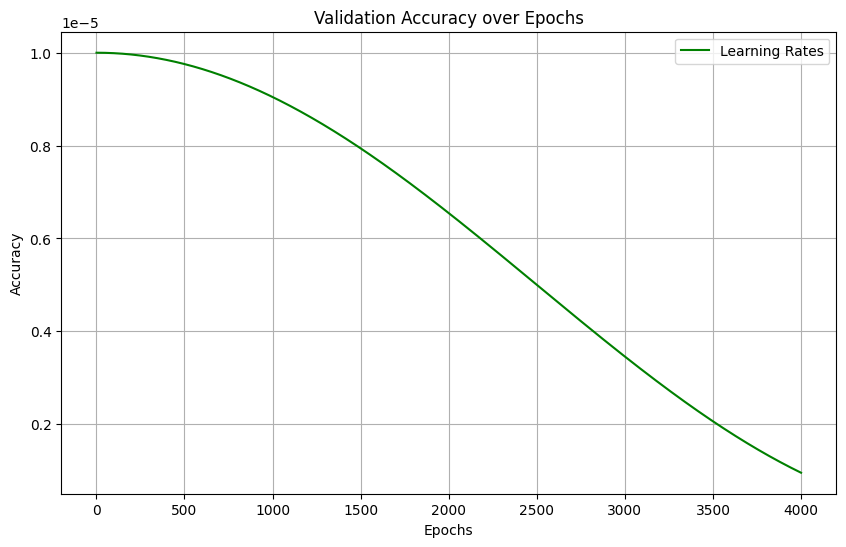

Model for bin 11 saved to GCNModels-5A_exp3/model_bin_11.pth
Training on bin 12/50
Bin 12, Epoch 1/4000, Train Loss: 0.6891, Validation Loss: 0.6822,  Accuracy: 0.7825, LR: 0.000010
Bin 12, Epoch 101/4000, Train Loss: 0.6426, Validation Loss: 0.6486,  Accuracy: 0.7627, LR: 0.000010
Bin 12, Epoch 201/4000, Train Loss: 0.6024, Validation Loss: 0.5869,  Accuracy: 0.8333, LR: 0.000010
Bin 12, Epoch 301/4000, Train Loss: 0.5604, Validation Loss: 0.5383,  Accuracy: 0.8446, LR: 0.000010
Bin 12, Epoch 401/4000, Train Loss: 0.5086, Validation Loss: 0.4896,  Accuracy: 0.8559, LR: 0.000010
Bin 12, Epoch 501/4000, Train Loss: 0.4726, Validation Loss: 0.4158,  Accuracy: 0.8672, LR: 0.000010
Bin 12, Epoch 601/4000, Train Loss: 0.4718, Validation Loss: 0.3867,  Accuracy: 0.8729, LR: 0.000010
Bin 12, Epoch 701/4000, Train Loss: 0.4461, Validation Loss: 0.3766,  Accuracy: 0.8644, LR: 0.000010
Bin 12, Epoch 801/4000, Train Loss: 0.4126, Validation Loss: 0.3196,  Accuracy: 0.8814, LR: 0.000009
Bin 12, Ep

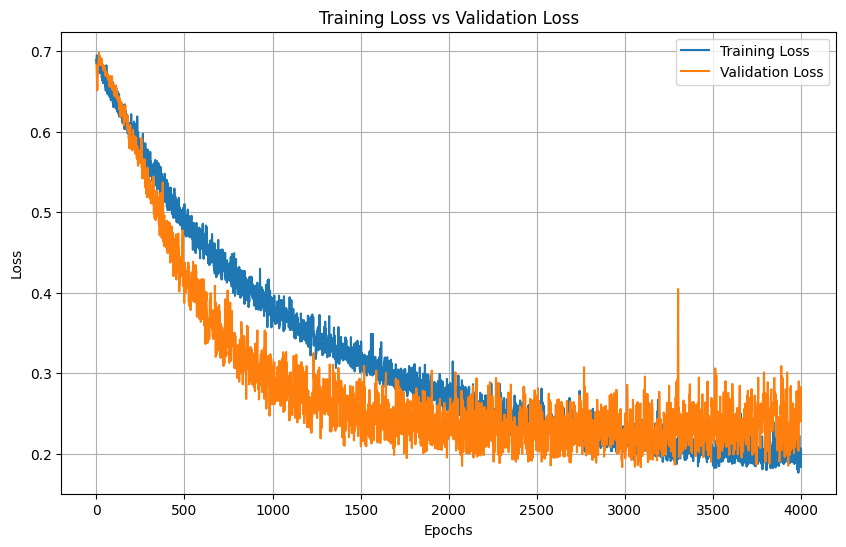

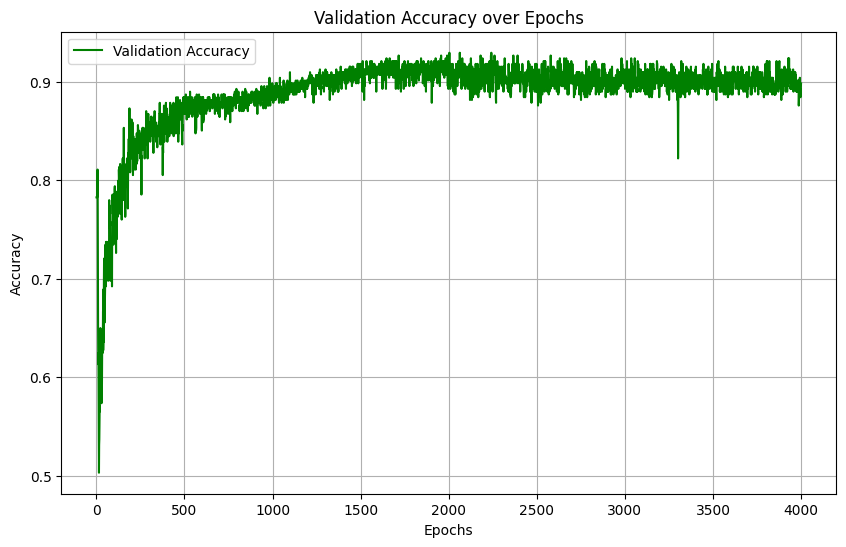

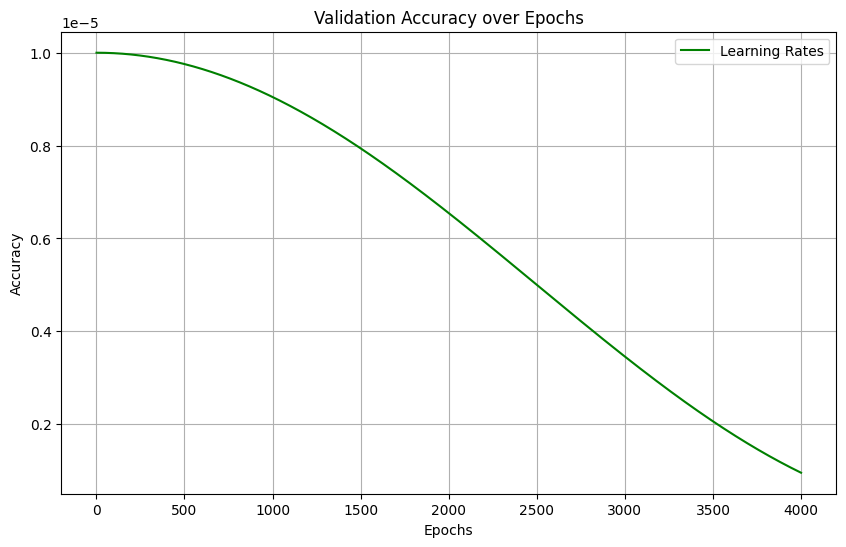

Model for bin 12 saved to GCNModels-5A_exp3/model_bin_12.pth
Training on bin 13/50
Bin 13, Epoch 1/4000, Train Loss: 0.7292, Validation Loss: 0.7253,  Accuracy: 0.2175, LR: 0.000010
Bin 13, Epoch 101/4000, Train Loss: 0.6575, Validation Loss: 0.6615,  Accuracy: 0.6723, LR: 0.000010
Bin 13, Epoch 201/4000, Train Loss: 0.5885, Validation Loss: 0.6158,  Accuracy: 0.7232, LR: 0.000010
Bin 13, Epoch 301/4000, Train Loss: 0.5339, Validation Loss: 0.5064,  Accuracy: 0.8531, LR: 0.000010
Bin 13, Epoch 401/4000, Train Loss: 0.5020, Validation Loss: 0.5027,  Accuracy: 0.7712, LR: 0.000010
Bin 13, Epoch 501/4000, Train Loss: 0.4559, Validation Loss: 0.3907,  Accuracy: 0.8814, LR: 0.000010
Bin 13, Epoch 601/4000, Train Loss: 0.4251, Validation Loss: 0.4102,  Accuracy: 0.8249, LR: 0.000010
Bin 13, Epoch 701/4000, Train Loss: 0.3842, Validation Loss: 0.3662,  Accuracy: 0.8588, LR: 0.000010
Bin 13, Epoch 801/4000, Train Loss: 0.3770, Validation Loss: 0.3209,  Accuracy: 0.8814, LR: 0.000009
Bin 13, Ep

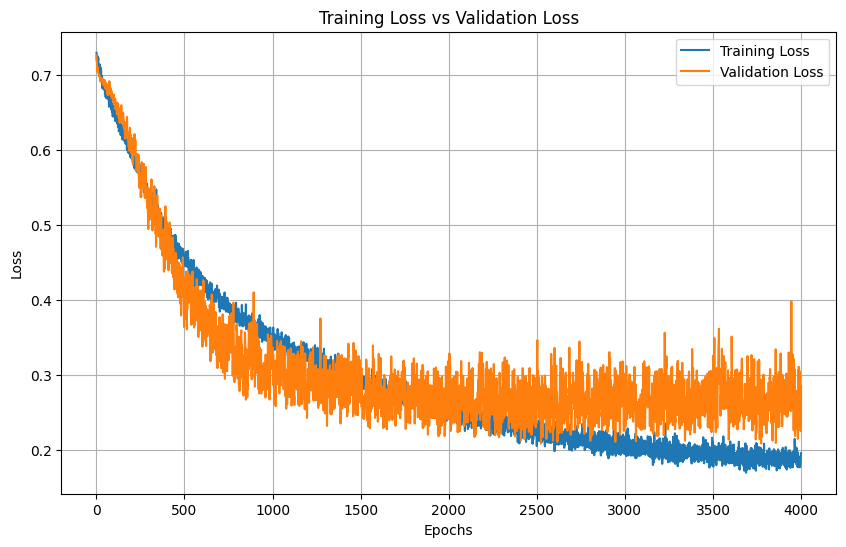

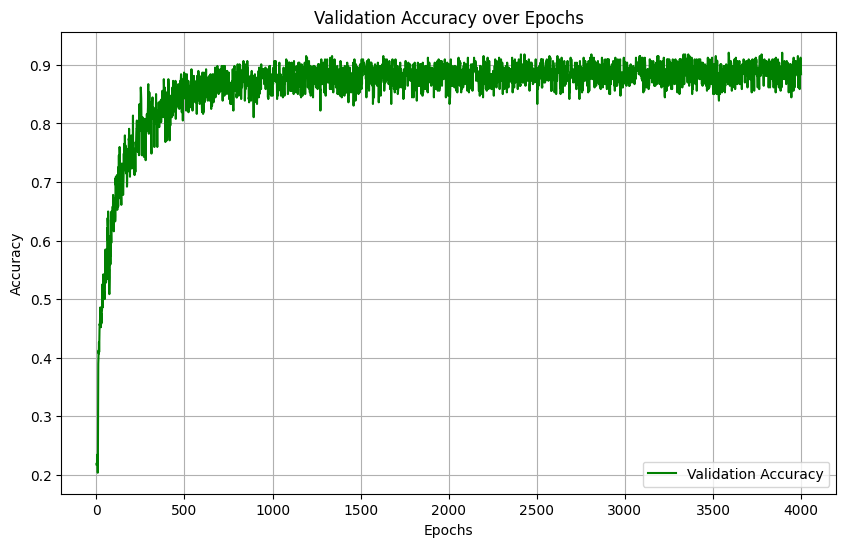

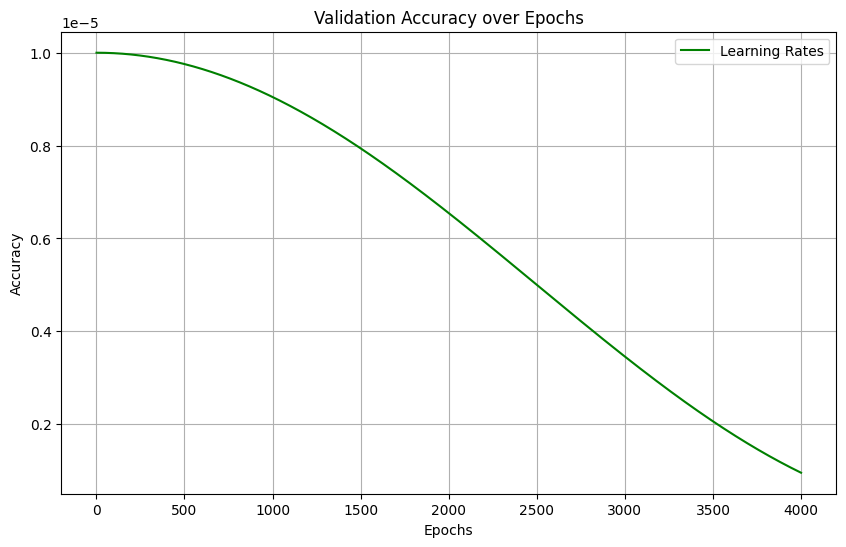

Model for bin 13 saved to GCNModels-5A_exp3/model_bin_13.pth
Training on bin 14/50
Bin 14, Epoch 1/4000, Train Loss: 0.7039, Validation Loss: 0.7071,  Accuracy: 0.2175, LR: 0.000010
Bin 14, Epoch 101/4000, Train Loss: 0.6141, Validation Loss: 0.6166,  Accuracy: 0.8249, LR: 0.000010
Bin 14, Epoch 201/4000, Train Loss: 0.5462, Validation Loss: 0.5456,  Accuracy: 0.8418, LR: 0.000010
Bin 14, Epoch 301/4000, Train Loss: 0.4825, Validation Loss: 0.4647,  Accuracy: 0.8616, LR: 0.000010
Bin 14, Epoch 401/4000, Train Loss: 0.4398, Validation Loss: 0.3953,  Accuracy: 0.8842, LR: 0.000010
Bin 14, Epoch 501/4000, Train Loss: 0.4101, Validation Loss: 0.3599,  Accuracy: 0.8814, LR: 0.000010
Bin 14, Epoch 601/4000, Train Loss: 0.3593, Validation Loss: 0.3352,  Accuracy: 0.8814, LR: 0.000010
Bin 14, Epoch 701/4000, Train Loss: 0.3544, Validation Loss: 0.2928,  Accuracy: 0.8955, LR: 0.000010
Bin 14, Epoch 801/4000, Train Loss: 0.3293, Validation Loss: 0.2554,  Accuracy: 0.8983, LR: 0.000009
Bin 14, Ep

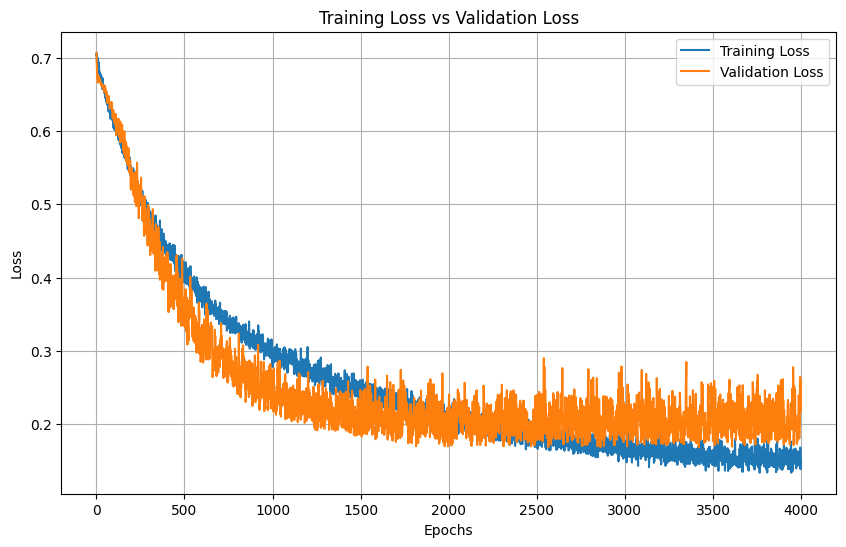

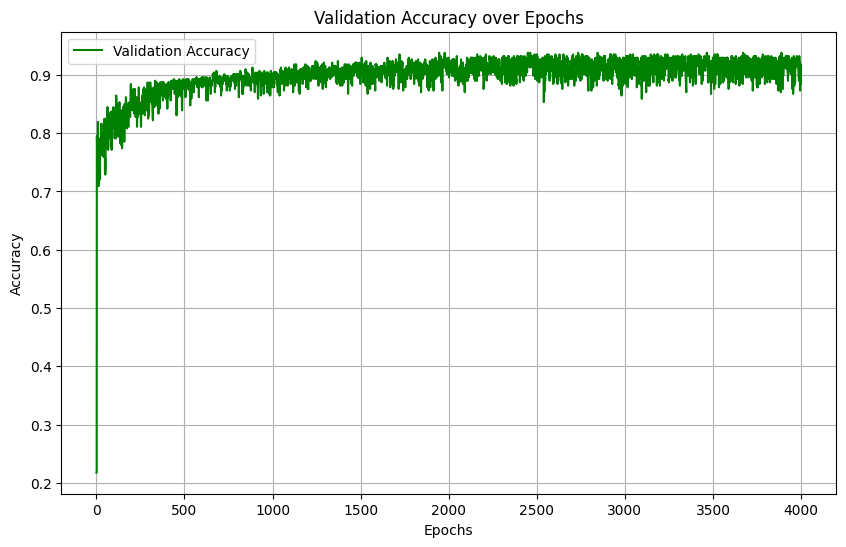

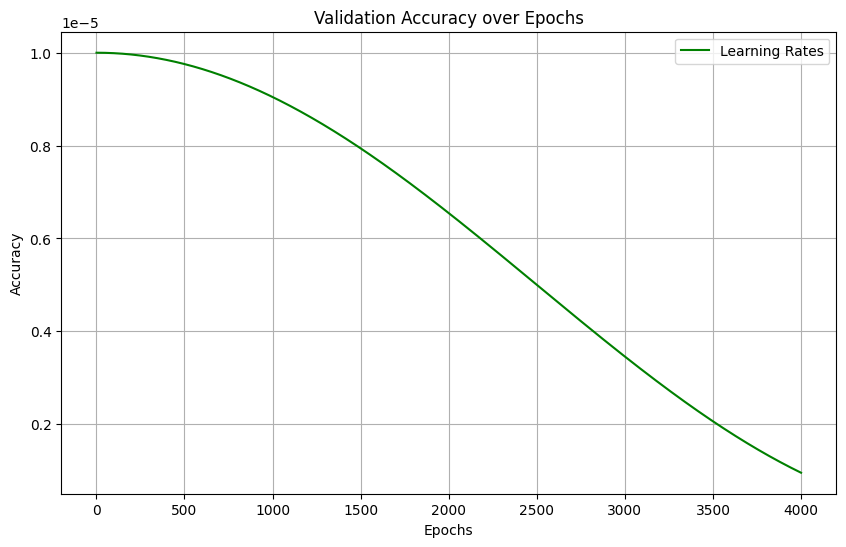

Model for bin 14 saved to GCNModels-5A_exp3/model_bin_14.pth
Training on bin 15/50
Bin 15, Epoch 1/4000, Train Loss: 0.6986, Validation Loss: 0.6740,  Accuracy: 0.7825, LR: 0.000010
Bin 15, Epoch 101/4000, Train Loss: 0.6080, Validation Loss: 0.5892,  Accuracy: 0.8475, LR: 0.000010
Bin 15, Epoch 201/4000, Train Loss: 0.5338, Validation Loss: 0.5020,  Accuracy: 0.8588, LR: 0.000010
Bin 15, Epoch 301/4000, Train Loss: 0.4865, Validation Loss: 0.4363,  Accuracy: 0.8588, LR: 0.000010
Bin 15, Epoch 401/4000, Train Loss: 0.4470, Validation Loss: 0.3653,  Accuracy: 0.8785, LR: 0.000010
Bin 15, Epoch 501/4000, Train Loss: 0.4171, Validation Loss: 0.3999,  Accuracy: 0.8305, LR: 0.000010
Bin 15, Epoch 601/4000, Train Loss: 0.3960, Validation Loss: 0.3246,  Accuracy: 0.8588, LR: 0.000010
Bin 15, Epoch 701/4000, Train Loss: 0.3852, Validation Loss: 0.2845,  Accuracy: 0.8701, LR: 0.000010
Bin 15, Epoch 801/4000, Train Loss: 0.3825, Validation Loss: 0.2831,  Accuracy: 0.8701, LR: 0.000009
Bin 15, Ep

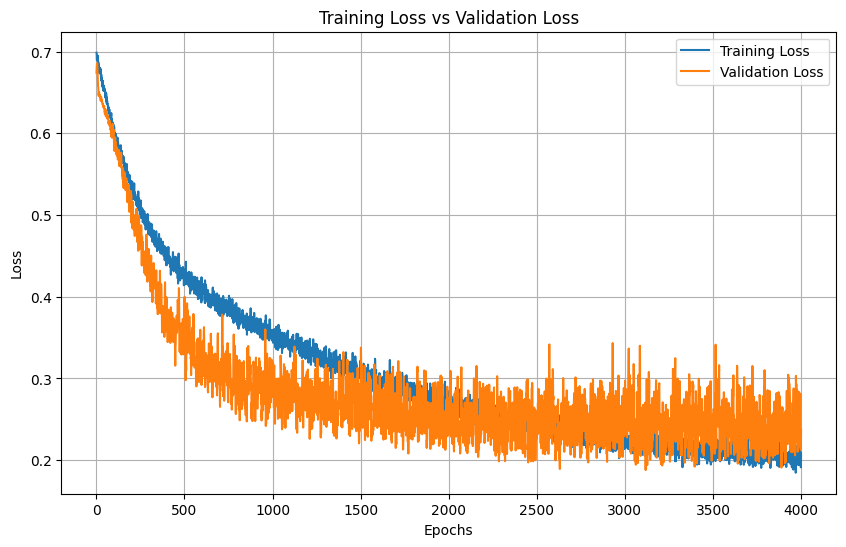

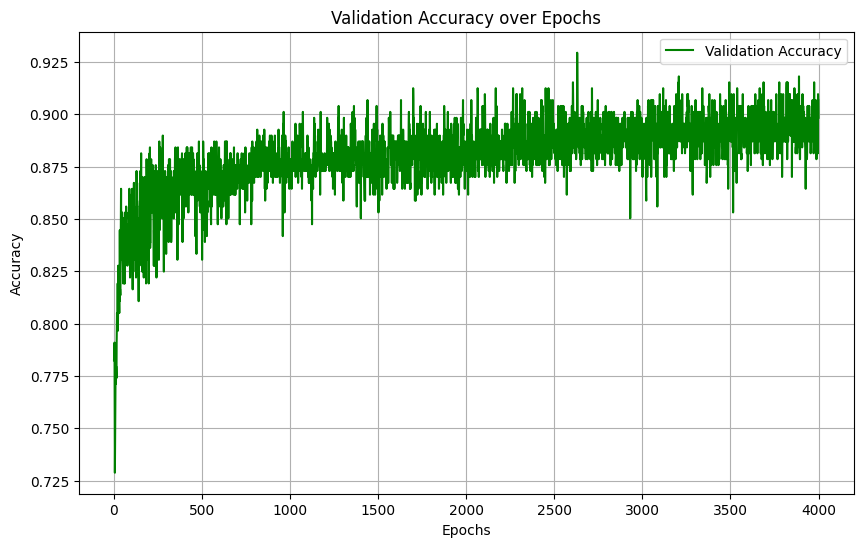

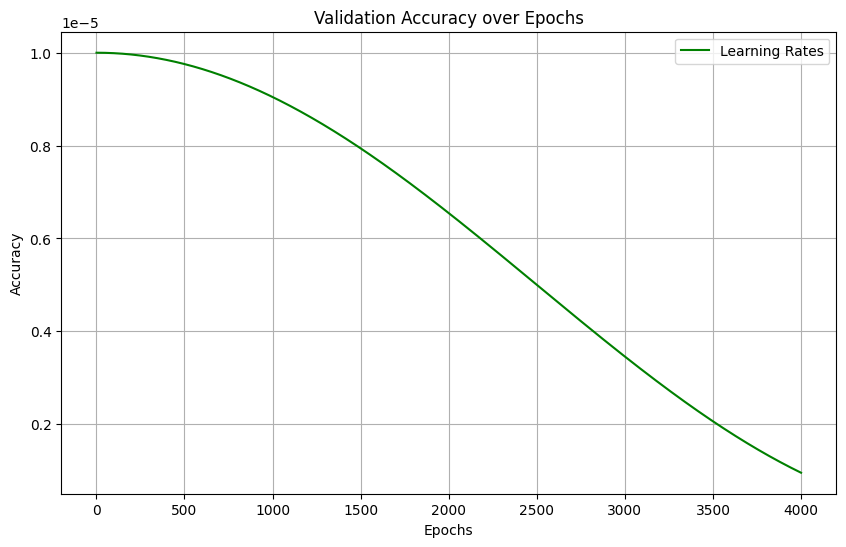

Model for bin 15 saved to GCNModels-5A_exp3/model_bin_15.pth
Training on bin 16/50
Bin 16, Epoch 1/4000, Train Loss: 0.7272, Validation Loss: 0.6676,  Accuracy: 0.7825, LR: 0.000010
Bin 16, Epoch 101/4000, Train Loss: 0.6233, Validation Loss: 0.6309,  Accuracy: 0.7768, LR: 0.000010
Bin 16, Epoch 201/4000, Train Loss: 0.5700, Validation Loss: 0.5656,  Accuracy: 0.8249, LR: 0.000010
Bin 16, Epoch 301/4000, Train Loss: 0.5360, Validation Loss: 0.4997,  Accuracy: 0.8588, LR: 0.000010
Bin 16, Epoch 401/4000, Train Loss: 0.4864, Validation Loss: 0.4493,  Accuracy: 0.8446, LR: 0.000010
Bin 16, Epoch 501/4000, Train Loss: 0.4435, Validation Loss: 0.3752,  Accuracy: 0.8785, LR: 0.000010
Bin 16, Epoch 601/4000, Train Loss: 0.4265, Validation Loss: 0.3829,  Accuracy: 0.8588, LR: 0.000010
Bin 16, Epoch 701/4000, Train Loss: 0.3803, Validation Loss: 0.3612,  Accuracy: 0.8531, LR: 0.000010
Bin 16, Epoch 801/4000, Train Loss: 0.3664, Validation Loss: 0.3628,  Accuracy: 0.8531, LR: 0.000009
Bin 16, Ep

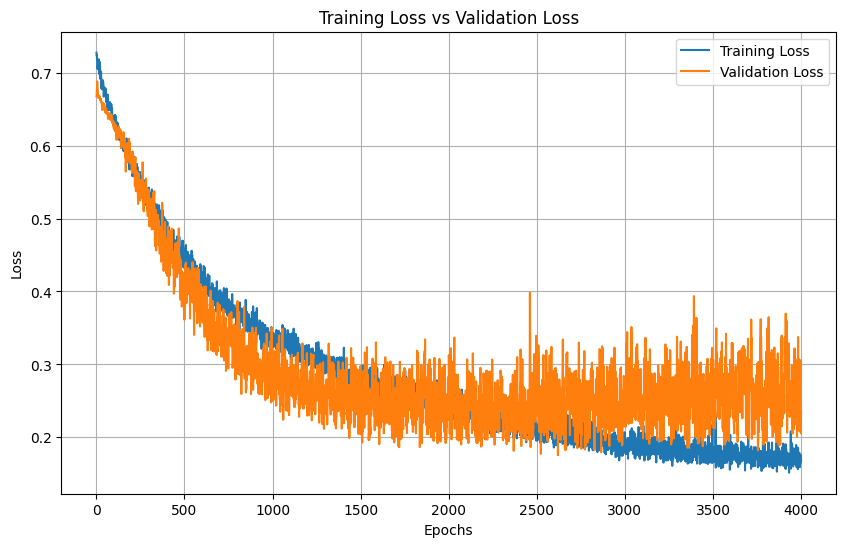

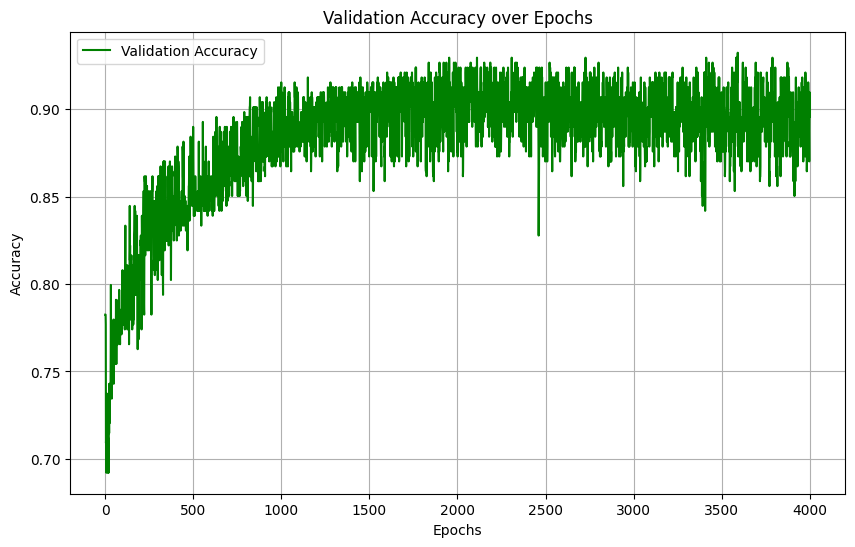

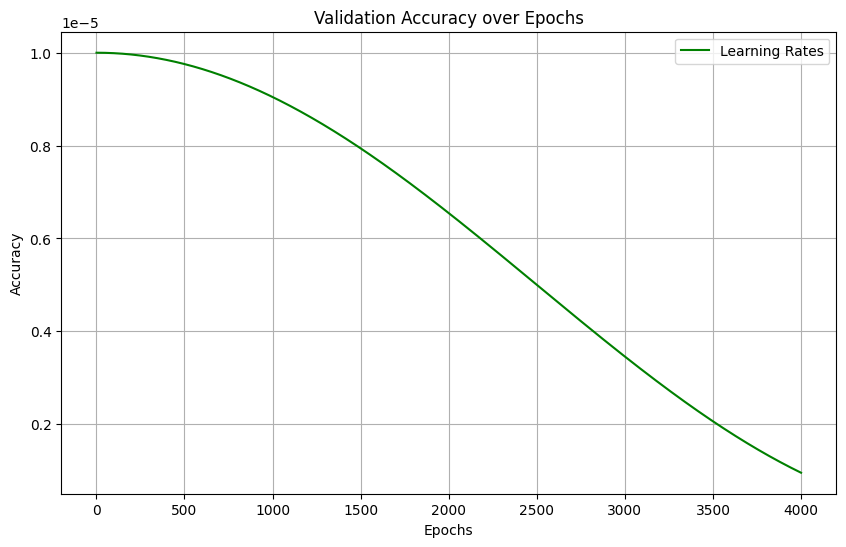

Model for bin 16 saved to GCNModels-5A_exp3/model_bin_16.pth
Training on bin 17/50
Bin 17, Epoch 1/4000, Train Loss: 0.7020, Validation Loss: 0.6873,  Accuracy: 0.7825, LR: 0.000010
Bin 17, Epoch 101/4000, Train Loss: 0.6321, Validation Loss: 0.6606,  Accuracy: 0.6893, LR: 0.000010
Bin 17, Epoch 201/4000, Train Loss: 0.5877, Validation Loss: 0.5891,  Accuracy: 0.7994, LR: 0.000010
Bin 17, Epoch 301/4000, Train Loss: 0.5302, Validation Loss: 0.5351,  Accuracy: 0.8051, LR: 0.000010
Bin 17, Epoch 401/4000, Train Loss: 0.4995, Validation Loss: 0.4489,  Accuracy: 0.8757, LR: 0.000010
Bin 17, Epoch 501/4000, Train Loss: 0.4715, Validation Loss: 0.4023,  Accuracy: 0.8701, LR: 0.000010
Bin 17, Epoch 601/4000, Train Loss: 0.4259, Validation Loss: 0.3677,  Accuracy: 0.8701, LR: 0.000010
Bin 17, Epoch 701/4000, Train Loss: 0.3957, Validation Loss: 0.3264,  Accuracy: 0.8898, LR: 0.000010
Bin 17, Epoch 801/4000, Train Loss: 0.3860, Validation Loss: 0.2879,  Accuracy: 0.9096, LR: 0.000009
Bin 17, Ep

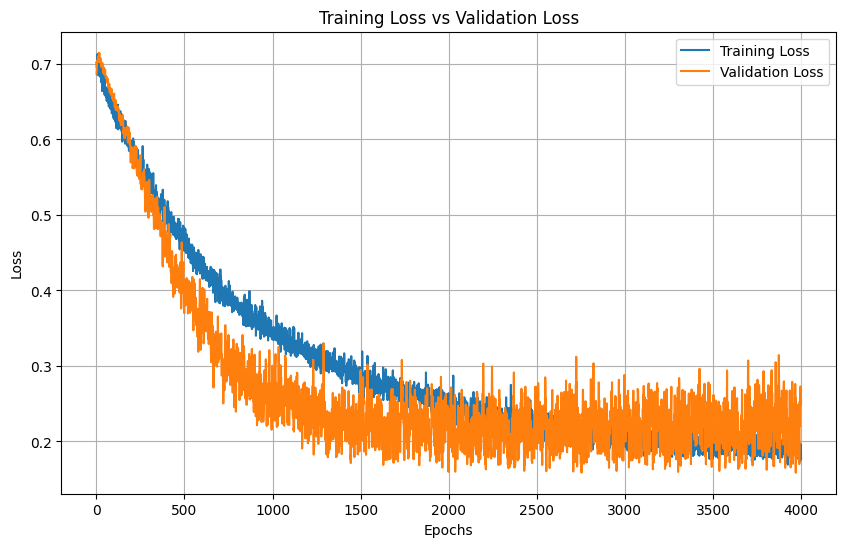

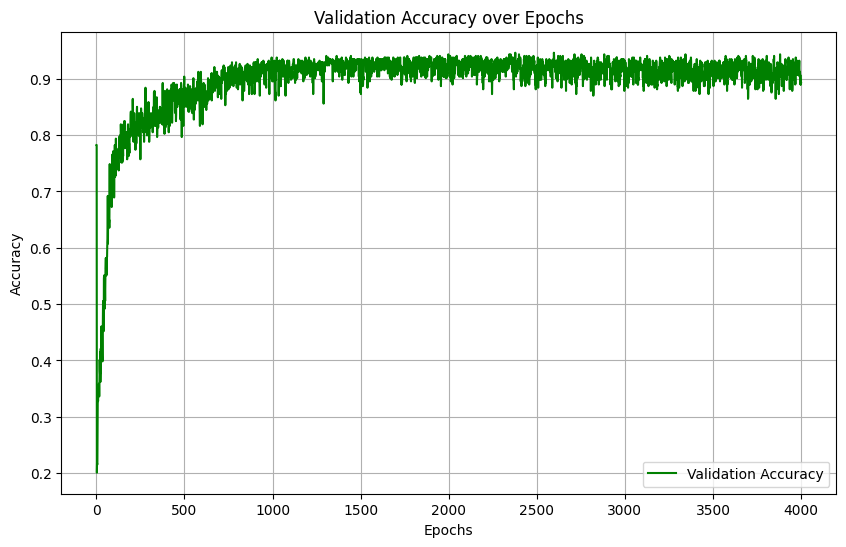

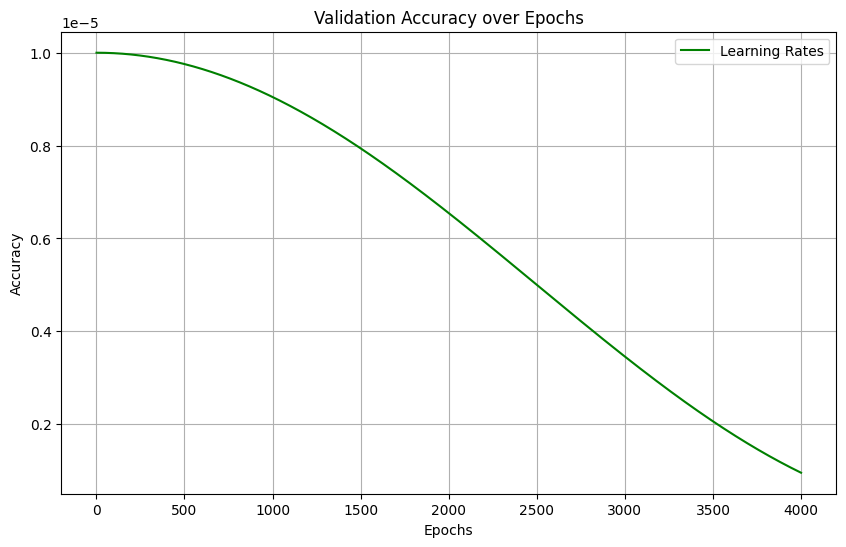

Model for bin 17 saved to GCNModels-5A_exp3/model_bin_17.pth
Training on bin 18/50
Bin 18, Epoch 1/4000, Train Loss: 0.7019, Validation Loss: 0.7040,  Accuracy: 0.2175, LR: 0.000010
Bin 18, Epoch 101/4000, Train Loss: 0.6164, Validation Loss: 0.6363,  Accuracy: 0.7486, LR: 0.000010
Bin 18, Epoch 201/4000, Train Loss: 0.5701, Validation Loss: 0.5159,  Accuracy: 0.8503, LR: 0.000010
Bin 18, Epoch 301/4000, Train Loss: 0.5168, Validation Loss: 0.5041,  Accuracy: 0.8220, LR: 0.000010
Bin 18, Epoch 401/4000, Train Loss: 0.4727, Validation Loss: 0.3754,  Accuracy: 0.8757, LR: 0.000010
Bin 18, Epoch 501/4000, Train Loss: 0.4430, Validation Loss: 0.3373,  Accuracy: 0.8927, LR: 0.000010
Bin 18, Epoch 601/4000, Train Loss: 0.4202, Validation Loss: 0.3395,  Accuracy: 0.8531, LR: 0.000010
Bin 18, Epoch 701/4000, Train Loss: 0.3749, Validation Loss: 0.2670,  Accuracy: 0.9096, LR: 0.000010
Bin 18, Epoch 801/4000, Train Loss: 0.3793, Validation Loss: 0.2923,  Accuracy: 0.8757, LR: 0.000009
Bin 18, Ep

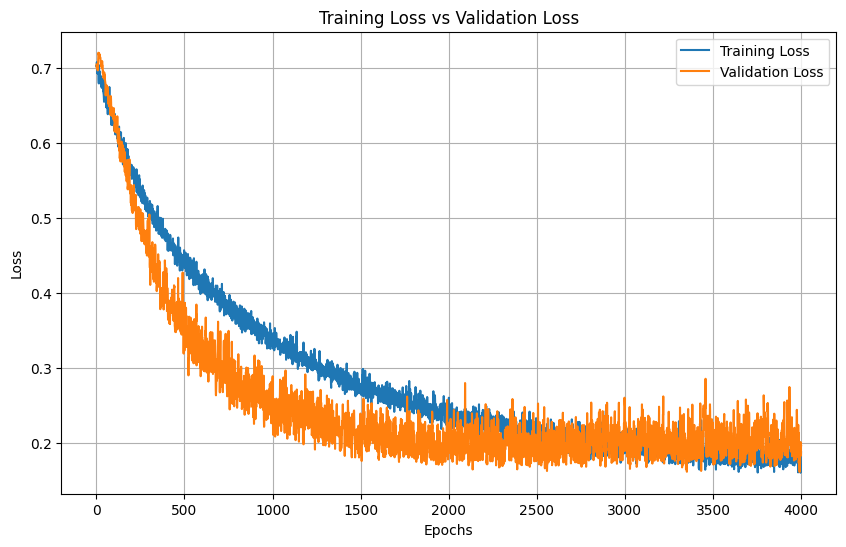

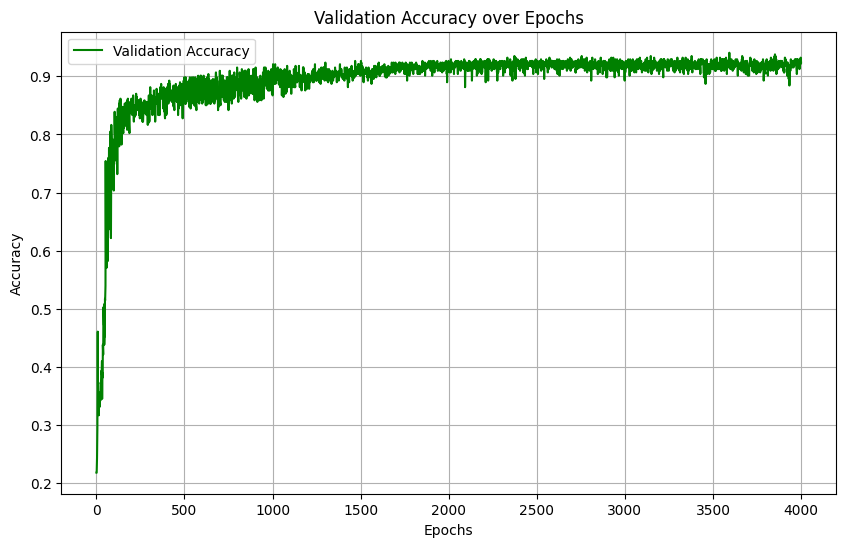

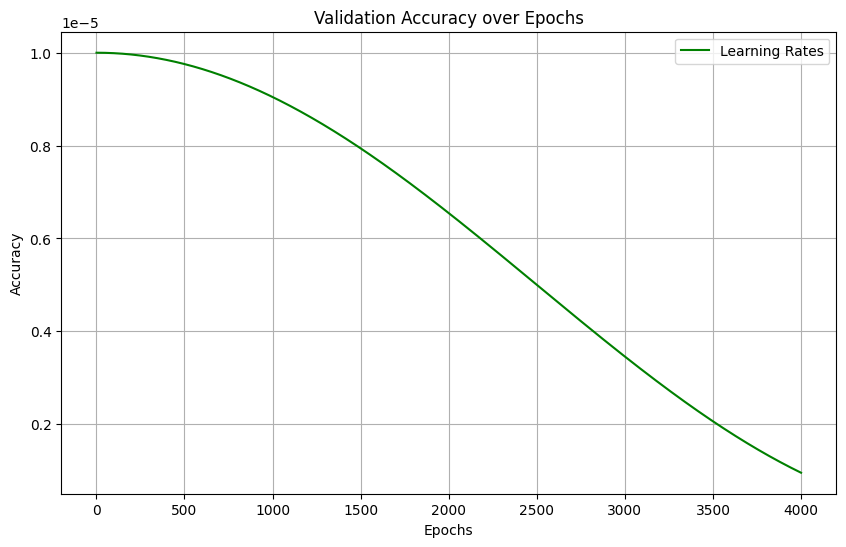

Model for bin 18 saved to GCNModels-5A_exp3/model_bin_18.pth
Training on bin 19/50
Bin 19, Epoch 1/4000, Train Loss: 0.6983, Validation Loss: 0.7053,  Accuracy: 0.2175, LR: 0.000010
Bin 19, Epoch 101/4000, Train Loss: 0.6407, Validation Loss: 0.6601,  Accuracy: 0.6808, LR: 0.000010
Bin 19, Epoch 201/4000, Train Loss: 0.5829, Validation Loss: 0.6033,  Accuracy: 0.7881, LR: 0.000010
Bin 19, Epoch 301/4000, Train Loss: 0.5232, Validation Loss: 0.5460,  Accuracy: 0.8023, LR: 0.000010
Bin 19, Epoch 401/4000, Train Loss: 0.4827, Validation Loss: 0.4973,  Accuracy: 0.8220, LR: 0.000010
Bin 19, Epoch 501/4000, Train Loss: 0.4421, Validation Loss: 0.4213,  Accuracy: 0.8475, LR: 0.000010
Bin 19, Epoch 601/4000, Train Loss: 0.4198, Validation Loss: 0.3833,  Accuracy: 0.8559, LR: 0.000010
Bin 19, Epoch 701/4000, Train Loss: 0.3850, Validation Loss: 0.3722,  Accuracy: 0.8616, LR: 0.000010
Bin 19, Epoch 801/4000, Train Loss: 0.3656, Validation Loss: 0.3194,  Accuracy: 0.8814, LR: 0.000009
Bin 19, Ep

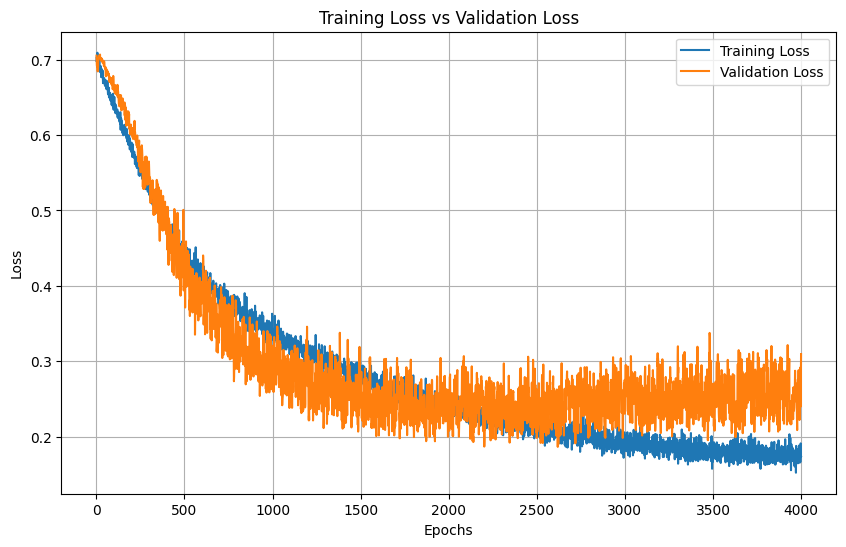

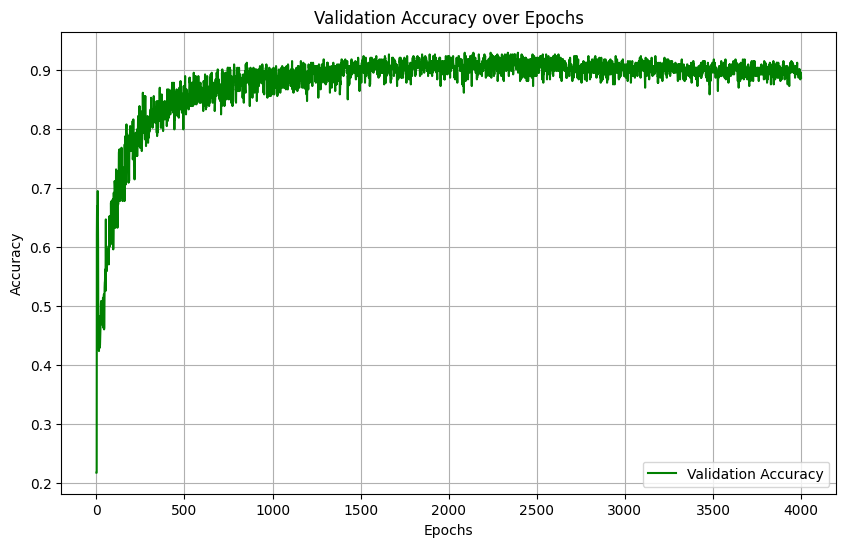

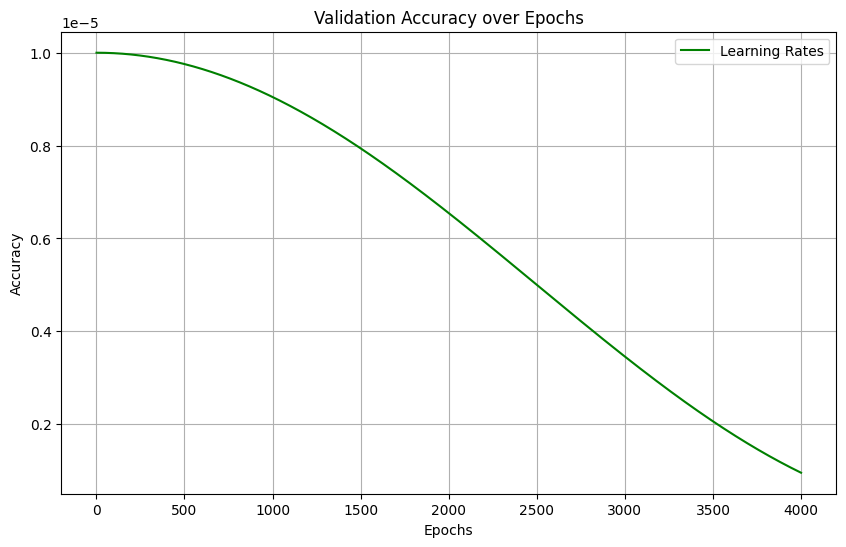

Model for bin 19 saved to GCNModels-5A_exp3/model_bin_19.pth
Training on bin 20/50
Bin 20, Epoch 1/4000, Train Loss: 0.6994, Validation Loss: 0.6708,  Accuracy: 0.7825, LR: 0.000010
Bin 20, Epoch 101/4000, Train Loss: 0.6246, Validation Loss: 0.6113,  Accuracy: 0.8559, LR: 0.000010
Bin 20, Epoch 201/4000, Train Loss: 0.5702, Validation Loss: 0.5349,  Accuracy: 0.8588, LR: 0.000010
Bin 20, Epoch 301/4000, Train Loss: 0.5286, Validation Loss: 0.4554,  Accuracy: 0.8672, LR: 0.000010
Bin 20, Epoch 401/4000, Train Loss: 0.4869, Validation Loss: 0.4134,  Accuracy: 0.8757, LR: 0.000010
Bin 20, Epoch 501/4000, Train Loss: 0.4359, Validation Loss: 0.3459,  Accuracy: 0.8842, LR: 0.000010
Bin 20, Epoch 601/4000, Train Loss: 0.4313, Validation Loss: 0.3277,  Accuracy: 0.8757, LR: 0.000010
Bin 20, Epoch 701/4000, Train Loss: 0.3941, Validation Loss: 0.3231,  Accuracy: 0.8898, LR: 0.000010
Bin 20, Epoch 801/4000, Train Loss: 0.3779, Validation Loss: 0.3061,  Accuracy: 0.8927, LR: 0.000009
Bin 20, Ep

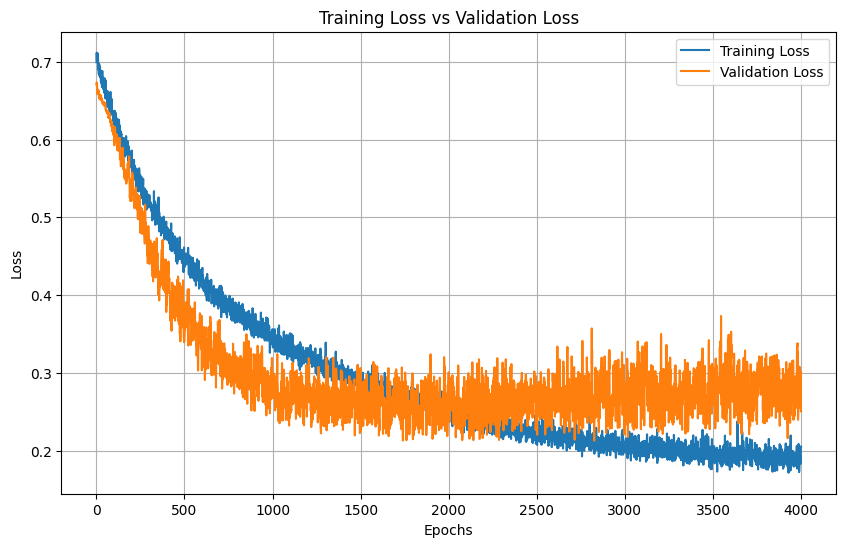

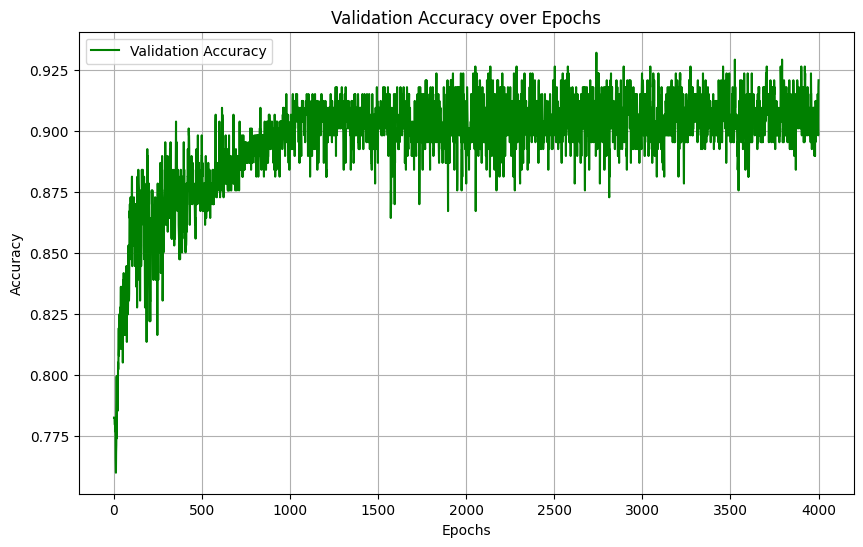

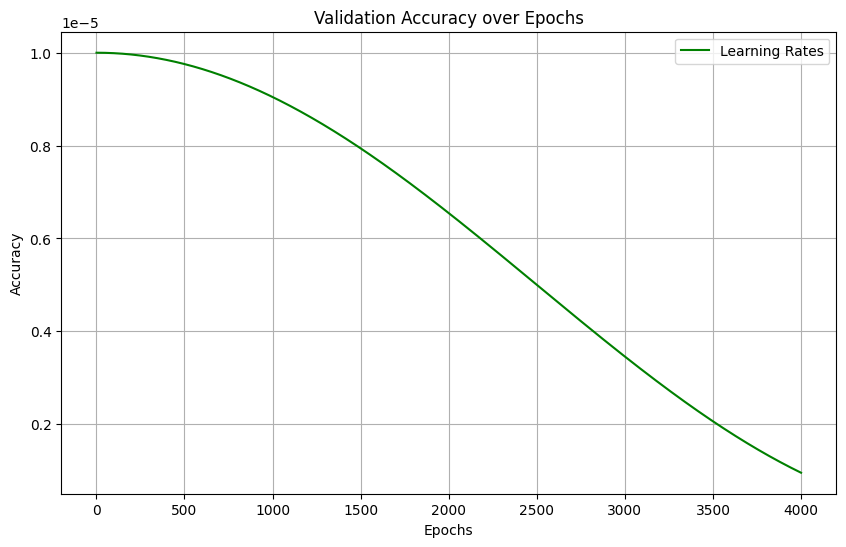

Model for bin 20 saved to GCNModels-5A_exp3/model_bin_20.pth
Training on bin 21/50
Bin 21, Epoch 1/4000, Train Loss: 0.6943, Validation Loss: 0.6902,  Accuracy: 0.7825, LR: 0.000010
Bin 21, Epoch 101/4000, Train Loss: 0.6374, Validation Loss: 0.6425,  Accuracy: 0.7684, LR: 0.000010
Bin 21, Epoch 201/4000, Train Loss: 0.5971, Validation Loss: 0.5772,  Accuracy: 0.8136, LR: 0.000010
Bin 21, Epoch 301/4000, Train Loss: 0.5496, Validation Loss: 0.4958,  Accuracy: 0.8531, LR: 0.000010
Bin 21, Epoch 401/4000, Train Loss: 0.5051, Validation Loss: 0.4476,  Accuracy: 0.8475, LR: 0.000010
Bin 21, Epoch 501/4000, Train Loss: 0.4693, Validation Loss: 0.4035,  Accuracy: 0.8475, LR: 0.000010
Bin 21, Epoch 601/4000, Train Loss: 0.4670, Validation Loss: 0.3619,  Accuracy: 0.8898, LR: 0.000010
Bin 21, Epoch 701/4000, Train Loss: 0.4228, Validation Loss: 0.3037,  Accuracy: 0.8955, LR: 0.000010
Bin 21, Epoch 801/4000, Train Loss: 0.3998, Validation Loss: 0.2945,  Accuracy: 0.9011, LR: 0.000009
Bin 21, Ep

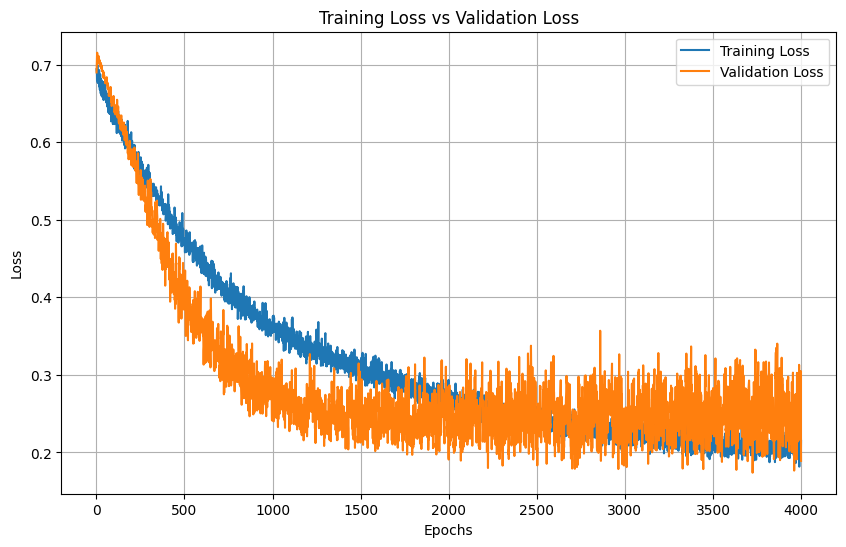

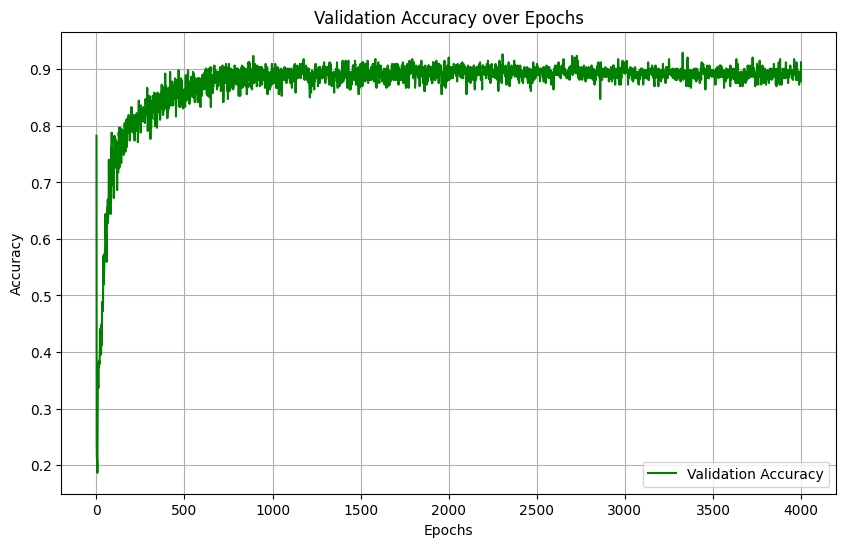

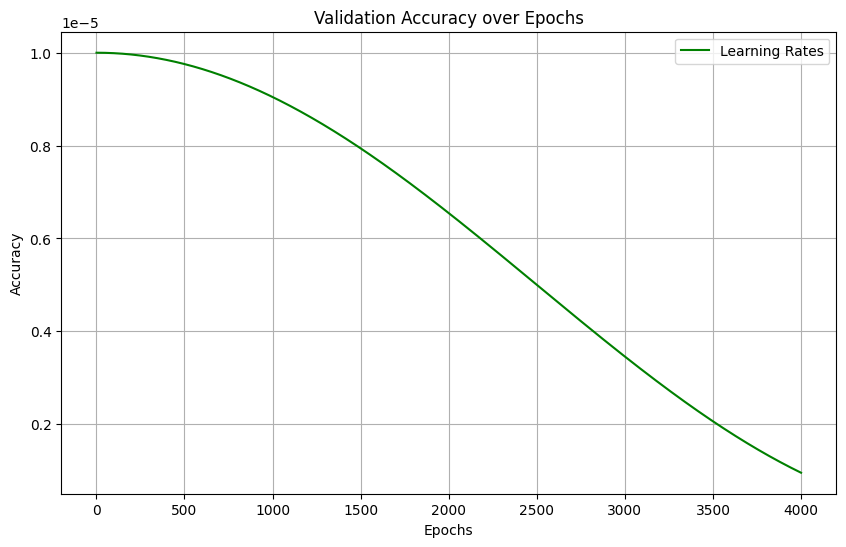

Model for bin 21 saved to GCNModels-5A_exp3/model_bin_21.pth
Training on bin 22/50
Bin 22, Epoch 1/4000, Train Loss: 0.7237, Validation Loss: 0.7031,  Accuracy: 0.2175, LR: 0.000010
Bin 22, Epoch 101/4000, Train Loss: 0.6455, Validation Loss: 0.6619,  Accuracy: 0.6412, LR: 0.000010
Bin 22, Epoch 201/4000, Train Loss: 0.6038, Validation Loss: 0.6274,  Accuracy: 0.6864, LR: 0.000010
Bin 22, Epoch 301/4000, Train Loss: 0.5434, Validation Loss: 0.5773,  Accuracy: 0.7401, LR: 0.000010
Bin 22, Epoch 401/4000, Train Loss: 0.4961, Validation Loss: 0.5171,  Accuracy: 0.8079, LR: 0.000010
Bin 22, Epoch 501/4000, Train Loss: 0.4811, Validation Loss: 0.4385,  Accuracy: 0.8531, LR: 0.000010
Bin 22, Epoch 601/4000, Train Loss: 0.4589, Validation Loss: 0.4106,  Accuracy: 0.8559, LR: 0.000010
Bin 22, Epoch 701/4000, Train Loss: 0.4277, Validation Loss: 0.4007,  Accuracy: 0.8588, LR: 0.000010
Bin 22, Epoch 801/4000, Train Loss: 0.3999, Validation Loss: 0.3635,  Accuracy: 0.8757, LR: 0.000009
Bin 22, Ep

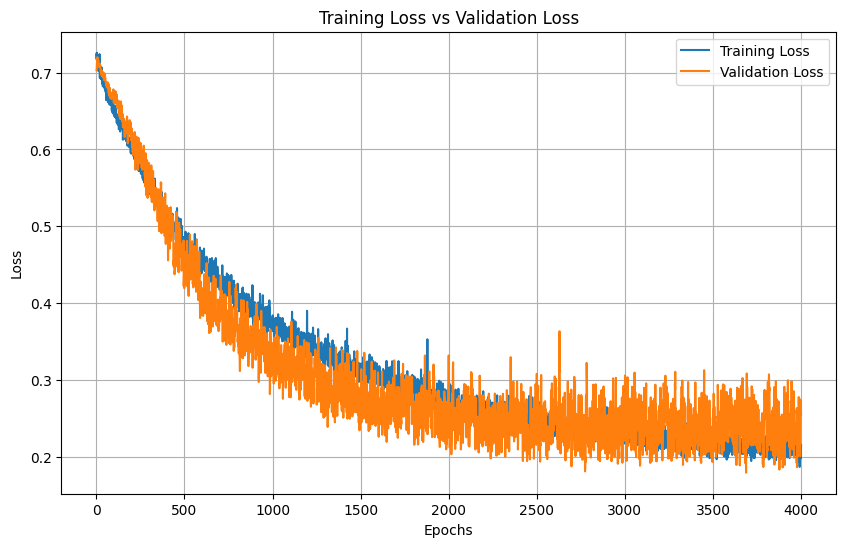

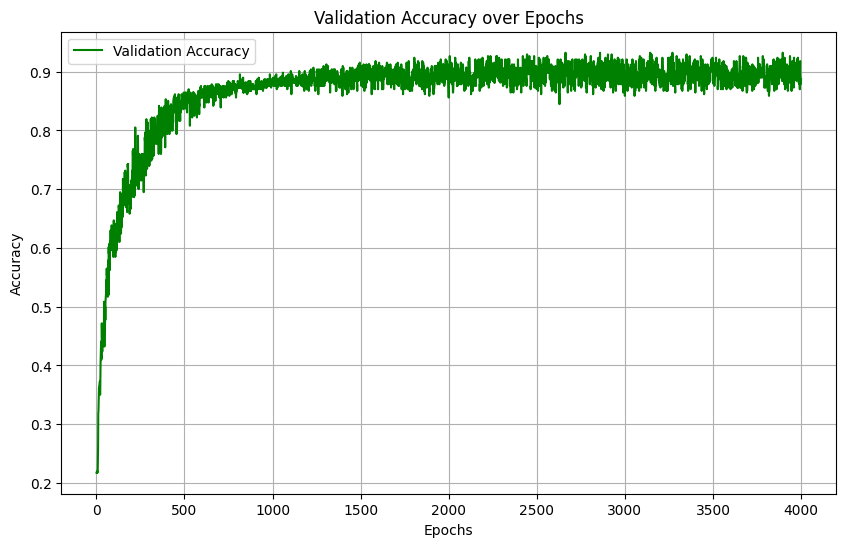

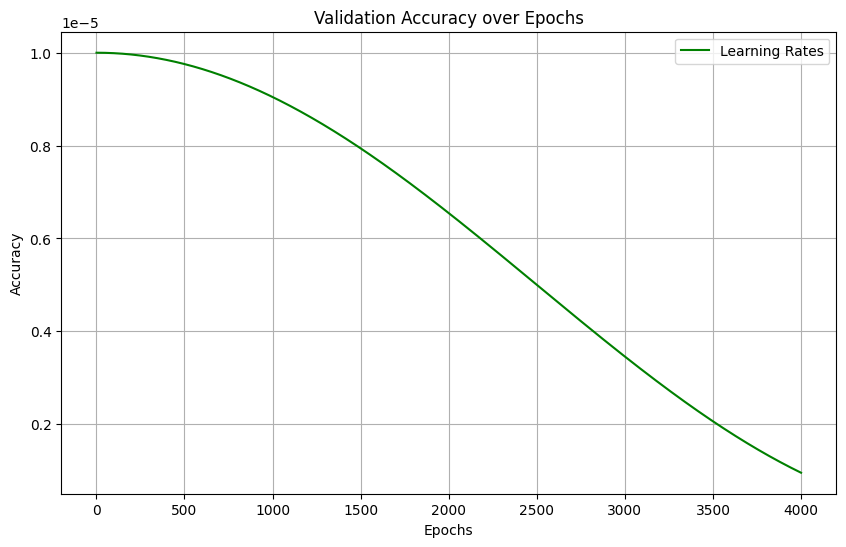

Model for bin 22 saved to GCNModels-5A_exp3/model_bin_22.pth
Training on bin 23/50
Bin 23, Epoch 1/4000, Train Loss: 0.6790, Validation Loss: 0.7191,  Accuracy: 0.2175, LR: 0.000010
Bin 23, Epoch 101/4000, Train Loss: 0.6361, Validation Loss: 0.6596,  Accuracy: 0.6921, LR: 0.000010
Bin 23, Epoch 201/4000, Train Loss: 0.5805, Validation Loss: 0.5877,  Accuracy: 0.7825, LR: 0.000010
Bin 23, Epoch 301/4000, Train Loss: 0.5398, Validation Loss: 0.4978,  Accuracy: 0.8672, LR: 0.000010
Bin 23, Epoch 401/4000, Train Loss: 0.5019, Validation Loss: 0.4552,  Accuracy: 0.8644, LR: 0.000010
Bin 23, Epoch 501/4000, Train Loss: 0.4733, Validation Loss: 0.3918,  Accuracy: 0.8870, LR: 0.000010
Bin 23, Epoch 601/4000, Train Loss: 0.4357, Validation Loss: 0.3734,  Accuracy: 0.8588, LR: 0.000010
Bin 23, Epoch 701/4000, Train Loss: 0.4106, Validation Loss: 0.3314,  Accuracy: 0.8842, LR: 0.000010
Bin 23, Epoch 801/4000, Train Loss: 0.3858, Validation Loss: 0.3050,  Accuracy: 0.8870, LR: 0.000009
Bin 23, Ep

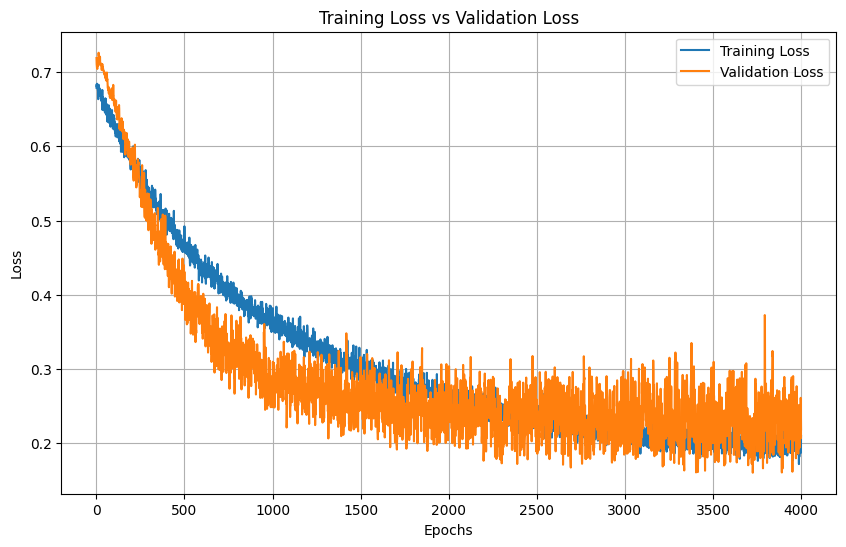

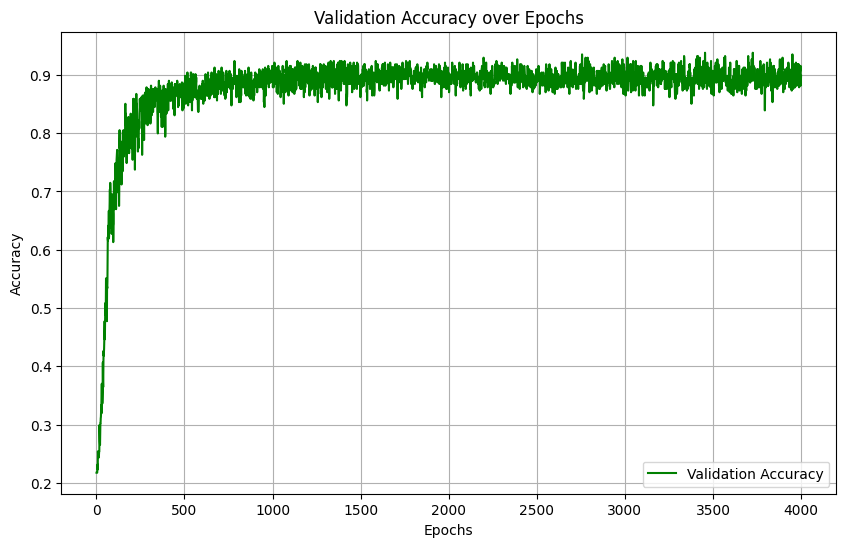

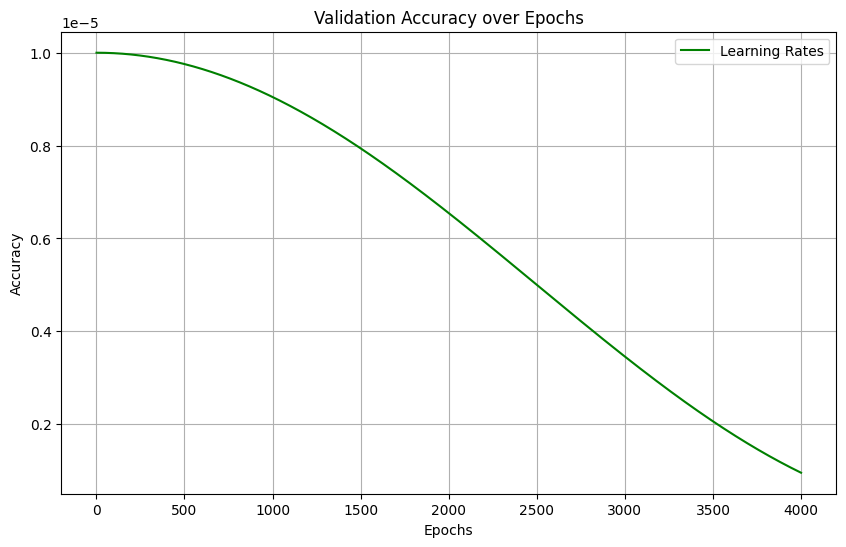

Model for bin 23 saved to GCNModels-5A_exp3/model_bin_23.pth
Training on bin 24/50
Bin 24, Epoch 1/4000, Train Loss: 0.7081, Validation Loss: 0.6850,  Accuracy: 0.7825, LR: 0.000010
Bin 24, Epoch 101/4000, Train Loss: 0.6280, Validation Loss: 0.6283,  Accuracy: 0.7768, LR: 0.000010
Bin 24, Epoch 201/4000, Train Loss: 0.5854, Validation Loss: 0.5737,  Accuracy: 0.8249, LR: 0.000010
Bin 24, Epoch 301/4000, Train Loss: 0.5519, Validation Loss: 0.5319,  Accuracy: 0.8136, LR: 0.000010
Bin 24, Epoch 401/4000, Train Loss: 0.4946, Validation Loss: 0.4903,  Accuracy: 0.8305, LR: 0.000010
Bin 24, Epoch 501/4000, Train Loss: 0.4574, Validation Loss: 0.4232,  Accuracy: 0.8588, LR: 0.000010
Bin 24, Epoch 601/4000, Train Loss: 0.4350, Validation Loss: 0.4047,  Accuracy: 0.8503, LR: 0.000010
Bin 24, Epoch 701/4000, Train Loss: 0.4140, Validation Loss: 0.3920,  Accuracy: 0.8616, LR: 0.000010
Bin 24, Epoch 801/4000, Train Loss: 0.3775, Validation Loss: 0.3072,  Accuracy: 0.8814, LR: 0.000009
Bin 24, Ep

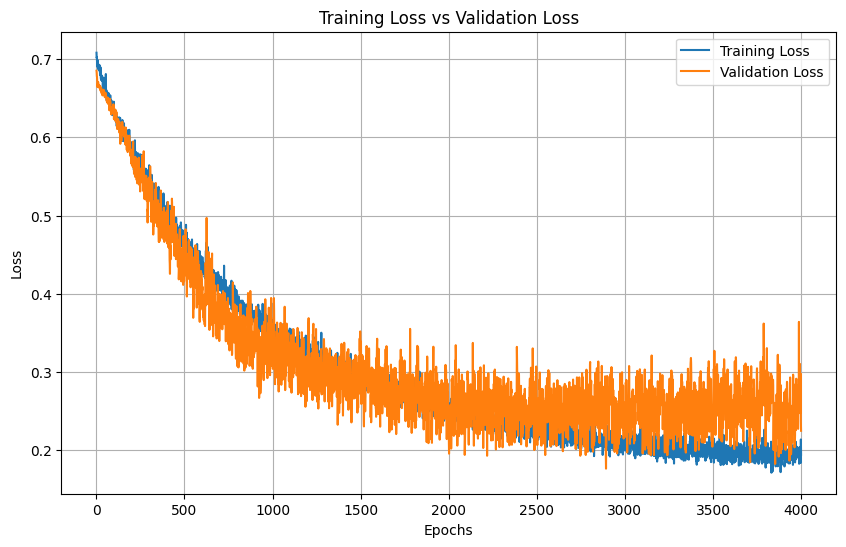

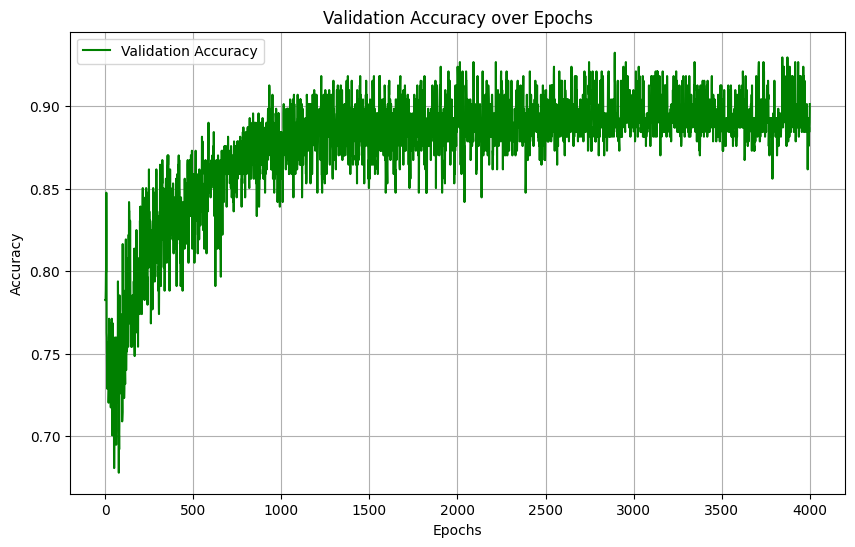

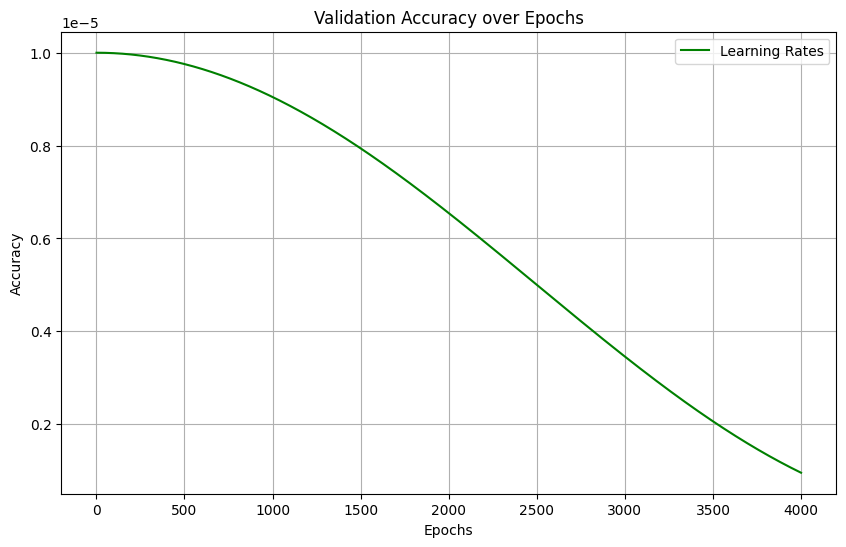

Model for bin 24 saved to GCNModels-5A_exp3/model_bin_24.pth
Training on bin 25/50
Bin 25, Epoch 1/4000, Train Loss: 0.6759, Validation Loss: 0.6813,  Accuracy: 0.7825, LR: 0.000010
Bin 25, Epoch 101/4000, Train Loss: 0.6289, Validation Loss: 0.6509,  Accuracy: 0.7260, LR: 0.000010
Bin 25, Epoch 201/4000, Train Loss: 0.5682, Validation Loss: 0.5491,  Accuracy: 0.8757, LR: 0.000010
Bin 25, Epoch 301/4000, Train Loss: 0.5207, Validation Loss: 0.5147,  Accuracy: 0.8588, LR: 0.000010
Bin 25, Epoch 401/4000, Train Loss: 0.4674, Validation Loss: 0.4370,  Accuracy: 0.8757, LR: 0.000010
Bin 25, Epoch 501/4000, Train Loss: 0.4450, Validation Loss: 0.4106,  Accuracy: 0.8588, LR: 0.000010
Bin 25, Epoch 601/4000, Train Loss: 0.4089, Validation Loss: 0.3367,  Accuracy: 0.9181, LR: 0.000010
Bin 25, Epoch 701/4000, Train Loss: 0.3809, Validation Loss: 0.3115,  Accuracy: 0.9181, LR: 0.000010
Bin 25, Epoch 801/4000, Train Loss: 0.3456, Validation Loss: 0.2569,  Accuracy: 0.9294, LR: 0.000009
Bin 25, Ep

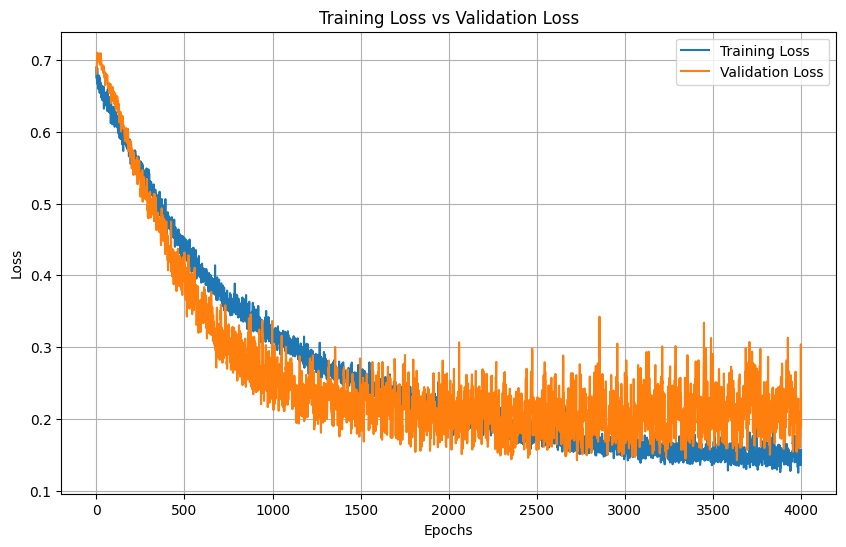

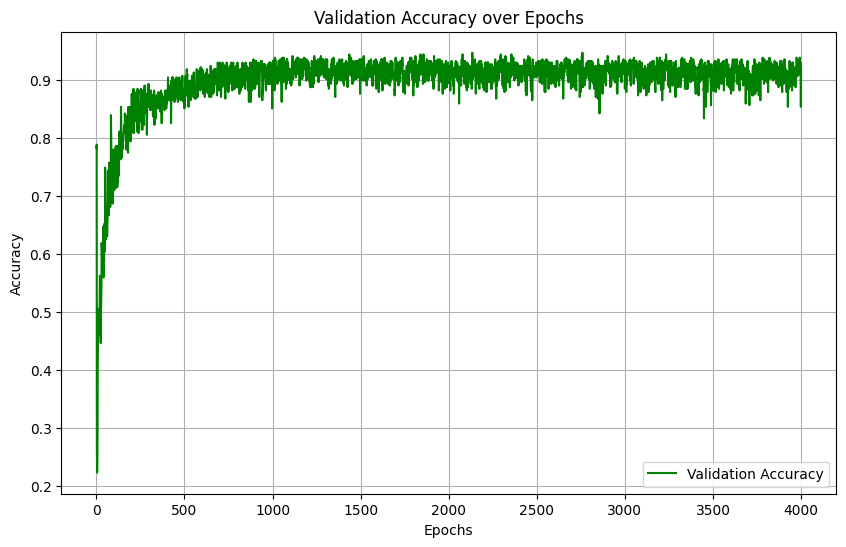

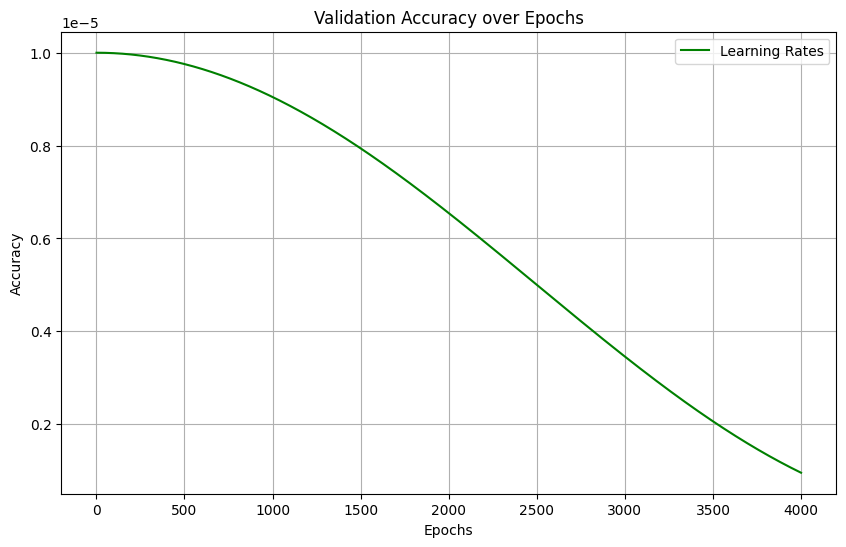

Model for bin 25 saved to GCNModels-5A_exp3/model_bin_25.pth
Training on bin 26/50
Bin 26, Epoch 1/4000, Train Loss: 0.7034, Validation Loss: 0.6795,  Accuracy: 0.7825, LR: 0.000010
Bin 26, Epoch 101/4000, Train Loss: 0.6397, Validation Loss: 0.5804,  Accuracy: 0.8785, LR: 0.000010
Bin 26, Epoch 201/4000, Train Loss: 0.5857, Validation Loss: 0.5052,  Accuracy: 0.8588, LR: 0.000010
Bin 26, Epoch 301/4000, Train Loss: 0.5103, Validation Loss: 0.4336,  Accuracy: 0.8729, LR: 0.000010
Bin 26, Epoch 401/4000, Train Loss: 0.5129, Validation Loss: 0.4078,  Accuracy: 0.8701, LR: 0.000010
Bin 26, Epoch 501/4000, Train Loss: 0.4650, Validation Loss: 0.3726,  Accuracy: 0.8757, LR: 0.000010
Bin 26, Epoch 601/4000, Train Loss: 0.4590, Validation Loss: 0.3823,  Accuracy: 0.8503, LR: 0.000010
Bin 26, Epoch 701/4000, Train Loss: 0.4130, Validation Loss: 0.3741,  Accuracy: 0.8418, LR: 0.000010
Bin 26, Epoch 801/4000, Train Loss: 0.4006, Validation Loss: 0.3588,  Accuracy: 0.8531, LR: 0.000009
Bin 26, Ep

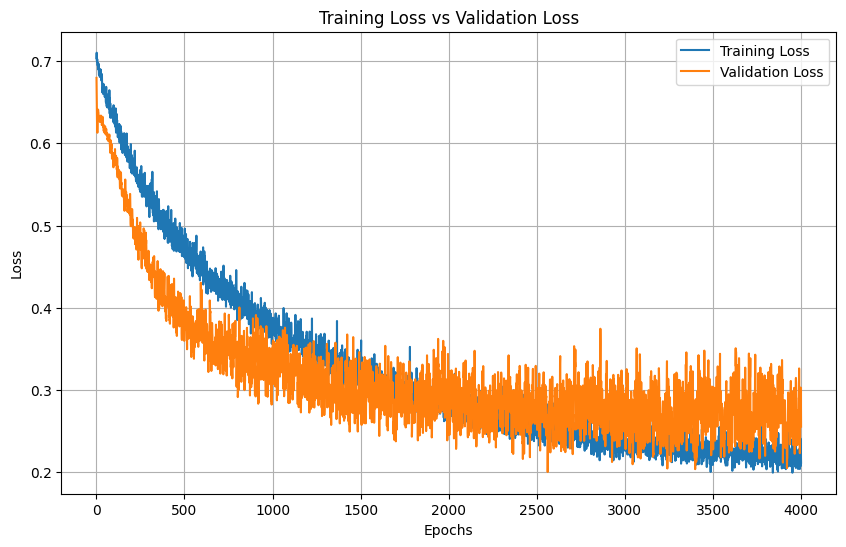

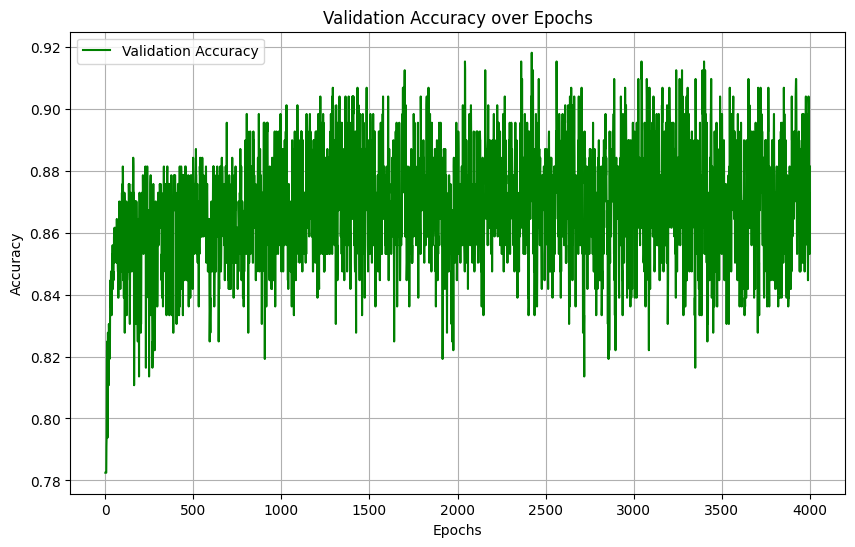

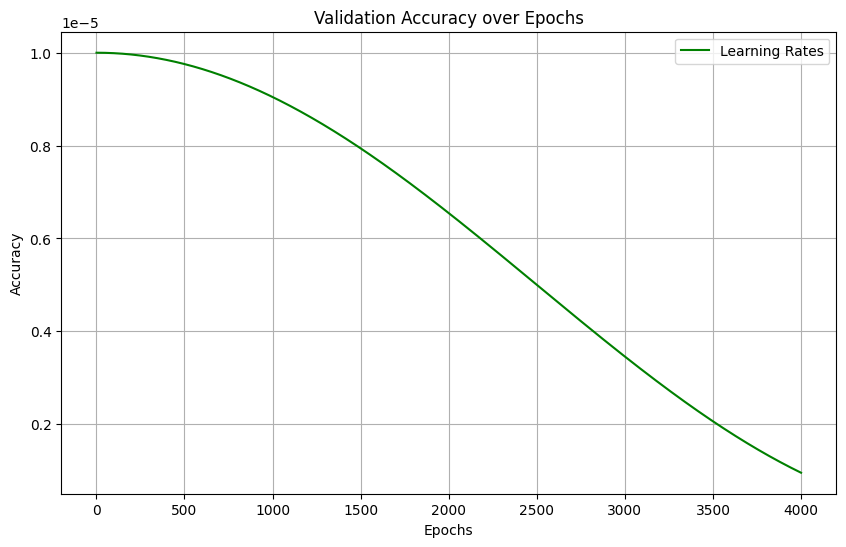

Model for bin 26 saved to GCNModels-5A_exp3/model_bin_26.pth
Training on bin 27/50
Bin 27, Epoch 1/4000, Train Loss: 0.7205, Validation Loss: 0.6777,  Accuracy: 0.7825, LR: 0.000010
Bin 27, Epoch 101/4000, Train Loss: 0.6321, Validation Loss: 0.6355,  Accuracy: 0.8051, LR: 0.000010
Bin 27, Epoch 201/4000, Train Loss: 0.5858, Validation Loss: 0.5786,  Accuracy: 0.8446, LR: 0.000010
Bin 27, Epoch 301/4000, Train Loss: 0.5427, Validation Loss: 0.5394,  Accuracy: 0.8277, LR: 0.000010
Bin 27, Epoch 401/4000, Train Loss: 0.5127, Validation Loss: 0.4696,  Accuracy: 0.8588, LR: 0.000010
Bin 27, Epoch 501/4000, Train Loss: 0.4769, Validation Loss: 0.4462,  Accuracy: 0.8390, LR: 0.000010
Bin 27, Epoch 601/4000, Train Loss: 0.4542, Validation Loss: 0.3957,  Accuracy: 0.8588, LR: 0.000010
Bin 27, Epoch 701/4000, Train Loss: 0.4347, Validation Loss: 0.3754,  Accuracy: 0.8701, LR: 0.000010
Bin 27, Epoch 801/4000, Train Loss: 0.3780, Validation Loss: 0.3358,  Accuracy: 0.8870, LR: 0.000009
Bin 27, Ep

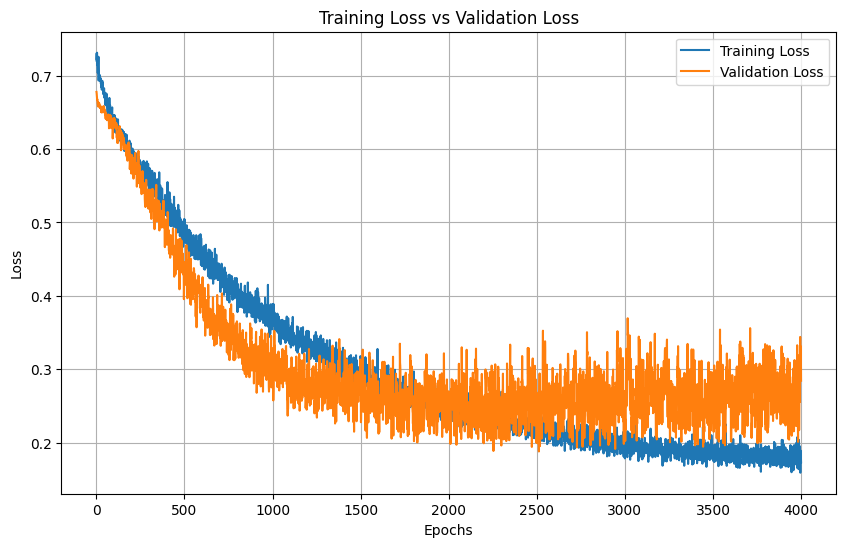

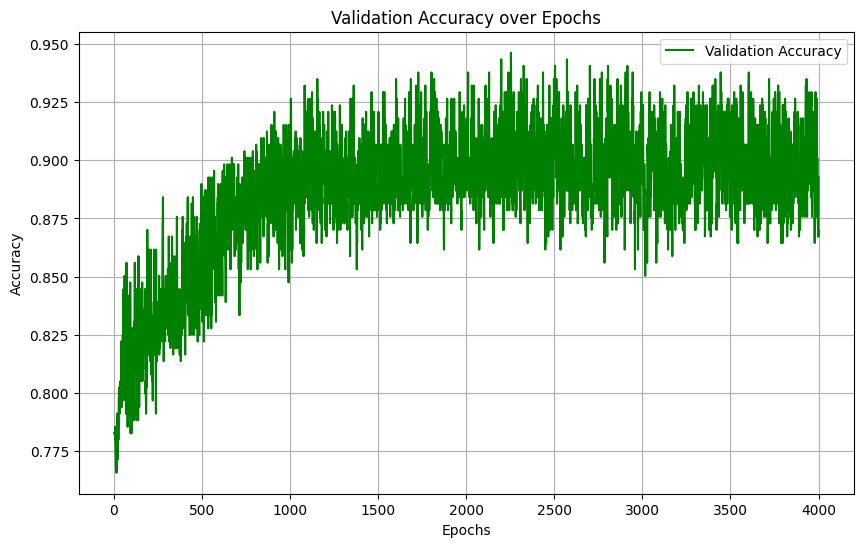

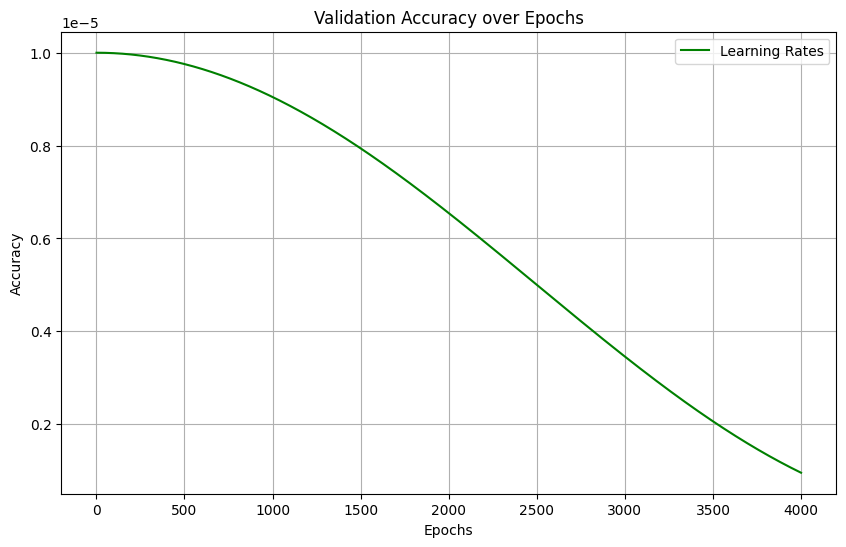

Model for bin 27 saved to GCNModels-5A_exp3/model_bin_27.pth
Training on bin 28/50
Bin 28, Epoch 1/4000, Train Loss: 0.7031, Validation Loss: 0.6587,  Accuracy: 0.7825, LR: 0.000010
Bin 28, Epoch 101/4000, Train Loss: 0.6388, Validation Loss: 0.6140,  Accuracy: 0.8051, LR: 0.000010
Bin 28, Epoch 201/4000, Train Loss: 0.5908, Validation Loss: 0.5460,  Accuracy: 0.8220, LR: 0.000010
Bin 28, Epoch 301/4000, Train Loss: 0.5582, Validation Loss: 0.4804,  Accuracy: 0.8475, LR: 0.000010
Bin 28, Epoch 401/4000, Train Loss: 0.5047, Validation Loss: 0.4175,  Accuracy: 0.8757, LR: 0.000010
Bin 28, Epoch 501/4000, Train Loss: 0.4853, Validation Loss: 0.3759,  Accuracy: 0.8814, LR: 0.000010
Bin 28, Epoch 601/4000, Train Loss: 0.4710, Validation Loss: 0.3599,  Accuracy: 0.8672, LR: 0.000010
Bin 28, Epoch 701/4000, Train Loss: 0.4395, Validation Loss: 0.3388,  Accuracy: 0.8814, LR: 0.000010
Bin 28, Epoch 801/4000, Train Loss: 0.4032, Validation Loss: 0.2975,  Accuracy: 0.8870, LR: 0.000009
Bin 28, Ep

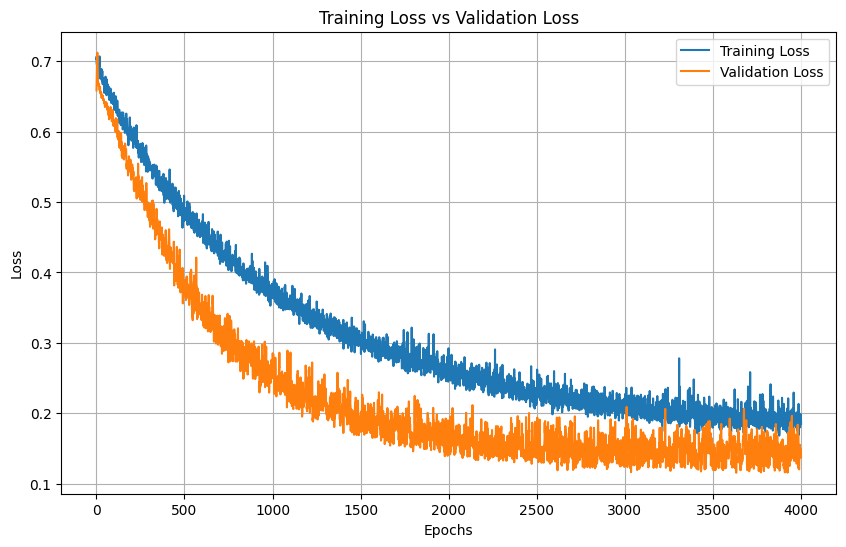

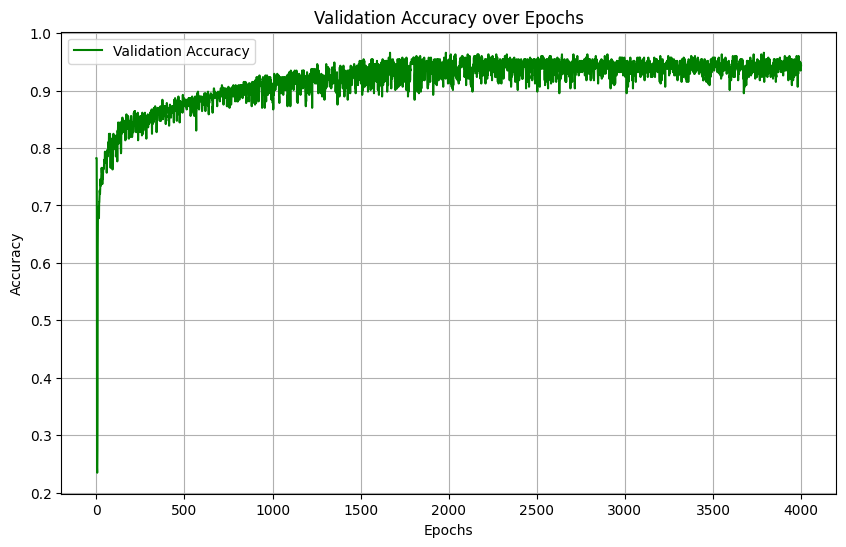

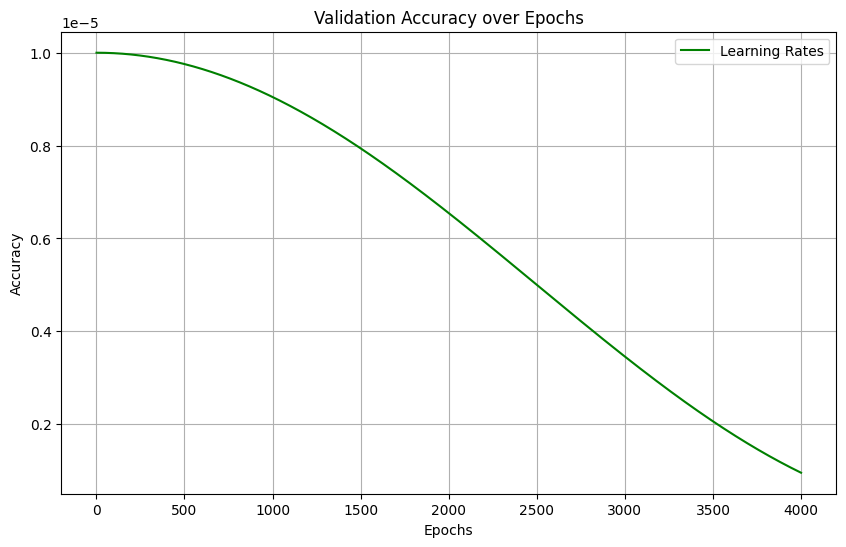

Model for bin 28 saved to GCNModels-5A_exp3/model_bin_28.pth
Training on bin 29/50
Bin 29, Epoch 1/4000, Train Loss: 0.7214, Validation Loss: 0.6944,  Accuracy: 0.2203, LR: 0.000010
Bin 29, Epoch 101/4000, Train Loss: 0.6420, Validation Loss: 0.5963,  Accuracy: 0.8729, LR: 0.000010
Bin 29, Epoch 201/4000, Train Loss: 0.5871, Validation Loss: 0.5237,  Accuracy: 0.8757, LR: 0.000010
Bin 29, Epoch 301/4000, Train Loss: 0.5417, Validation Loss: 0.4644,  Accuracy: 0.8644, LR: 0.000010
Bin 29, Epoch 401/4000, Train Loss: 0.5077, Validation Loss: 0.4280,  Accuracy: 0.8644, LR: 0.000010
Bin 29, Epoch 501/4000, Train Loss: 0.4642, Validation Loss: 0.3908,  Accuracy: 0.8559, LR: 0.000010
Bin 29, Epoch 601/4000, Train Loss: 0.4467, Validation Loss: 0.3072,  Accuracy: 0.9068, LR: 0.000010
Bin 29, Epoch 701/4000, Train Loss: 0.4162, Validation Loss: 0.3018,  Accuracy: 0.9040, LR: 0.000010
Bin 29, Epoch 801/4000, Train Loss: 0.4148, Validation Loss: 0.2892,  Accuracy: 0.9040, LR: 0.000009
Bin 29, Ep

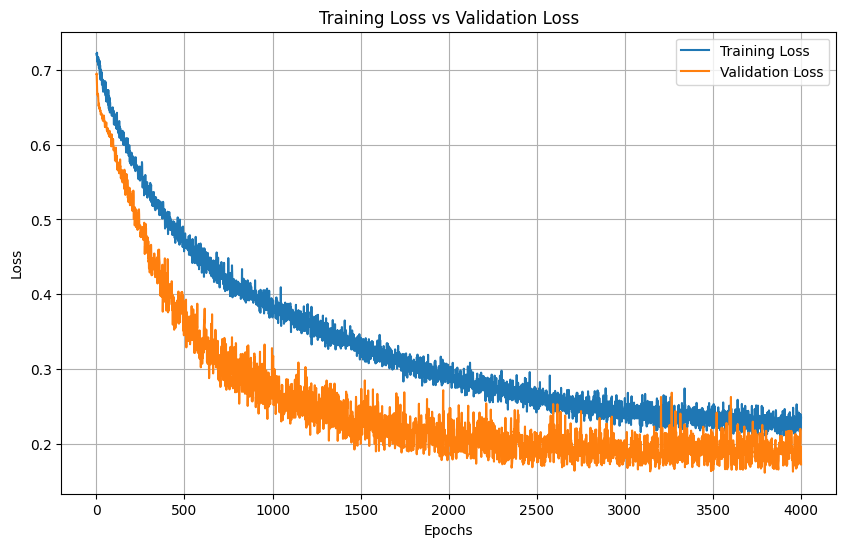

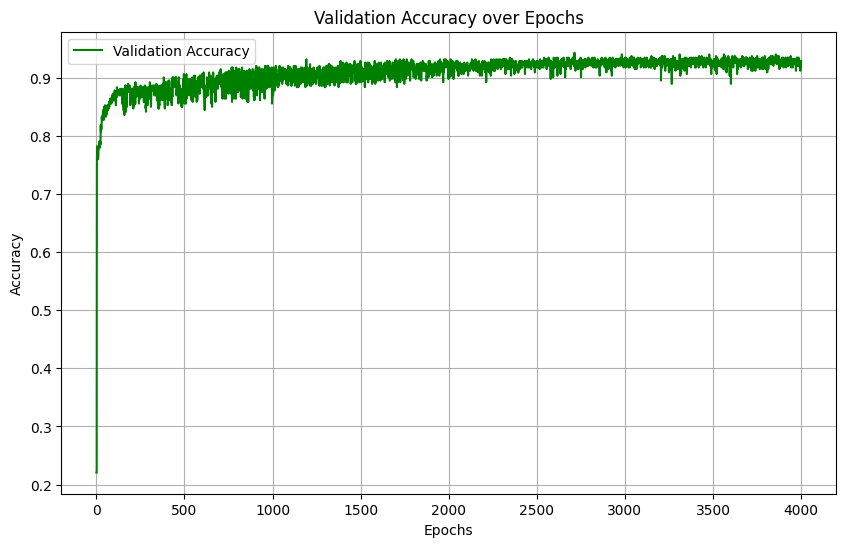

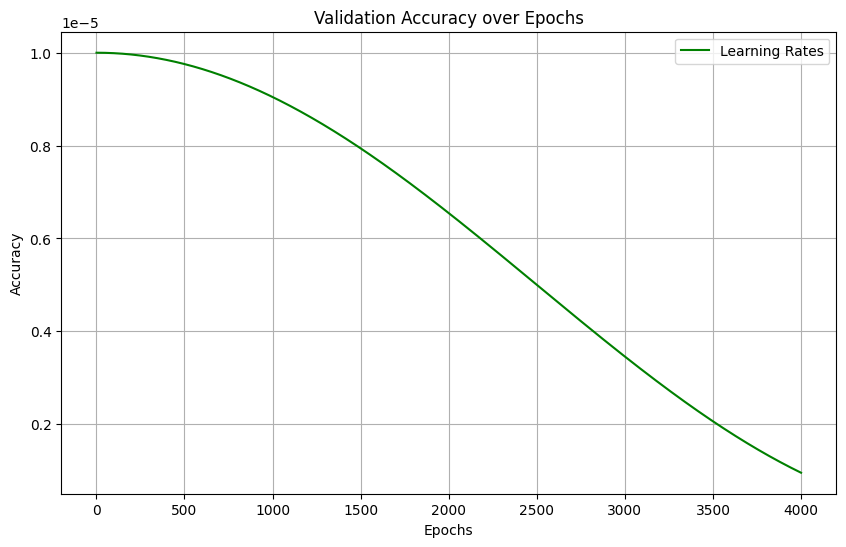

Model for bin 29 saved to GCNModels-5A_exp3/model_bin_29.pth
Training on bin 30/50
Bin 30, Epoch 1/4000, Train Loss: 0.6986, Validation Loss: 0.6753,  Accuracy: 0.7825, LR: 0.000010
Bin 30, Epoch 101/4000, Train Loss: 0.6463, Validation Loss: 0.6442,  Accuracy: 0.7768, LR: 0.000010
Bin 30, Epoch 201/4000, Train Loss: 0.5952, Validation Loss: 0.6009,  Accuracy: 0.7966, LR: 0.000010
Bin 30, Epoch 301/4000, Train Loss: 0.5544, Validation Loss: 0.5553,  Accuracy: 0.7966, LR: 0.000010
Bin 30, Epoch 401/4000, Train Loss: 0.5471, Validation Loss: 0.4925,  Accuracy: 0.8164, LR: 0.000010
Bin 30, Epoch 501/4000, Train Loss: 0.4900, Validation Loss: 0.4254,  Accuracy: 0.8503, LR: 0.000010
Bin 30, Epoch 601/4000, Train Loss: 0.4630, Validation Loss: 0.4262,  Accuracy: 0.8305, LR: 0.000010
Bin 30, Epoch 701/4000, Train Loss: 0.4325, Validation Loss: 0.4071,  Accuracy: 0.8305, LR: 0.000010
Bin 30, Epoch 801/4000, Train Loss: 0.4302, Validation Loss: 0.3849,  Accuracy: 0.8475, LR: 0.000009
Bin 30, Ep

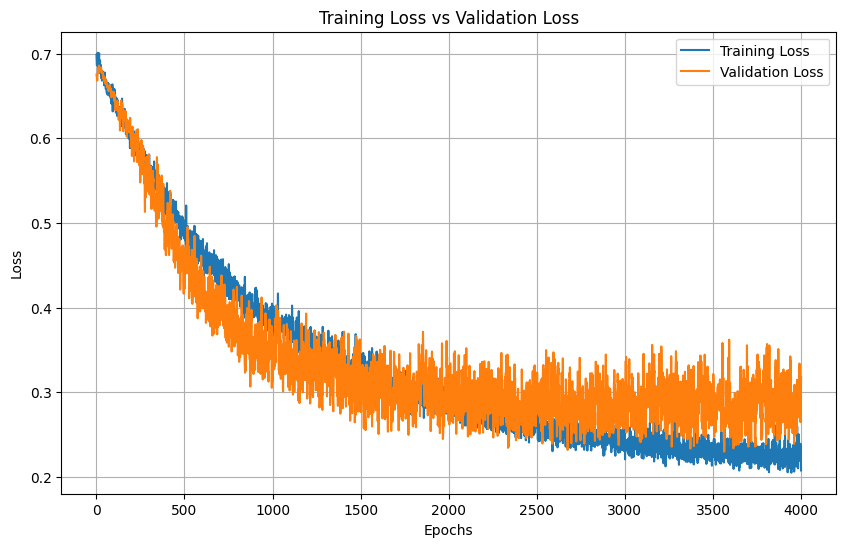

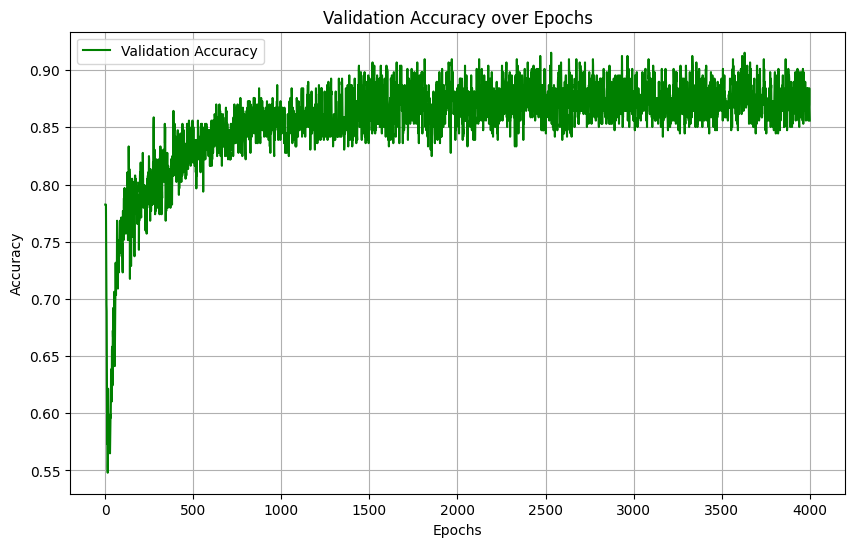

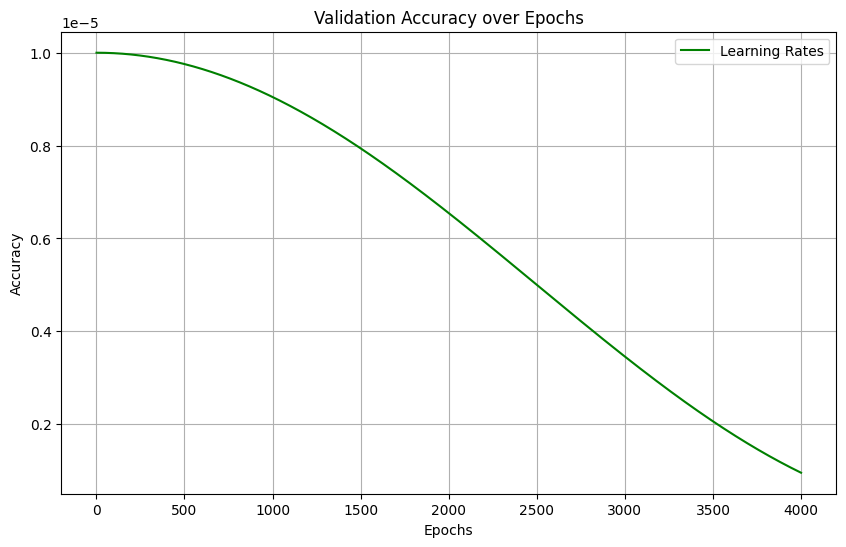

Model for bin 30 saved to GCNModels-5A_exp3/model_bin_30.pth
Training on bin 31/50
Bin 31, Epoch 1/4000, Train Loss: 0.6962, Validation Loss: 0.7011,  Accuracy: 0.2175, LR: 0.000010
Bin 31, Epoch 101/4000, Train Loss: 0.6308, Validation Loss: 0.6445,  Accuracy: 0.7373, LR: 0.000010
Bin 31, Epoch 201/4000, Train Loss: 0.5893, Validation Loss: 0.5870,  Accuracy: 0.7910, LR: 0.000010
Bin 31, Epoch 301/4000, Train Loss: 0.5322, Validation Loss: 0.5013,  Accuracy: 0.8644, LR: 0.000010
Bin 31, Epoch 401/4000, Train Loss: 0.5141, Validation Loss: 0.4398,  Accuracy: 0.8644, LR: 0.000010
Bin 31, Epoch 501/4000, Train Loss: 0.4821, Validation Loss: 0.4082,  Accuracy: 0.8559, LR: 0.000010
Bin 31, Epoch 601/4000, Train Loss: 0.4581, Validation Loss: 0.3420,  Accuracy: 0.9040, LR: 0.000010
Bin 31, Epoch 701/4000, Train Loss: 0.4136, Validation Loss: 0.3557,  Accuracy: 0.8842, LR: 0.000010
Bin 31, Epoch 801/4000, Train Loss: 0.4094, Validation Loss: 0.3230,  Accuracy: 0.8955, LR: 0.000009
Bin 31, Ep

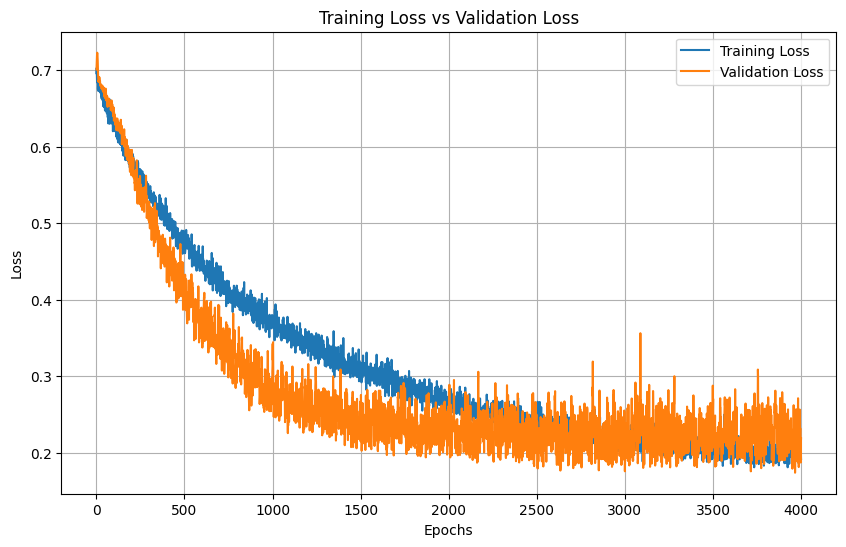

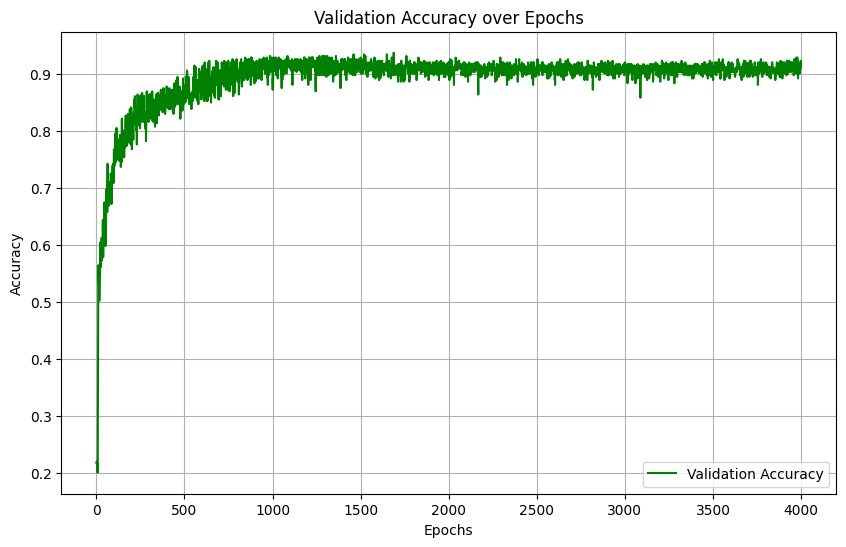

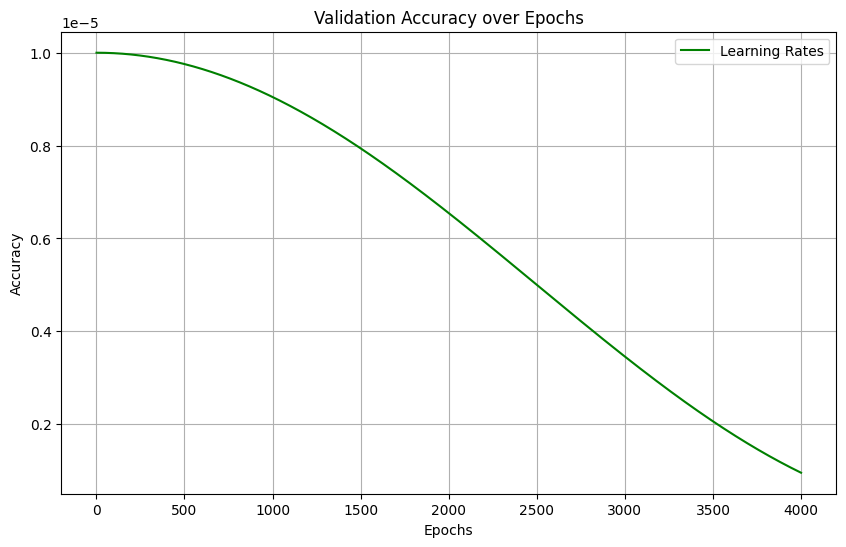

Model for bin 31 saved to GCNModels-5A_exp3/model_bin_31.pth
Training on bin 32/50
Bin 32, Epoch 1/4000, Train Loss: 0.6840, Validation Loss: 0.6978,  Accuracy: 0.2175, LR: 0.000010
Bin 32, Epoch 101/4000, Train Loss: 0.6196, Validation Loss: 0.6315,  Accuracy: 0.7458, LR: 0.000010
Bin 32, Epoch 201/4000, Train Loss: 0.5763, Validation Loss: 0.5552,  Accuracy: 0.8531, LR: 0.000010
Bin 32, Epoch 301/4000, Train Loss: 0.5304, Validation Loss: 0.4887,  Accuracy: 0.8701, LR: 0.000010
Bin 32, Epoch 401/4000, Train Loss: 0.4699, Validation Loss: 0.5197,  Accuracy: 0.7994, LR: 0.000010
Bin 32, Epoch 501/4000, Train Loss: 0.4507, Validation Loss: 0.4265,  Accuracy: 0.8672, LR: 0.000010
Bin 32, Epoch 601/4000, Train Loss: 0.4053, Validation Loss: 0.3599,  Accuracy: 0.8757, LR: 0.000010
Bin 32, Epoch 701/4000, Train Loss: 0.3755, Validation Loss: 0.3123,  Accuracy: 0.8955, LR: 0.000010
Bin 32, Epoch 801/4000, Train Loss: 0.3700, Validation Loss: 0.3288,  Accuracy: 0.8701, LR: 0.000009
Bin 32, Ep

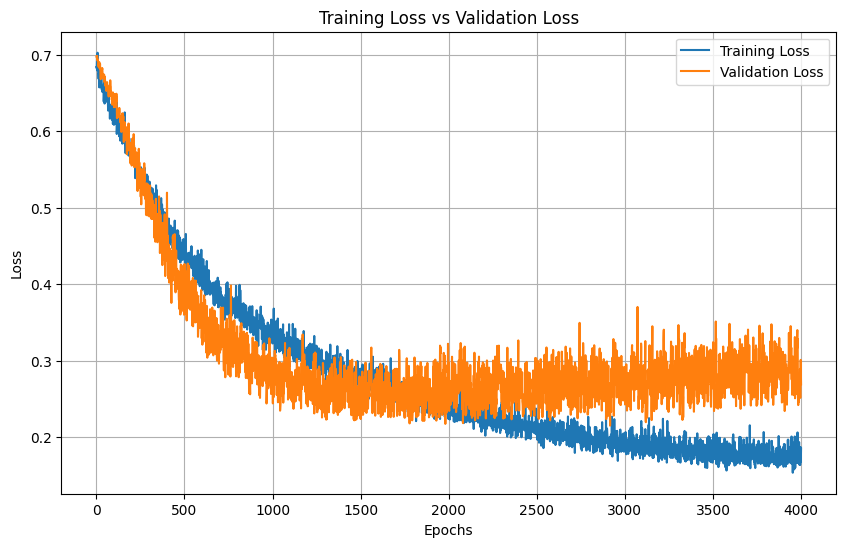

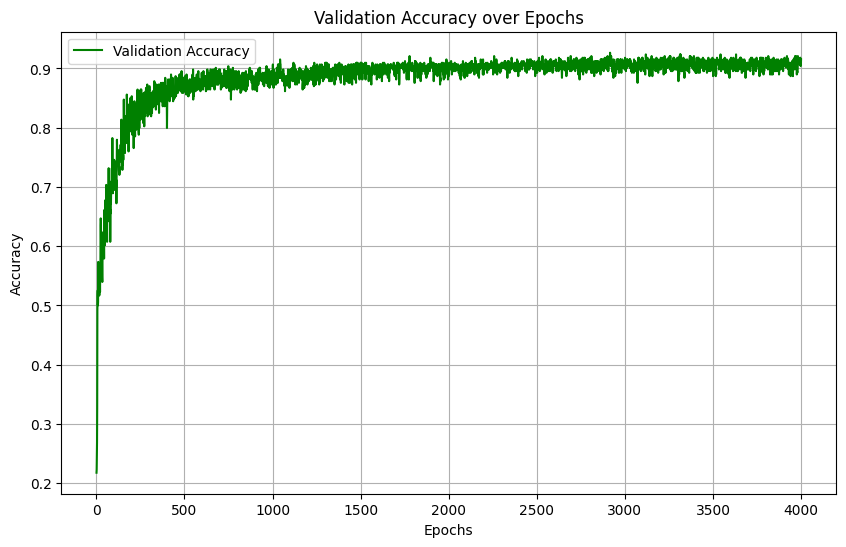

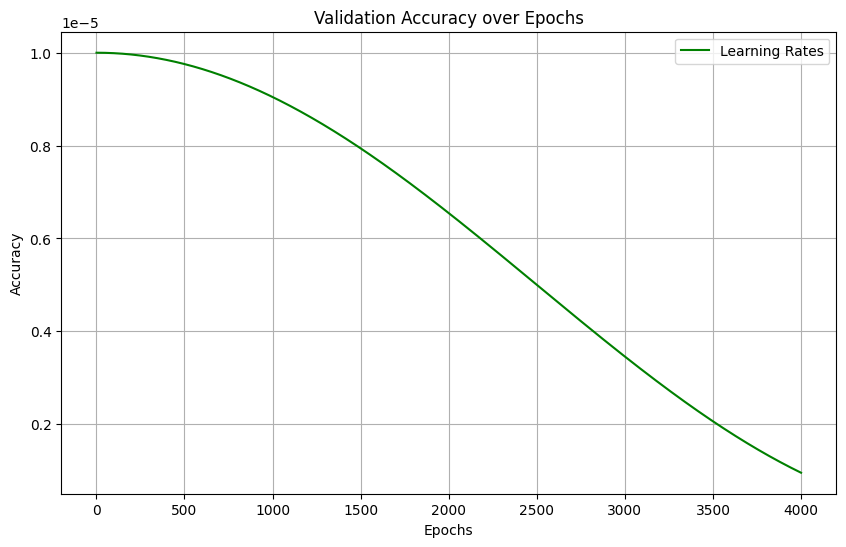

Model for bin 32 saved to GCNModels-5A_exp3/model_bin_32.pth
Training on bin 33/50
Bin 33, Epoch 1/4000, Train Loss: 0.7348, Validation Loss: 0.6670,  Accuracy: 0.7825, LR: 0.000010
Bin 33, Epoch 101/4000, Train Loss: 0.6407, Validation Loss: 0.6035,  Accuracy: 0.8305, LR: 0.000010
Bin 33, Epoch 201/4000, Train Loss: 0.5968, Validation Loss: 0.5271,  Accuracy: 0.8446, LR: 0.000010
Bin 33, Epoch 301/4000, Train Loss: 0.5245, Validation Loss: 0.4751,  Accuracy: 0.8249, LR: 0.000010
Bin 33, Epoch 401/4000, Train Loss: 0.4952, Validation Loss: 0.4015,  Accuracy: 0.8475, LR: 0.000010
Bin 33, Epoch 501/4000, Train Loss: 0.4494, Validation Loss: 0.3760,  Accuracy: 0.8390, LR: 0.000010
Bin 33, Epoch 601/4000, Train Loss: 0.4329, Validation Loss: 0.3399,  Accuracy: 0.8588, LR: 0.000010
Bin 33, Epoch 701/4000, Train Loss: 0.4001, Validation Loss: 0.3140,  Accuracy: 0.8701, LR: 0.000010
Bin 33, Epoch 801/4000, Train Loss: 0.3689, Validation Loss: 0.2781,  Accuracy: 0.8785, LR: 0.000009
Bin 33, Ep

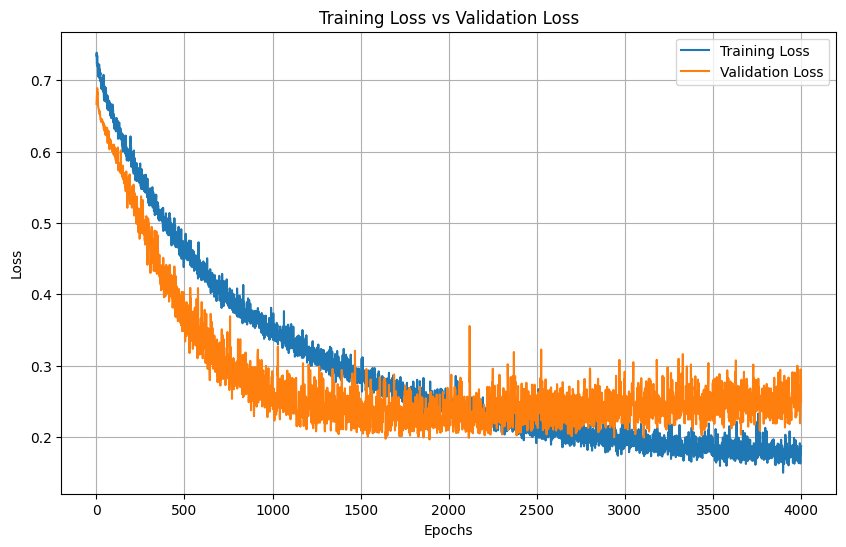

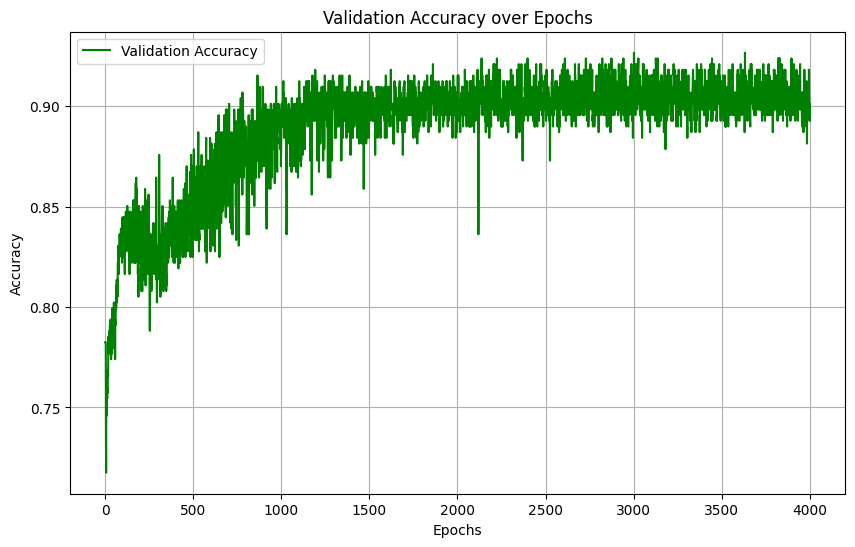

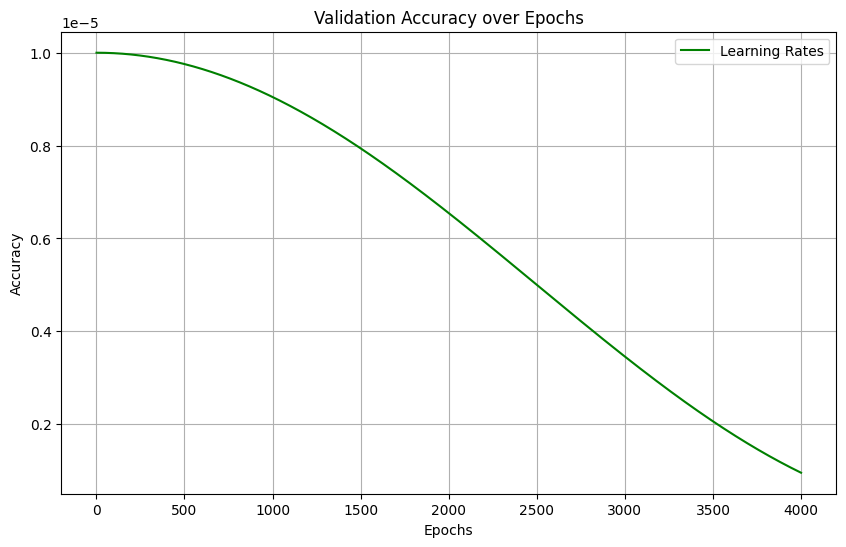

Model for bin 33 saved to GCNModels-5A_exp3/model_bin_33.pth
Training on bin 34/50
Bin 34, Epoch 1/4000, Train Loss: 0.7245, Validation Loss: 0.7312,  Accuracy: 0.2175, LR: 0.000010
Bin 34, Epoch 101/4000, Train Loss: 0.6445, Validation Loss: 0.6673,  Accuracy: 0.6751, LR: 0.000010
Bin 34, Epoch 201/4000, Train Loss: 0.5789, Validation Loss: 0.5859,  Accuracy: 0.8305, LR: 0.000010
Bin 34, Epoch 301/4000, Train Loss: 0.5413, Validation Loss: 0.4885,  Accuracy: 0.8729, LR: 0.000010
Bin 34, Epoch 401/4000, Train Loss: 0.4797, Validation Loss: 0.4346,  Accuracy: 0.8870, LR: 0.000010
Bin 34, Epoch 501/4000, Train Loss: 0.4463, Validation Loss: 0.3973,  Accuracy: 0.8814, LR: 0.000010
Bin 34, Epoch 601/4000, Train Loss: 0.4311, Validation Loss: 0.3789,  Accuracy: 0.8757, LR: 0.000010
Bin 34, Epoch 701/4000, Train Loss: 0.4045, Validation Loss: 0.3399,  Accuracy: 0.8927, LR: 0.000010
Bin 34, Epoch 801/4000, Train Loss: 0.3725, Validation Loss: 0.3513,  Accuracy: 0.8898, LR: 0.000009
Bin 34, Ep

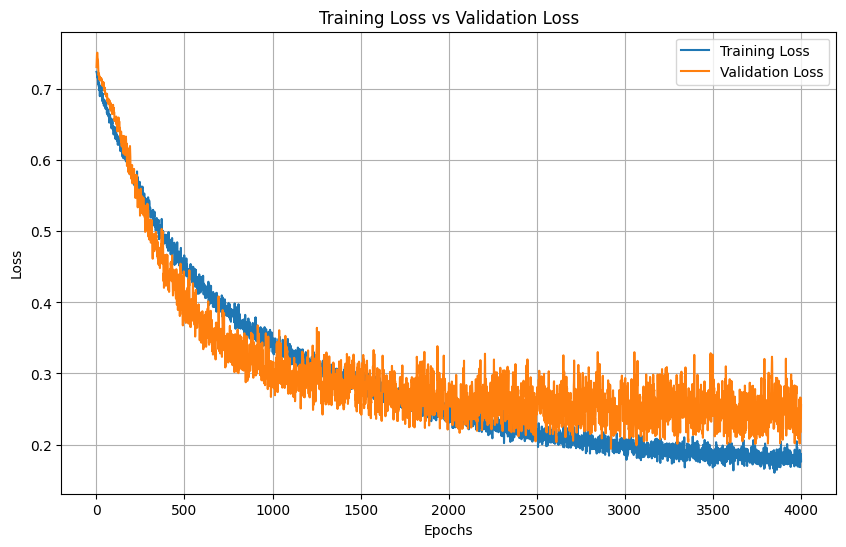

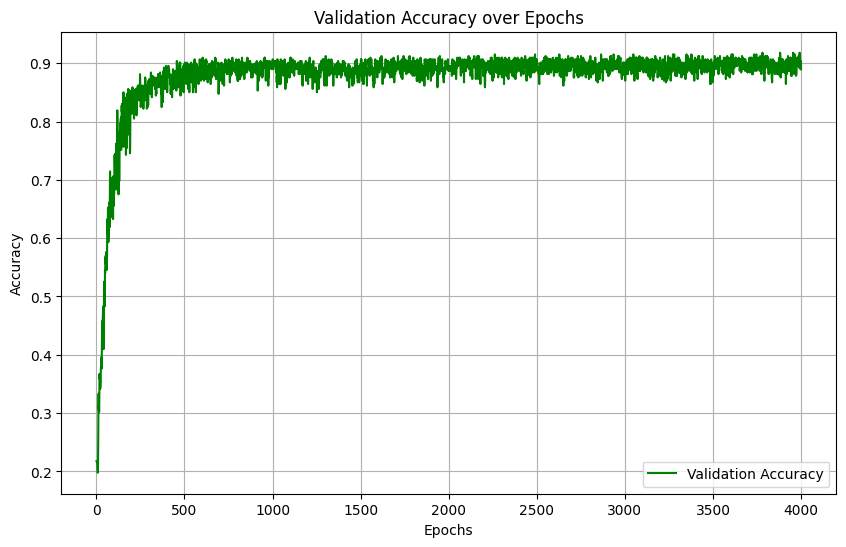

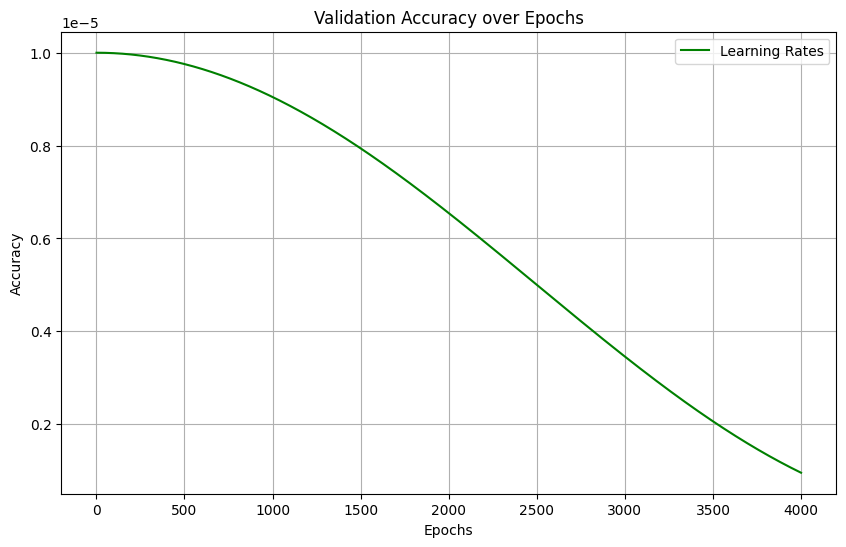

Model for bin 34 saved to GCNModels-5A_exp3/model_bin_34.pth
Training on bin 35/50
Bin 35, Epoch 1/4000, Train Loss: 0.7073, Validation Loss: 0.7139,  Accuracy: 0.2175, LR: 0.000010
Bin 35, Epoch 101/4000, Train Loss: 0.6345, Validation Loss: 0.6280,  Accuracy: 0.7514, LR: 0.000010
Bin 35, Epoch 201/4000, Train Loss: 0.5898, Validation Loss: 0.5657,  Accuracy: 0.8136, LR: 0.000010
Bin 35, Epoch 301/4000, Train Loss: 0.5376, Validation Loss: 0.5154,  Accuracy: 0.8107, LR: 0.000010
Bin 35, Epoch 401/4000, Train Loss: 0.5062, Validation Loss: 0.4544,  Accuracy: 0.8418, LR: 0.000010
Bin 35, Epoch 501/4000, Train Loss: 0.4751, Validation Loss: 0.4060,  Accuracy: 0.8588, LR: 0.000010
Bin 35, Epoch 601/4000, Train Loss: 0.4547, Validation Loss: 0.3678,  Accuracy: 0.8588, LR: 0.000010
Bin 35, Epoch 701/4000, Train Loss: 0.4241, Validation Loss: 0.3437,  Accuracy: 0.8644, LR: 0.000010
Bin 35, Epoch 801/4000, Train Loss: 0.4116, Validation Loss: 0.3355,  Accuracy: 0.8785, LR: 0.000009
Bin 35, Ep

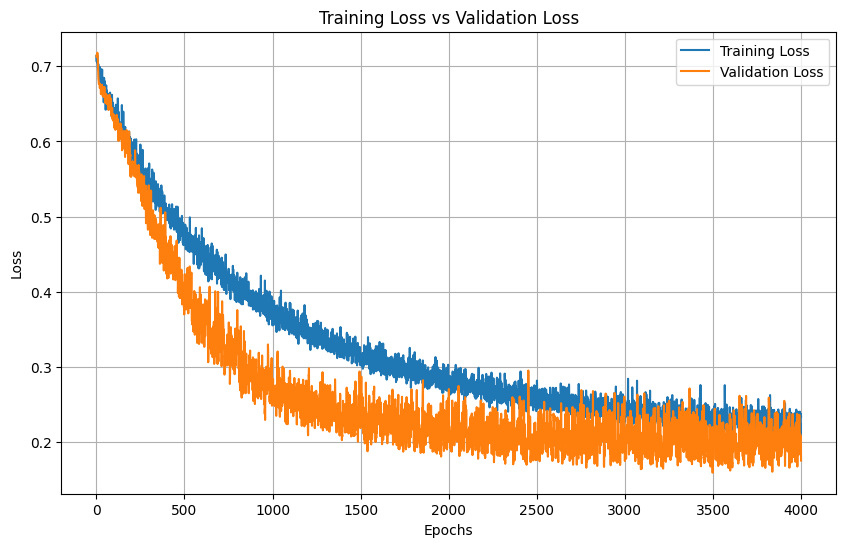

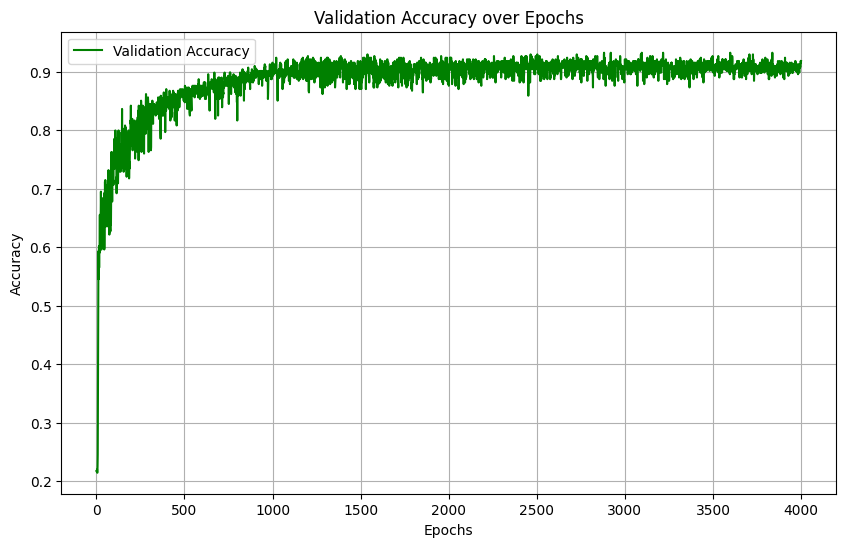

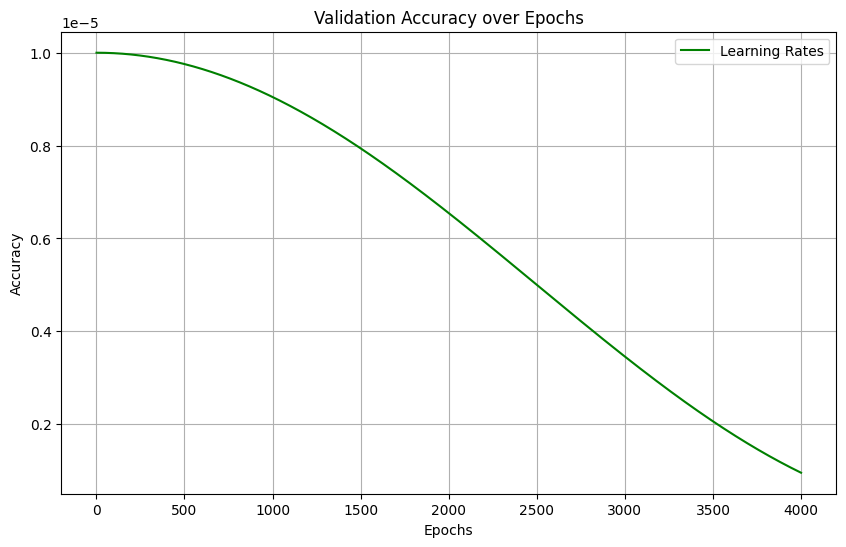

Model for bin 35 saved to GCNModels-5A_exp3/model_bin_35.pth
Training on bin 36/50
Bin 36, Epoch 1/4000, Train Loss: 0.6792, Validation Loss: 0.6903,  Accuracy: 0.7825, LR: 0.000010
Bin 36, Epoch 101/4000, Train Loss: 0.6094, Validation Loss: 0.6618,  Accuracy: 0.7910, LR: 0.000010
Bin 36, Epoch 201/4000, Train Loss: 0.5639, Validation Loss: 0.6034,  Accuracy: 0.8418, LR: 0.000010
Bin 36, Epoch 301/4000, Train Loss: 0.4943, Validation Loss: 0.5189,  Accuracy: 0.8757, LR: 0.000010
Bin 36, Epoch 401/4000, Train Loss: 0.4637, Validation Loss: 0.4763,  Accuracy: 0.8644, LR: 0.000010
Bin 36, Epoch 501/4000, Train Loss: 0.4210, Validation Loss: 0.4289,  Accuracy: 0.8729, LR: 0.000010
Bin 36, Epoch 601/4000, Train Loss: 0.3981, Validation Loss: 0.4084,  Accuracy: 0.8701, LR: 0.000010
Bin 36, Epoch 701/4000, Train Loss: 0.3692, Validation Loss: 0.3193,  Accuracy: 0.8785, LR: 0.000010
Bin 36, Epoch 801/4000, Train Loss: 0.3637, Validation Loss: 0.3177,  Accuracy: 0.8785, LR: 0.000009
Bin 36, Ep

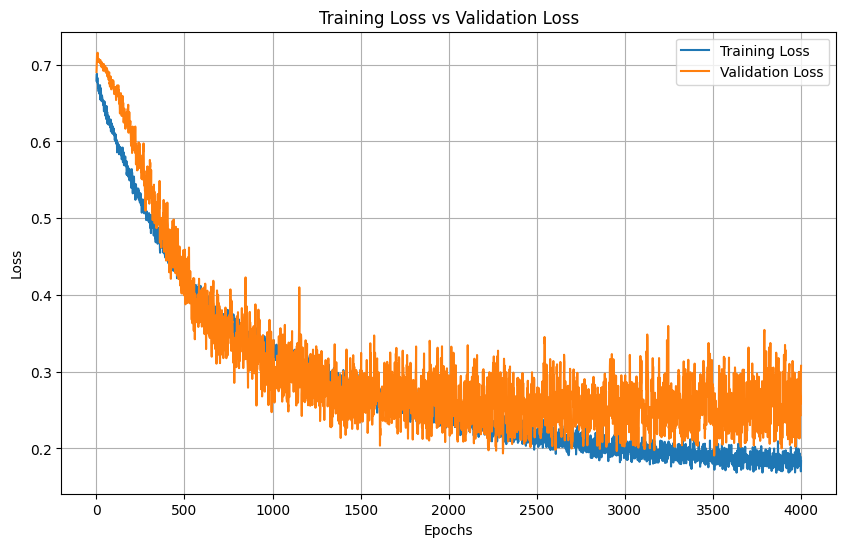

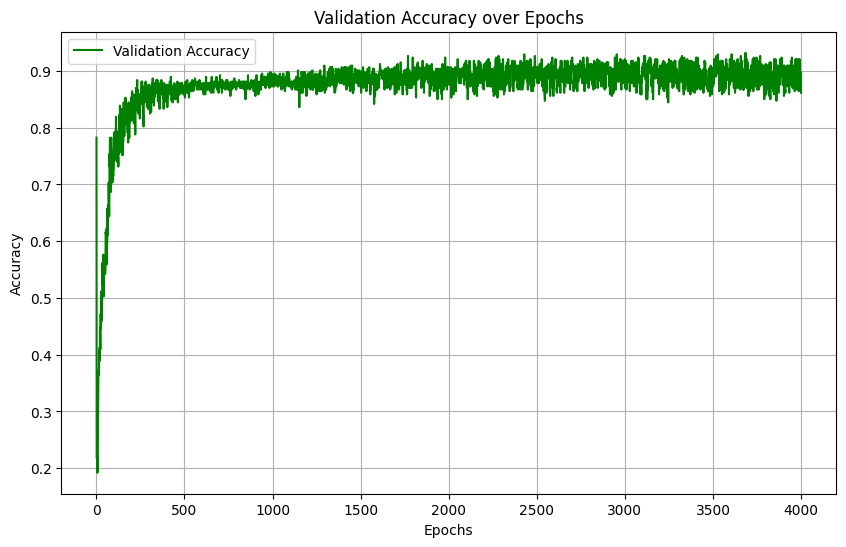

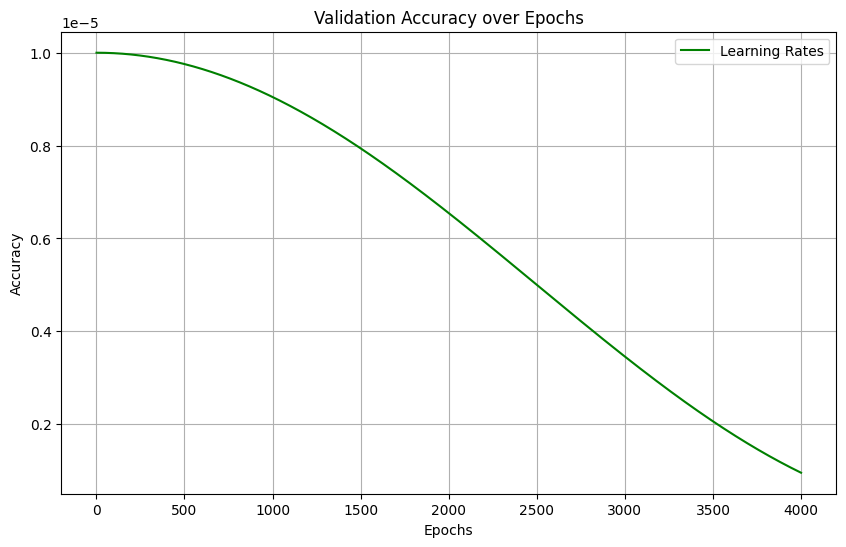

Model for bin 36 saved to GCNModels-5A_exp3/model_bin_36.pth
Training on bin 37/50
Bin 37, Epoch 1/4000, Train Loss: 0.7147, Validation Loss: 0.7041,  Accuracy: 0.2175, LR: 0.000010
Bin 37, Epoch 101/4000, Train Loss: 0.6531, Validation Loss: 0.6440,  Accuracy: 0.6921, LR: 0.000010
Bin 37, Epoch 201/4000, Train Loss: 0.5678, Validation Loss: 0.5736,  Accuracy: 0.7910, LR: 0.000010
Bin 37, Epoch 301/4000, Train Loss: 0.5138, Validation Loss: 0.5343,  Accuracy: 0.8107, LR: 0.000010
Bin 37, Epoch 401/4000, Train Loss: 0.4700, Validation Loss: 0.4485,  Accuracy: 0.8644, LR: 0.000010
Bin 37, Epoch 501/4000, Train Loss: 0.4475, Validation Loss: 0.3829,  Accuracy: 0.8785, LR: 0.000010
Bin 37, Epoch 601/4000, Train Loss: 0.4120, Validation Loss: 0.3100,  Accuracy: 0.9124, LR: 0.000010
Bin 37, Epoch 701/4000, Train Loss: 0.3939, Validation Loss: 0.3044,  Accuracy: 0.8983, LR: 0.000010
Bin 37, Epoch 801/4000, Train Loss: 0.3761, Validation Loss: 0.3034,  Accuracy: 0.8842, LR: 0.000009
Bin 37, Ep

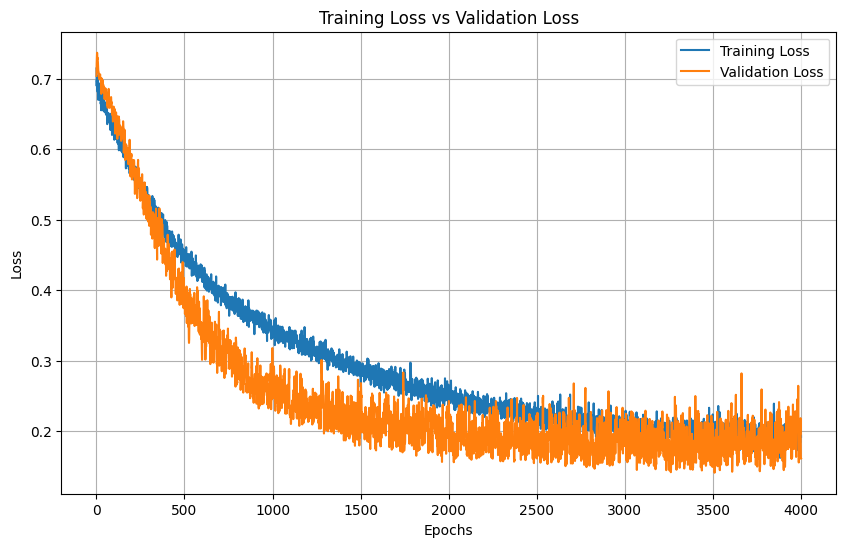

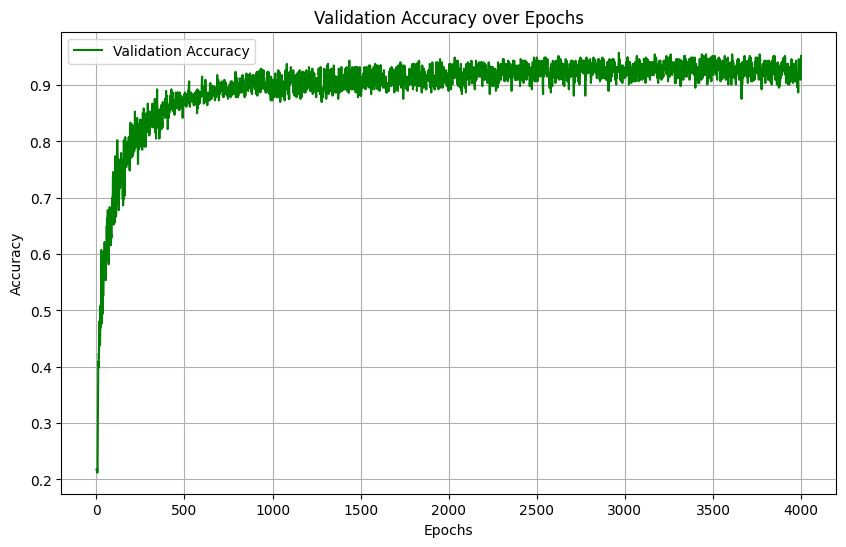

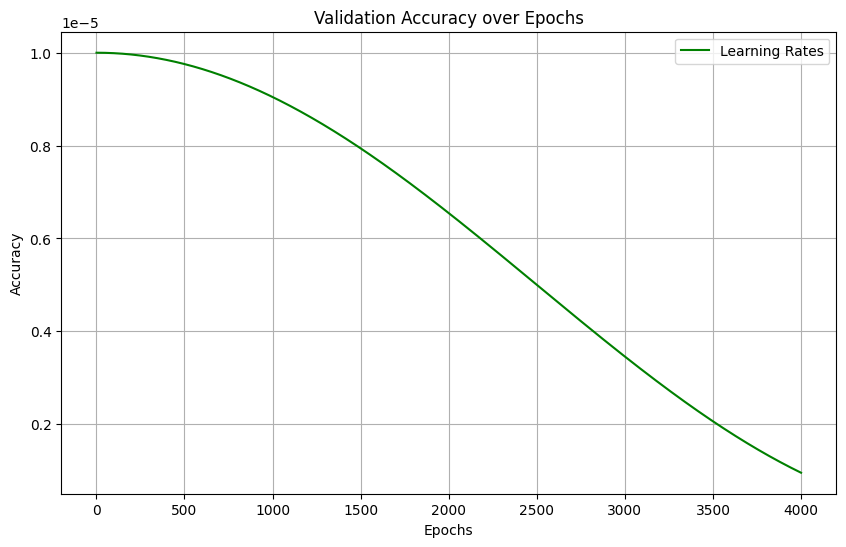

Model for bin 37 saved to GCNModels-5A_exp3/model_bin_37.pth
Training on bin 38/50
Bin 38, Epoch 1/4000, Train Loss: 0.6931, Validation Loss: 0.6862,  Accuracy: 0.7825, LR: 0.000010
Bin 38, Epoch 101/4000, Train Loss: 0.6019, Validation Loss: 0.6045,  Accuracy: 0.7486, LR: 0.000010
Bin 38, Epoch 201/4000, Train Loss: 0.5425, Validation Loss: 0.5212,  Accuracy: 0.7966, LR: 0.000010
Bin 38, Epoch 301/4000, Train Loss: 0.5358, Validation Loss: 0.4368,  Accuracy: 0.8475, LR: 0.000010
Bin 38, Epoch 401/4000, Train Loss: 0.4830, Validation Loss: 0.3741,  Accuracy: 0.8644, LR: 0.000010
Bin 38, Epoch 501/4000, Train Loss: 0.4315, Validation Loss: 0.3685,  Accuracy: 0.8531, LR: 0.000010
Bin 38, Epoch 601/4000, Train Loss: 0.4271, Validation Loss: 0.3442,  Accuracy: 0.8531, LR: 0.000010
Bin 38, Epoch 701/4000, Train Loss: 0.3772, Validation Loss: 0.3242,  Accuracy: 0.8616, LR: 0.000010
Bin 38, Epoch 801/4000, Train Loss: 0.3715, Validation Loss: 0.3069,  Accuracy: 0.8701, LR: 0.000009
Bin 38, Ep

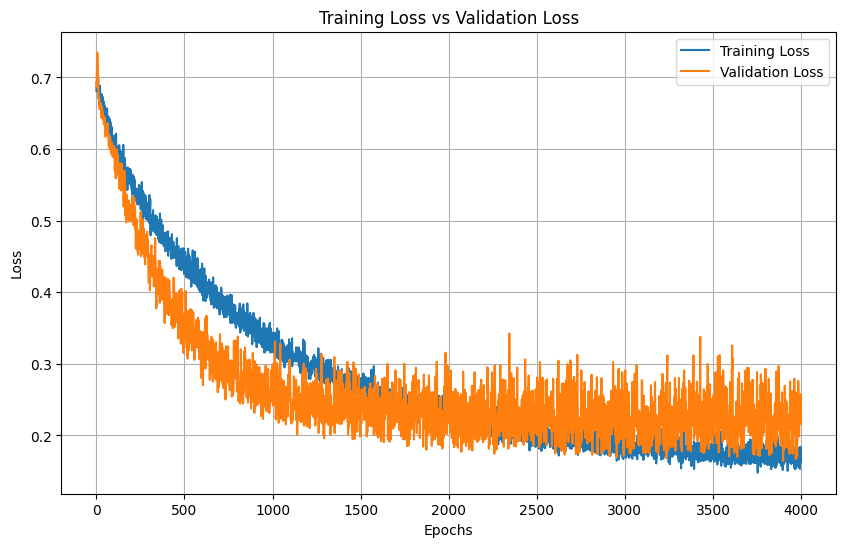

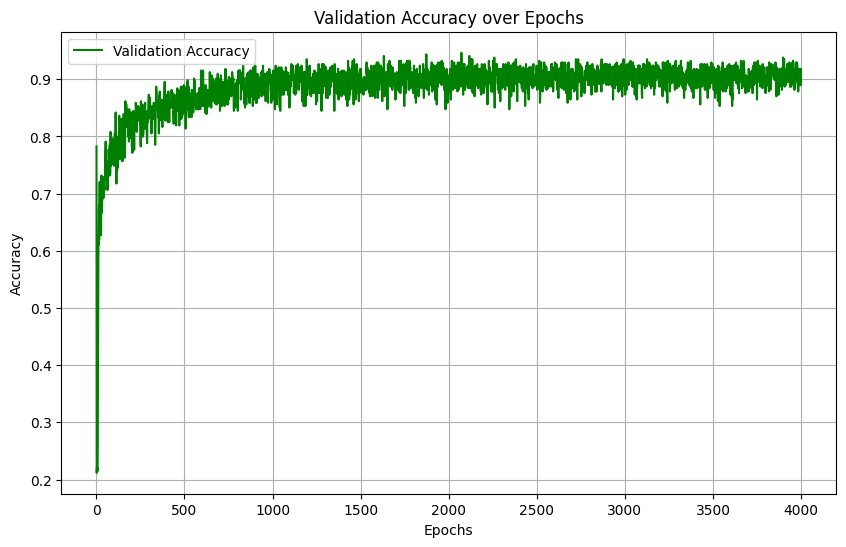

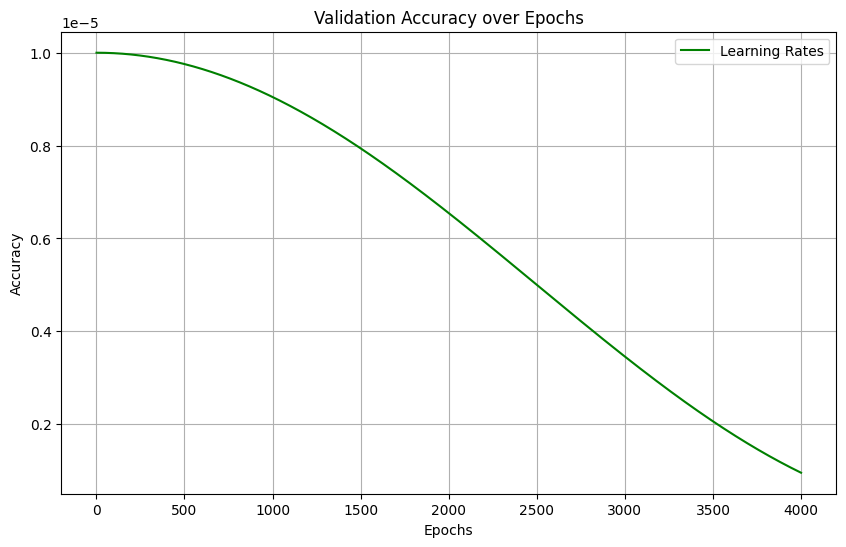

Model for bin 38 saved to GCNModels-5A_exp3/model_bin_38.pth
Training on bin 39/50
Bin 39, Epoch 1/4000, Train Loss: 0.7256, Validation Loss: 0.6796,  Accuracy: 0.7825, LR: 0.000010
Bin 39, Epoch 101/4000, Train Loss: 0.6020, Validation Loss: 0.6433,  Accuracy: 0.8164, LR: 0.000010
Bin 39, Epoch 201/4000, Train Loss: 0.5340, Validation Loss: 0.5600,  Accuracy: 0.8644, LR: 0.000010
Bin 39, Epoch 301/4000, Train Loss: 0.4906, Validation Loss: 0.5362,  Accuracy: 0.8333, LR: 0.000010
Bin 39, Epoch 401/4000, Train Loss: 0.4586, Validation Loss: 0.4636,  Accuracy: 0.8672, LR: 0.000010
Bin 39, Epoch 501/4000, Train Loss: 0.4384, Validation Loss: 0.4479,  Accuracy: 0.8531, LR: 0.000010
Bin 39, Epoch 601/4000, Train Loss: 0.3944, Validation Loss: 0.3913,  Accuracy: 0.8672, LR: 0.000010
Bin 39, Epoch 701/4000, Train Loss: 0.3758, Validation Loss: 0.3478,  Accuracy: 0.8701, LR: 0.000010
Bin 39, Epoch 801/4000, Train Loss: 0.3673, Validation Loss: 0.3396,  Accuracy: 0.8729, LR: 0.000009
Bin 39, Ep

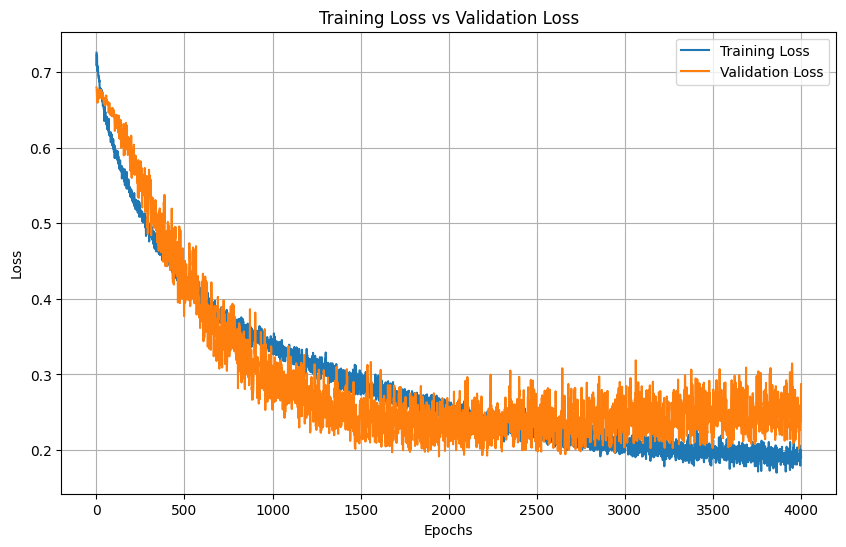

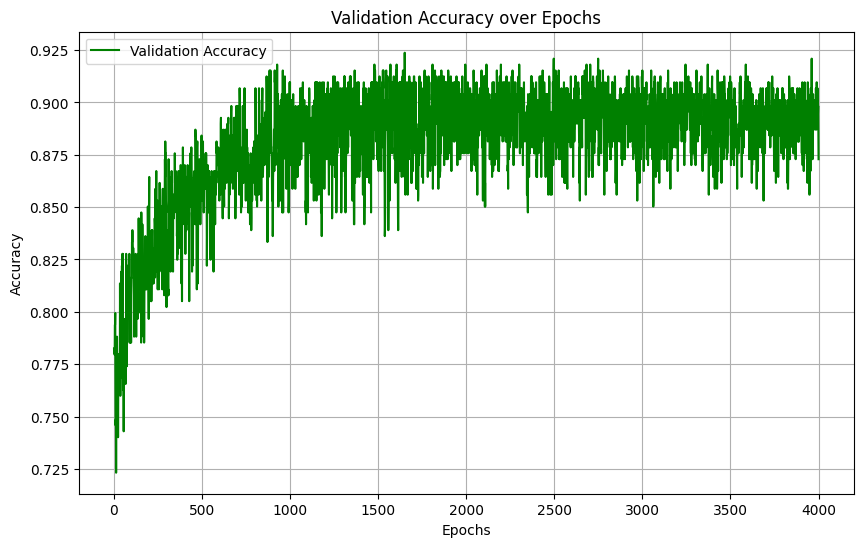

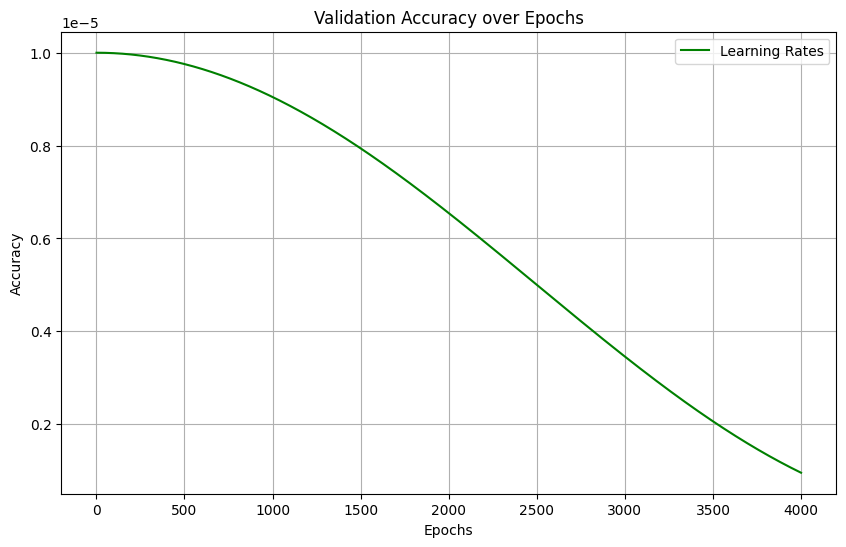

Model for bin 39 saved to GCNModels-5A_exp3/model_bin_39.pth
Training on bin 40/50
Bin 40, Epoch 1/4000, Train Loss: 0.6910, Validation Loss: 0.6865,  Accuracy: 0.7825, LR: 0.000010
Bin 40, Epoch 101/4000, Train Loss: 0.6598, Validation Loss: 0.6562,  Accuracy: 0.6384, LR: 0.000010
Bin 40, Epoch 201/4000, Train Loss: 0.6123, Validation Loss: 0.6276,  Accuracy: 0.6780, LR: 0.000010
Bin 40, Epoch 301/4000, Train Loss: 0.5905, Validation Loss: 0.5724,  Accuracy: 0.7486, LR: 0.000010
Bin 40, Epoch 401/4000, Train Loss: 0.5373, Validation Loss: 0.5314,  Accuracy: 0.7712, LR: 0.000010
Bin 40, Epoch 501/4000, Train Loss: 0.5055, Validation Loss: 0.4938,  Accuracy: 0.7768, LR: 0.000010
Bin 40, Epoch 601/4000, Train Loss: 0.4634, Validation Loss: 0.4807,  Accuracy: 0.7881, LR: 0.000010
Bin 40, Epoch 701/4000, Train Loss: 0.4477, Validation Loss: 0.4017,  Accuracy: 0.8418, LR: 0.000010
Bin 40, Epoch 801/4000, Train Loss: 0.4177, Validation Loss: 0.3986,  Accuracy: 0.8390, LR: 0.000009
Bin 40, Ep

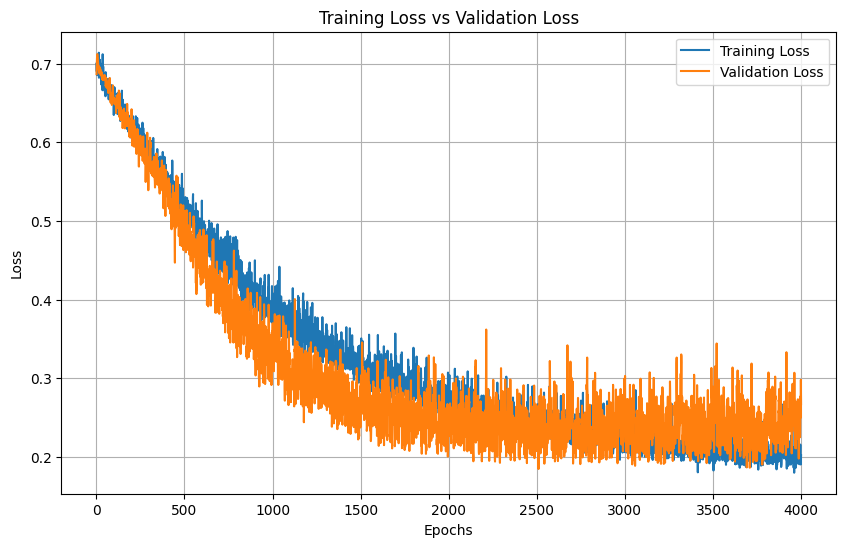

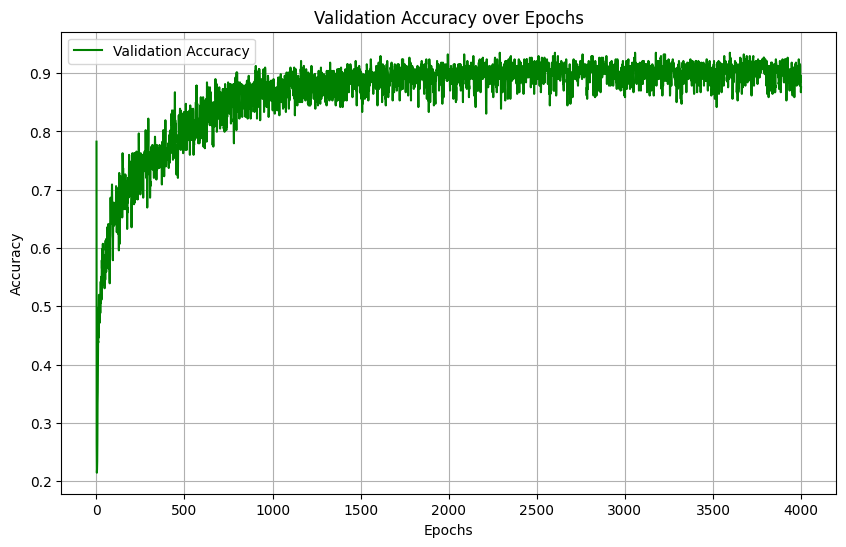

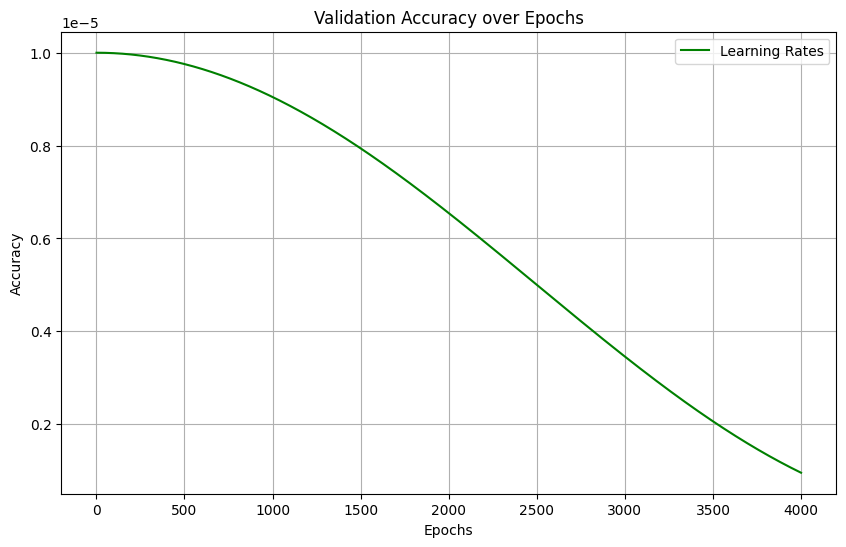

Model for bin 40 saved to GCNModels-5A_exp3/model_bin_40.pth
Training on bin 41/50
Bin 41, Epoch 1/4000, Train Loss: 0.7155, Validation Loss: 0.6591,  Accuracy: 0.7825, LR: 0.000010
Bin 41, Epoch 101/4000, Train Loss: 0.6180, Validation Loss: 0.6123,  Accuracy: 0.8503, LR: 0.000010
Bin 41, Epoch 201/4000, Train Loss: 0.5525, Validation Loss: 0.5318,  Accuracy: 0.8785, LR: 0.000010
Bin 41, Epoch 301/4000, Train Loss: 0.5012, Validation Loss: 0.4952,  Accuracy: 0.8644, LR: 0.000010
Bin 41, Epoch 401/4000, Train Loss: 0.4565, Validation Loss: 0.4214,  Accuracy: 0.8898, LR: 0.000010
Bin 41, Epoch 501/4000, Train Loss: 0.4215, Validation Loss: 0.4142,  Accuracy: 0.8729, LR: 0.000010
Bin 41, Epoch 601/4000, Train Loss: 0.3838, Validation Loss: 0.3422,  Accuracy: 0.8955, LR: 0.000010
Bin 41, Epoch 701/4000, Train Loss: 0.3730, Validation Loss: 0.3187,  Accuracy: 0.9040, LR: 0.000010
Bin 41, Epoch 801/4000, Train Loss: 0.3540, Validation Loss: 0.3468,  Accuracy: 0.8870, LR: 0.000009
Bin 41, Ep

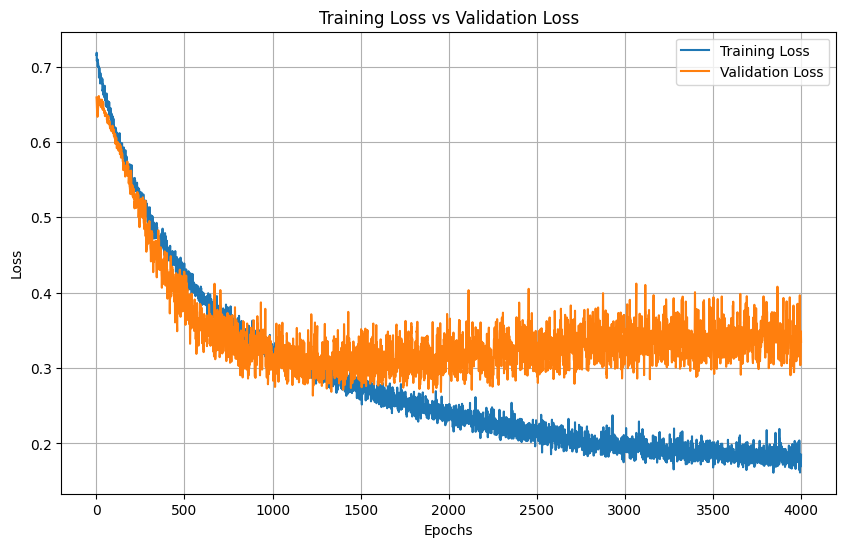

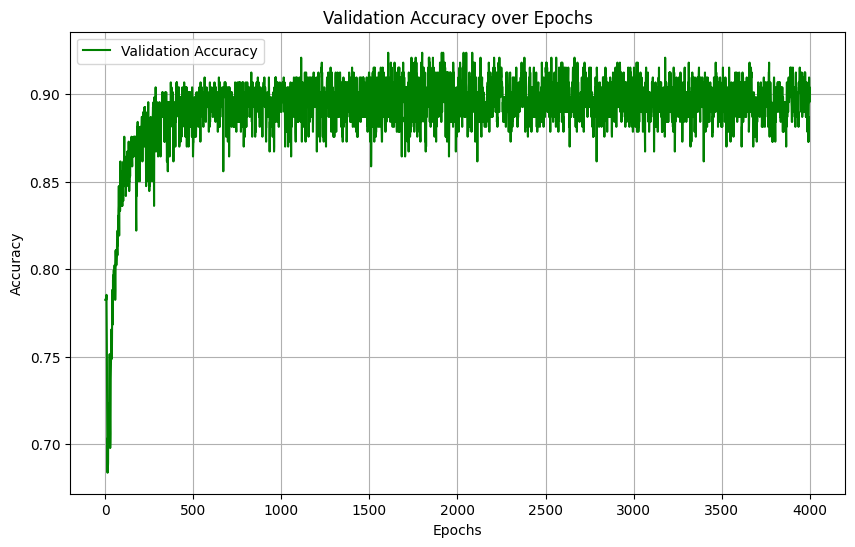

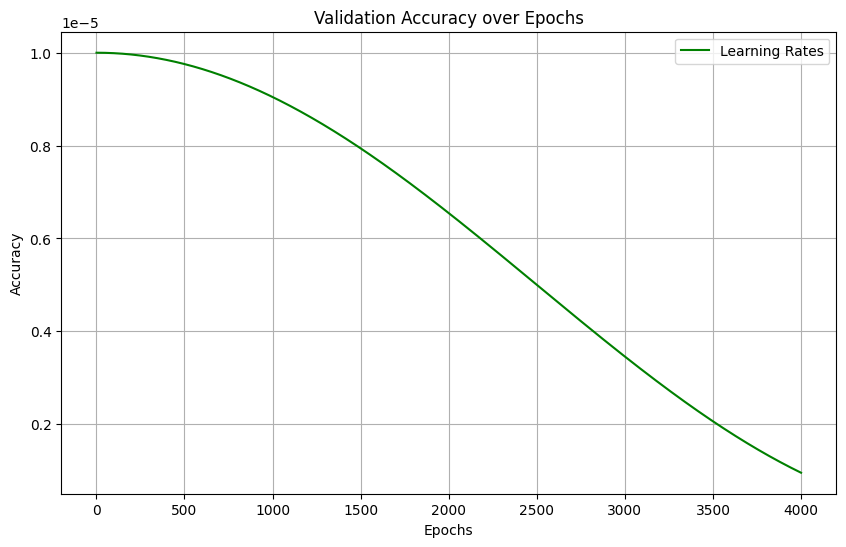

Model for bin 41 saved to GCNModels-5A_exp3/model_bin_41.pth
Training on bin 42/50
Bin 42, Epoch 1/4000, Train Loss: 0.7269, Validation Loss: 0.7059,  Accuracy: 0.2175, LR: 0.000010
Bin 42, Epoch 101/4000, Train Loss: 0.6288, Validation Loss: 0.6471,  Accuracy: 0.7288, LR: 0.000010
Bin 42, Epoch 201/4000, Train Loss: 0.5567, Validation Loss: 0.5467,  Accuracy: 0.8362, LR: 0.000010
Bin 42, Epoch 301/4000, Train Loss: 0.4806, Validation Loss: 0.4605,  Accuracy: 0.8644, LR: 0.000010
Bin 42, Epoch 401/4000, Train Loss: 0.4615, Validation Loss: 0.4140,  Accuracy: 0.8531, LR: 0.000010
Bin 42, Epoch 501/4000, Train Loss: 0.4187, Validation Loss: 0.3788,  Accuracy: 0.8701, LR: 0.000010
Bin 42, Epoch 601/4000, Train Loss: 0.3829, Validation Loss: 0.3706,  Accuracy: 0.8559, LR: 0.000010
Bin 42, Epoch 701/4000, Train Loss: 0.3719, Validation Loss: 0.3481,  Accuracy: 0.8559, LR: 0.000010
Bin 42, Epoch 801/4000, Train Loss: 0.3540, Validation Loss: 0.3242,  Accuracy: 0.8588, LR: 0.000009
Bin 42, Ep

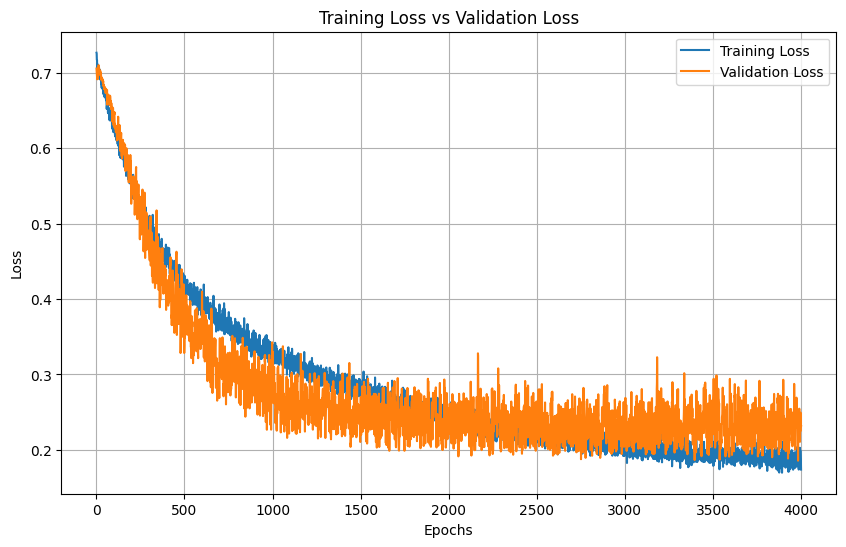

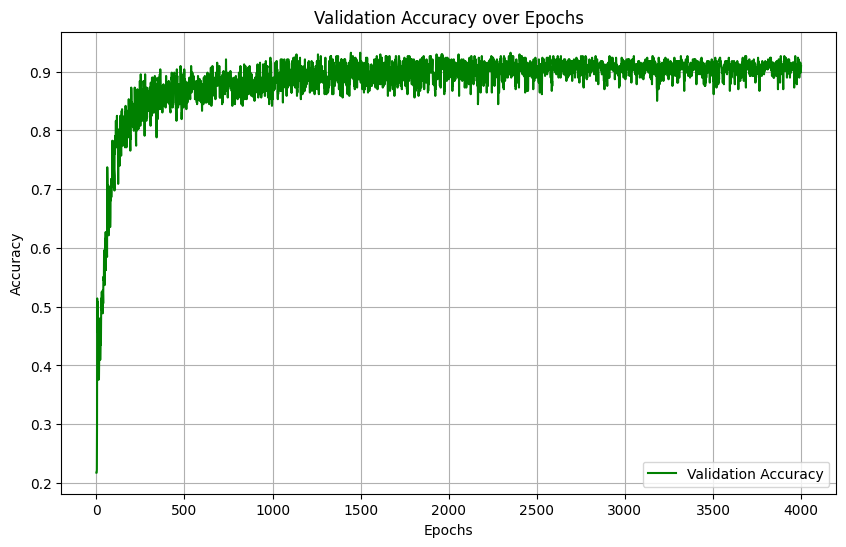

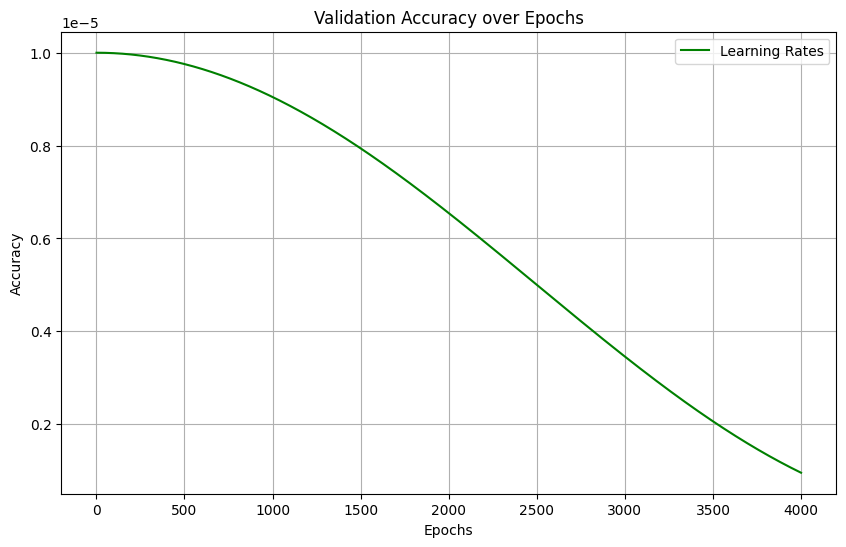

Model for bin 42 saved to GCNModels-5A_exp3/model_bin_42.pth
Training on bin 43/50
Bin 43, Epoch 1/4000, Train Loss: 0.7118, Validation Loss: 0.6982,  Accuracy: 0.2175, LR: 0.000010
Bin 43, Epoch 101/4000, Train Loss: 0.6352, Validation Loss: 0.6278,  Accuracy: 0.7458, LR: 0.000010
Bin 43, Epoch 201/4000, Train Loss: 0.5824, Validation Loss: 0.5680,  Accuracy: 0.8051, LR: 0.000010
Bin 43, Epoch 301/4000, Train Loss: 0.5596, Validation Loss: 0.5077,  Accuracy: 0.8305, LR: 0.000010
Bin 43, Epoch 401/4000, Train Loss: 0.5219, Validation Loss: 0.4680,  Accuracy: 0.8475, LR: 0.000010
Bin 43, Epoch 501/4000, Train Loss: 0.4687, Validation Loss: 0.3990,  Accuracy: 0.8672, LR: 0.000010
Bin 43, Epoch 601/4000, Train Loss: 0.4617, Validation Loss: 0.3584,  Accuracy: 0.8785, LR: 0.000010
Bin 43, Epoch 701/4000, Train Loss: 0.4286, Validation Loss: 0.3545,  Accuracy: 0.8757, LR: 0.000010
Bin 43, Epoch 801/4000, Train Loss: 0.4220, Validation Loss: 0.3021,  Accuracy: 0.9124, LR: 0.000009
Bin 43, Ep

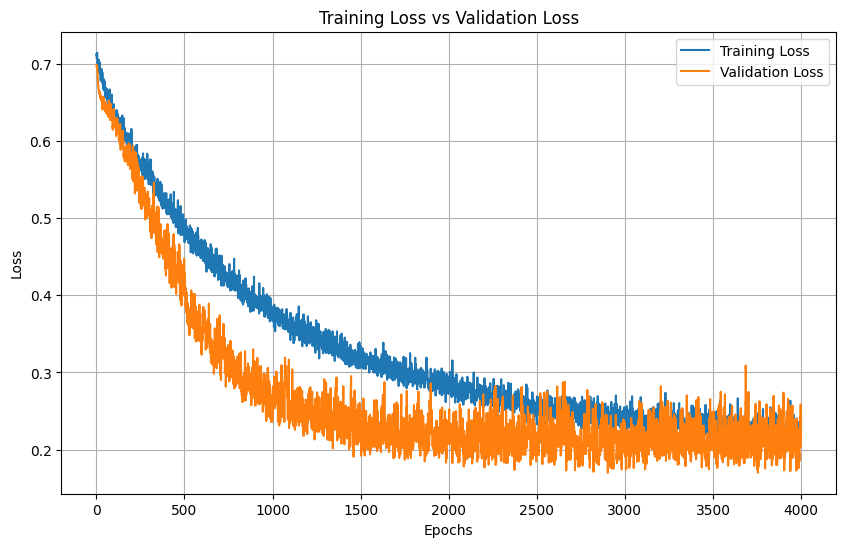

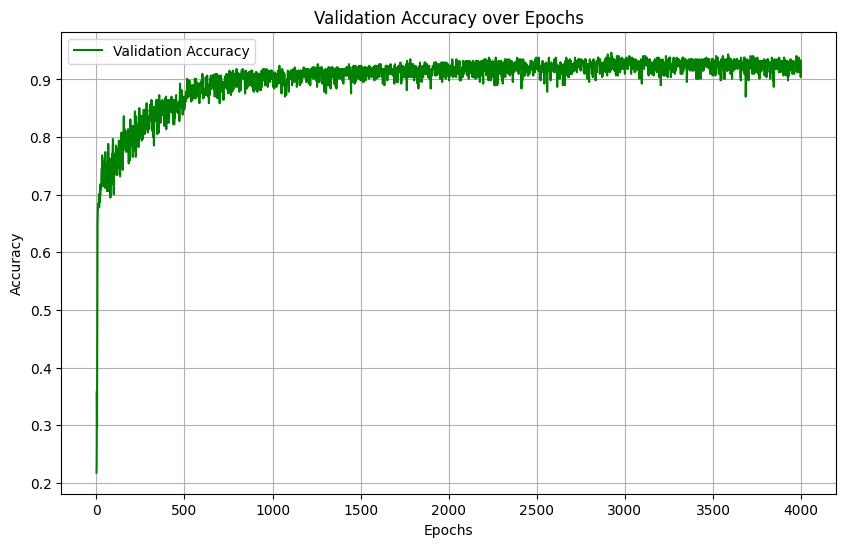

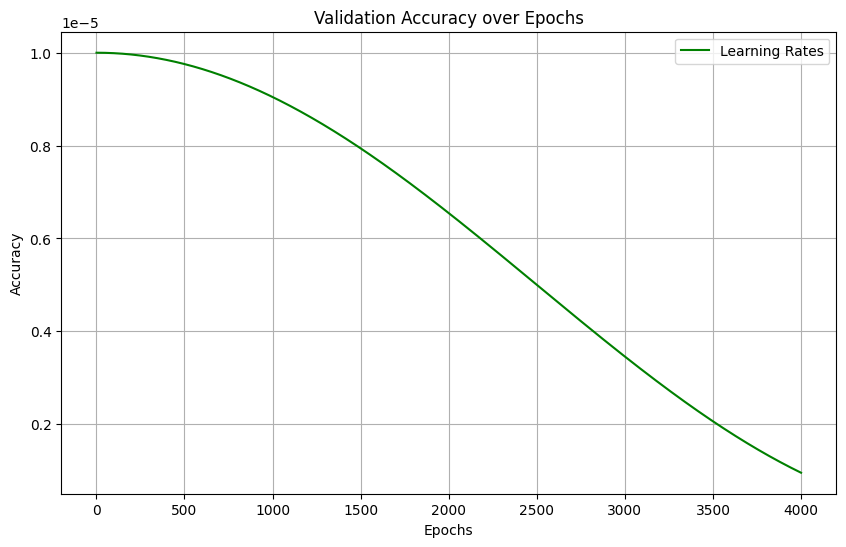

Model for bin 43 saved to GCNModels-5A_exp3/model_bin_43.pth
Training on bin 44/50
Bin 44, Epoch 1/4000, Train Loss: 0.6784, Validation Loss: 0.6910,  Accuracy: 0.7825, LR: 0.000010
Bin 44, Epoch 101/4000, Train Loss: 0.6149, Validation Loss: 0.6231,  Accuracy: 0.8051, LR: 0.000010
Bin 44, Epoch 201/4000, Train Loss: 0.5554, Validation Loss: 0.5375,  Accuracy: 0.8475, LR: 0.000010
Bin 44, Epoch 301/4000, Train Loss: 0.5150, Validation Loss: 0.4874,  Accuracy: 0.8531, LR: 0.000010
Bin 44, Epoch 401/4000, Train Loss: 0.4811, Validation Loss: 0.3905,  Accuracy: 0.8898, LR: 0.000010
Bin 44, Epoch 501/4000, Train Loss: 0.4372, Validation Loss: 0.3509,  Accuracy: 0.9040, LR: 0.000010
Bin 44, Epoch 601/4000, Train Loss: 0.4168, Validation Loss: 0.3501,  Accuracy: 0.8588, LR: 0.000010
Bin 44, Epoch 701/4000, Train Loss: 0.3965, Validation Loss: 0.3174,  Accuracy: 0.8729, LR: 0.000010
Bin 44, Epoch 801/4000, Train Loss: 0.3762, Validation Loss: 0.2961,  Accuracy: 0.8842, LR: 0.000009
Bin 44, Ep

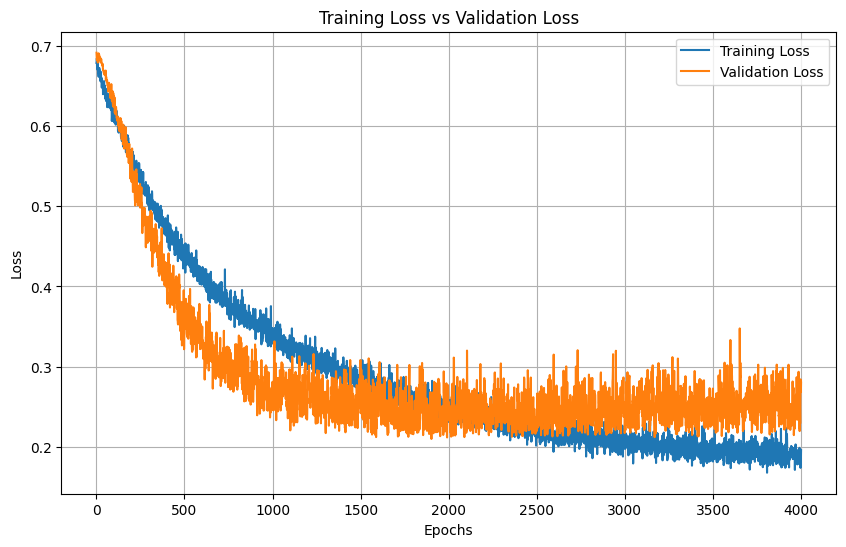

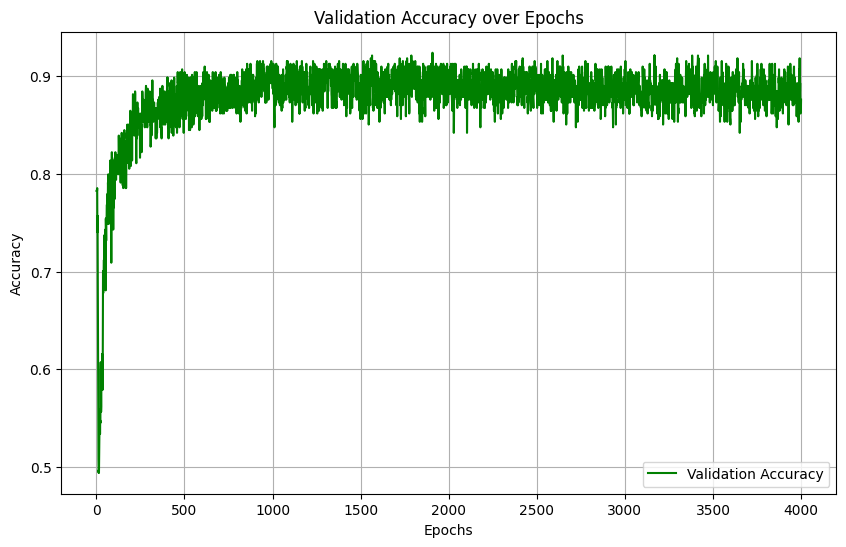

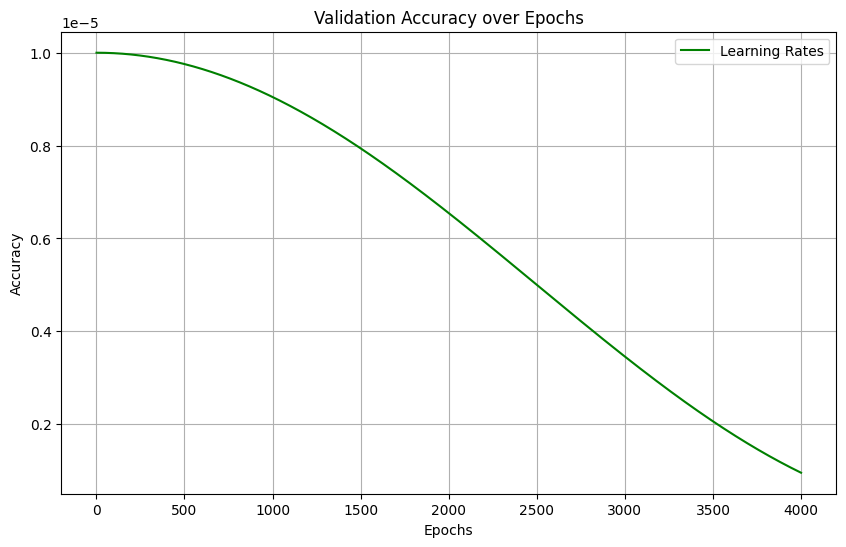

Model for bin 44 saved to GCNModels-5A_exp3/model_bin_44.pth
Training on bin 45/50
Bin 45, Epoch 1/4000, Train Loss: 0.6931, Validation Loss: 0.6937,  Accuracy: 0.2910, LR: 0.000010
Bin 45, Epoch 101/4000, Train Loss: 0.6077, Validation Loss: 0.6536,  Accuracy: 0.7232, LR: 0.000010
Bin 45, Epoch 201/4000, Train Loss: 0.5510, Validation Loss: 0.5648,  Accuracy: 0.8362, LR: 0.000010
Bin 45, Epoch 301/4000, Train Loss: 0.4992, Validation Loss: 0.5350,  Accuracy: 0.8192, LR: 0.000010
Bin 45, Epoch 401/4000, Train Loss: 0.4378, Validation Loss: 0.4620,  Accuracy: 0.8446, LR: 0.000010
Bin 45, Epoch 501/4000, Train Loss: 0.4114, Validation Loss: 0.4036,  Accuracy: 0.8870, LR: 0.000010
Bin 45, Epoch 601/4000, Train Loss: 0.3963, Validation Loss: 0.3568,  Accuracy: 0.9011, LR: 0.000010
Bin 45, Epoch 701/4000, Train Loss: 0.3430, Validation Loss: 0.3756,  Accuracy: 0.8701, LR: 0.000010
Bin 45, Epoch 801/4000, Train Loss: 0.3482, Validation Loss: 0.3035,  Accuracy: 0.9181, LR: 0.000009
Bin 45, Ep

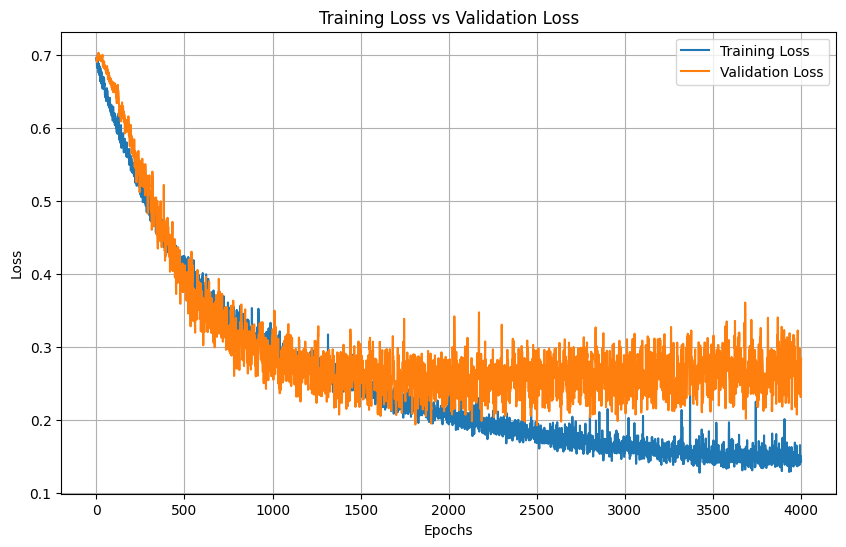

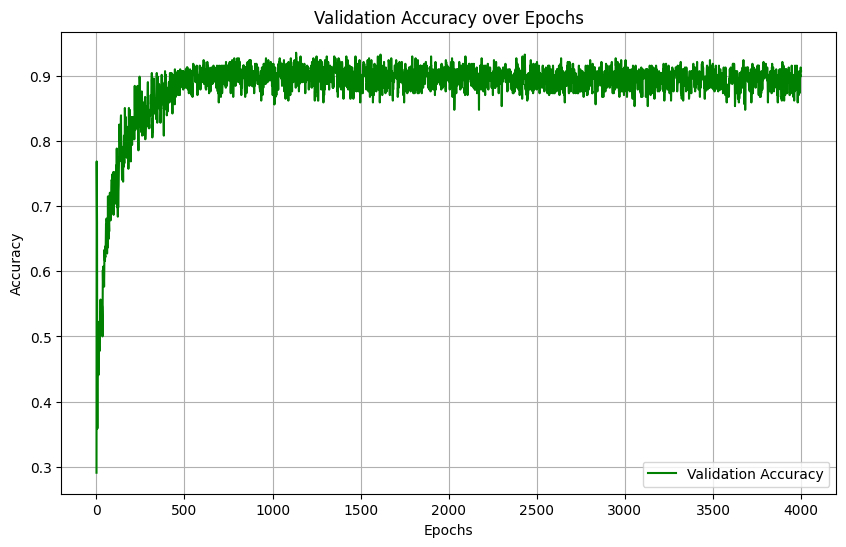

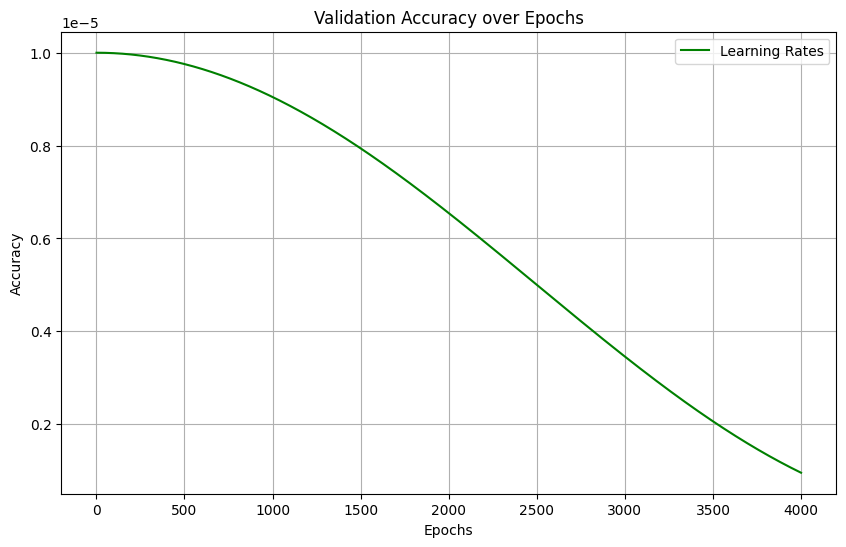

Model for bin 45 saved to GCNModels-5A_exp3/model_bin_45.pth
Training on bin 46/50
Bin 46, Epoch 1/4000, Train Loss: 0.6739, Validation Loss: 0.6653,  Accuracy: 0.7825, LR: 0.000010
Bin 46, Epoch 101/4000, Train Loss: 0.6315, Validation Loss: 0.6386,  Accuracy: 0.7542, LR: 0.000010
Bin 46, Epoch 201/4000, Train Loss: 0.5882, Validation Loss: 0.5828,  Accuracy: 0.8051, LR: 0.000010
Bin 46, Epoch 301/4000, Train Loss: 0.5424, Validation Loss: 0.5698,  Accuracy: 0.7571, LR: 0.000010
Bin 46, Epoch 401/4000, Train Loss: 0.4995, Validation Loss: 0.4871,  Accuracy: 0.8164, LR: 0.000010
Bin 46, Epoch 501/4000, Train Loss: 0.4528, Validation Loss: 0.3971,  Accuracy: 0.8842, LR: 0.000010
Bin 46, Epoch 601/4000, Train Loss: 0.4293, Validation Loss: 0.4180,  Accuracy: 0.8503, LR: 0.000010
Bin 46, Epoch 701/4000, Train Loss: 0.4222, Validation Loss: 0.3563,  Accuracy: 0.8588, LR: 0.000010
Bin 46, Epoch 801/4000, Train Loss: 0.3668, Validation Loss: 0.3060,  Accuracy: 0.8870, LR: 0.000009
Bin 46, Ep

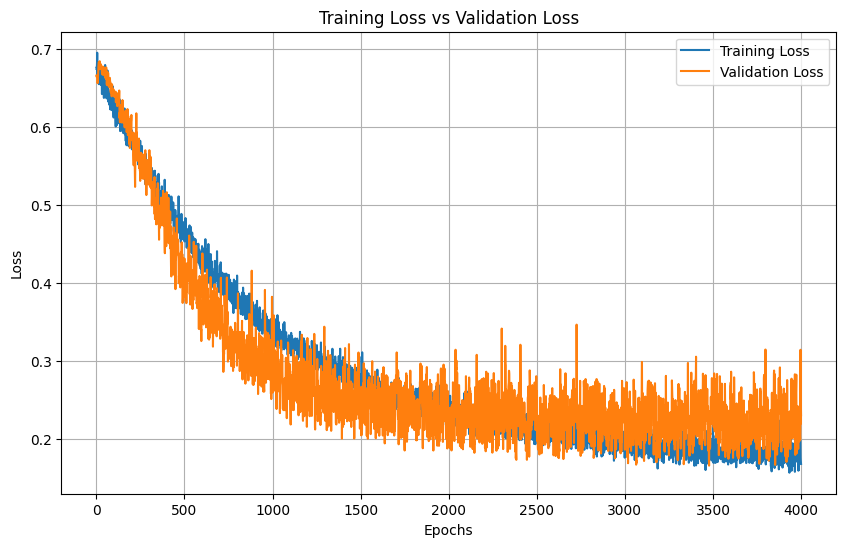

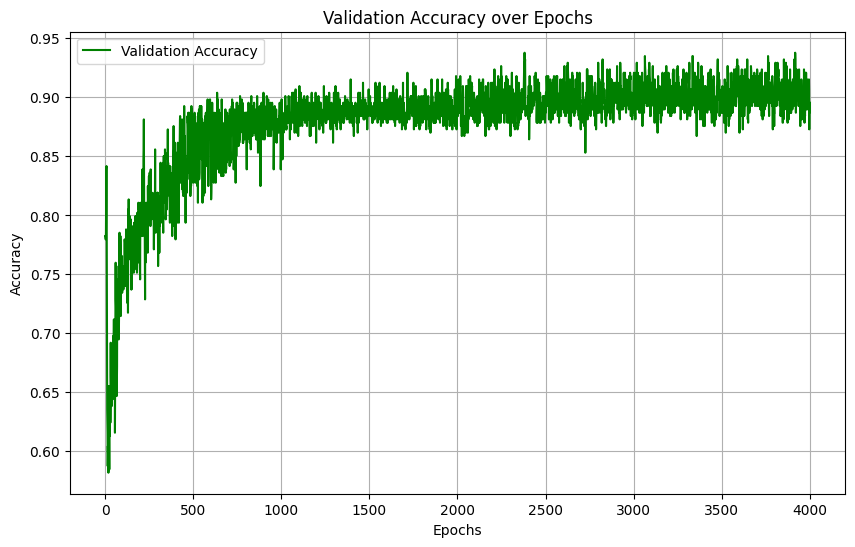

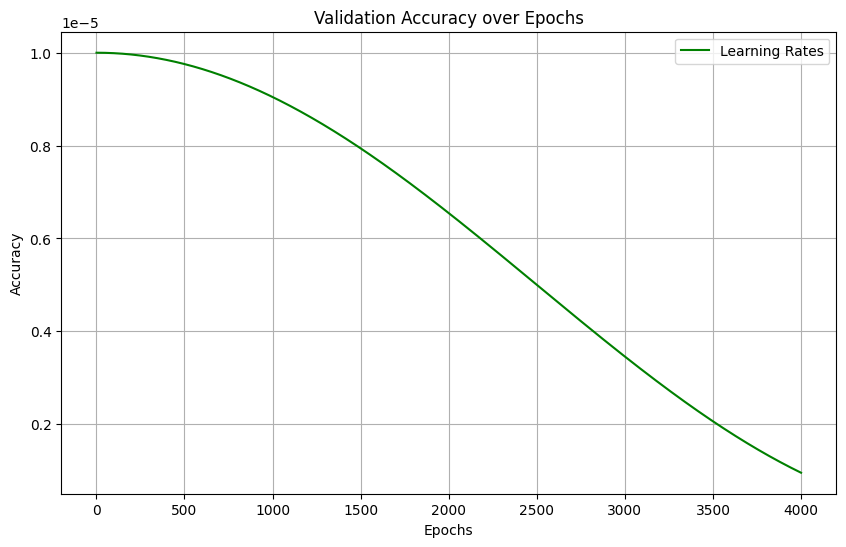

Model for bin 46 saved to GCNModels-5A_exp3/model_bin_46.pth
Training on bin 47/50
Bin 47, Epoch 1/4000, Train Loss: 0.7018, Validation Loss: 0.7225,  Accuracy: 0.2175, LR: 0.000010
Bin 47, Epoch 101/4000, Train Loss: 0.6377, Validation Loss: 0.6657,  Accuracy: 0.6045, LR: 0.000010
Bin 47, Epoch 201/4000, Train Loss: 0.5823, Validation Loss: 0.6031,  Accuracy: 0.7345, LR: 0.000010
Bin 47, Epoch 301/4000, Train Loss: 0.5432, Validation Loss: 0.5286,  Accuracy: 0.8023, LR: 0.000010
Bin 47, Epoch 401/4000, Train Loss: 0.5197, Validation Loss: 0.4777,  Accuracy: 0.8107, LR: 0.000010
Bin 47, Epoch 501/4000, Train Loss: 0.4927, Validation Loss: 0.3984,  Accuracy: 0.8559, LR: 0.000010
Bin 47, Epoch 601/4000, Train Loss: 0.4604, Validation Loss: 0.3612,  Accuracy: 0.8757, LR: 0.000010
Bin 47, Epoch 701/4000, Train Loss: 0.4128, Validation Loss: 0.3489,  Accuracy: 0.8729, LR: 0.000010
Bin 47, Epoch 801/4000, Train Loss: 0.3980, Validation Loss: 0.3528,  Accuracy: 0.8701, LR: 0.000009
Bin 47, Ep

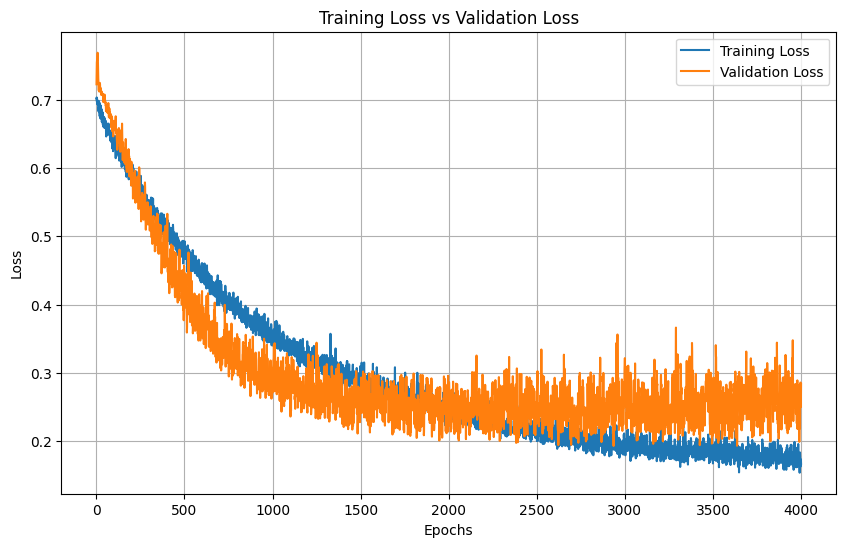

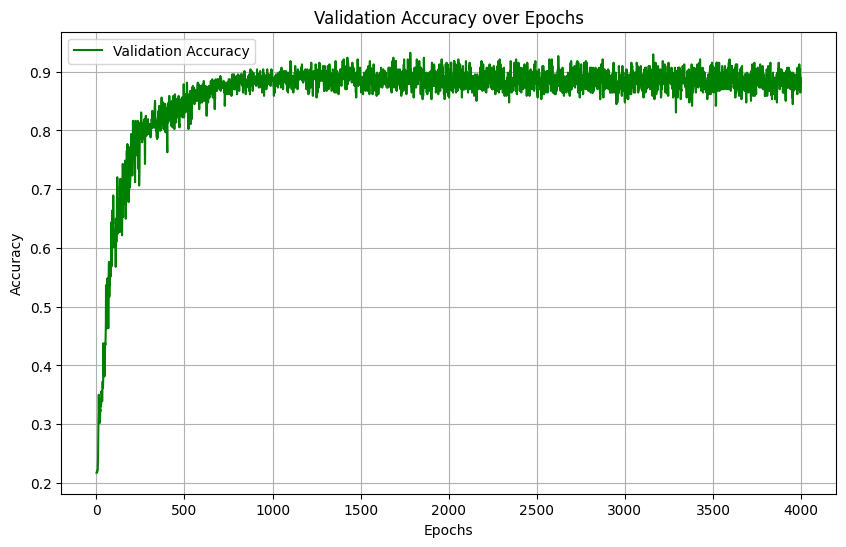

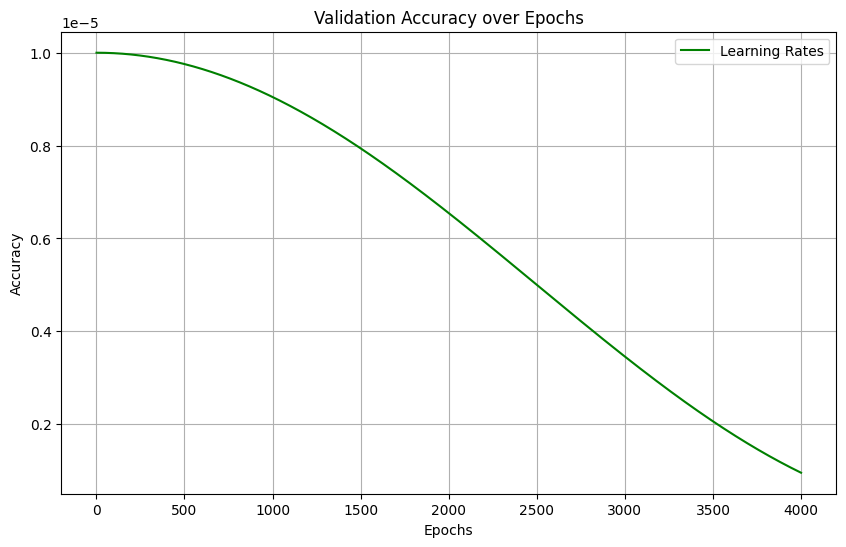

Model for bin 47 saved to GCNModels-5A_exp3/model_bin_47.pth
Training on bin 48/50
Bin 48, Epoch 1/4000, Train Loss: 0.7110, Validation Loss: 0.7045,  Accuracy: 0.2175, LR: 0.000010
Bin 48, Epoch 101/4000, Train Loss: 0.5951, Validation Loss: 0.5768,  Accuracy: 0.8136, LR: 0.000010
Bin 48, Epoch 201/4000, Train Loss: 0.5273, Validation Loss: 0.4902,  Accuracy: 0.8362, LR: 0.000010
Bin 48, Epoch 301/4000, Train Loss: 0.4774, Validation Loss: 0.4368,  Accuracy: 0.8418, LR: 0.000010
Bin 48, Epoch 401/4000, Train Loss: 0.4503, Validation Loss: 0.4114,  Accuracy: 0.8390, LR: 0.000010
Bin 48, Epoch 501/4000, Train Loss: 0.3994, Validation Loss: 0.4097,  Accuracy: 0.8475, LR: 0.000010
Bin 48, Epoch 601/4000, Train Loss: 0.3703, Validation Loss: 0.3270,  Accuracy: 0.8898, LR: 0.000010
Bin 48, Epoch 701/4000, Train Loss: 0.3575, Validation Loss: 0.2664,  Accuracy: 0.9153, LR: 0.000010
Bin 48, Epoch 801/4000, Train Loss: 0.3397, Validation Loss: 0.2857,  Accuracy: 0.8955, LR: 0.000009
Bin 48, Ep

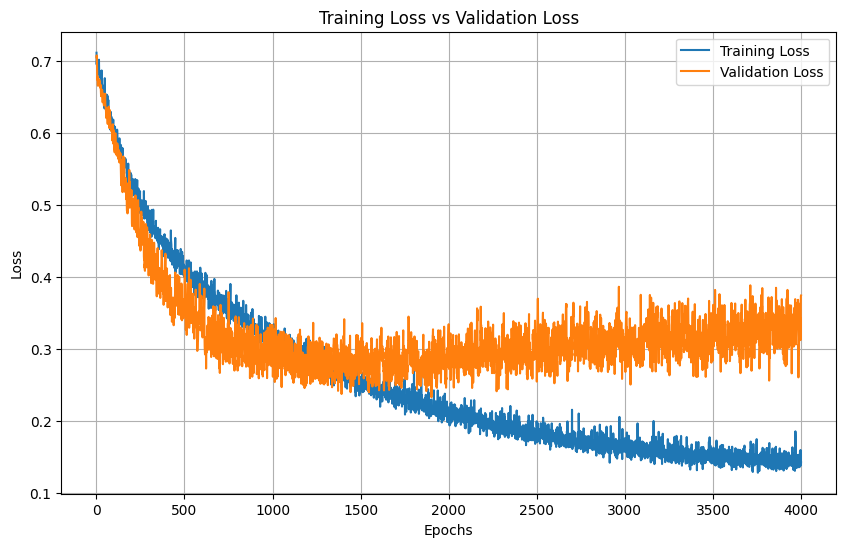

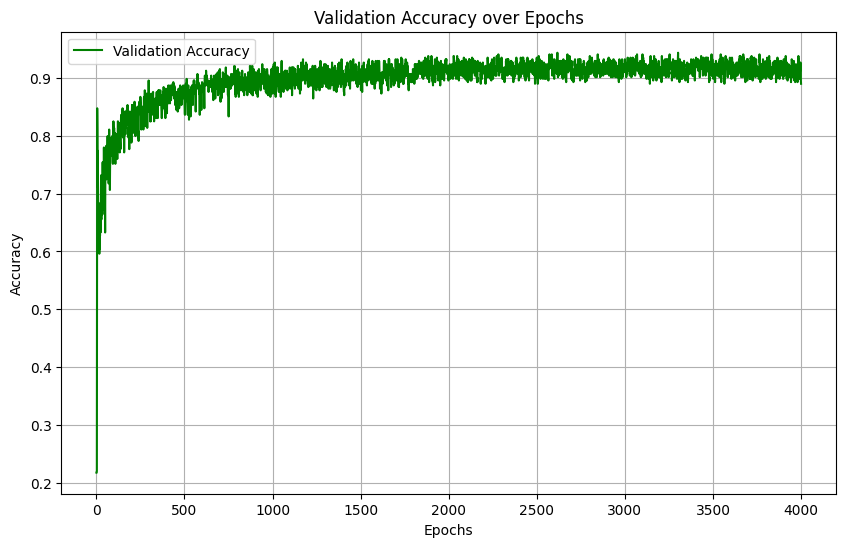

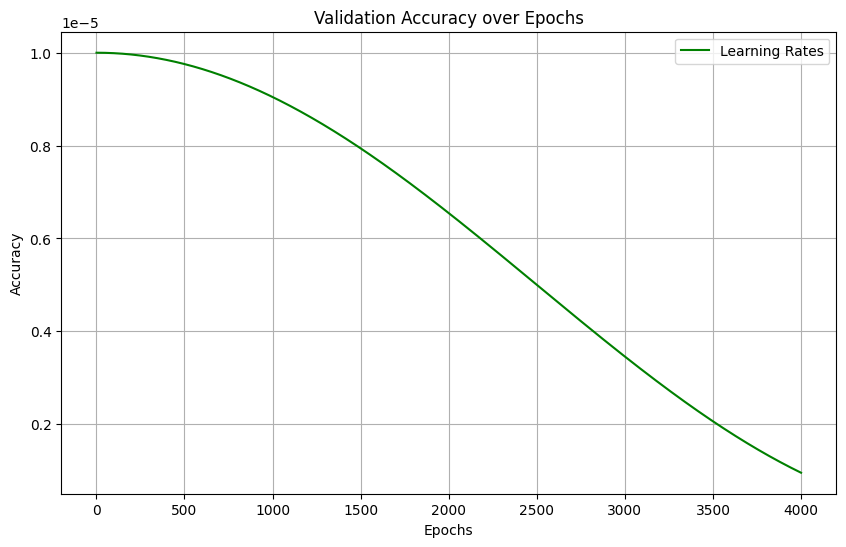

Model for bin 48 saved to GCNModels-5A_exp3/model_bin_48.pth
Training on bin 49/50
Bin 49, Epoch 1/4000, Train Loss: 0.7062, Validation Loss: 0.7099,  Accuracy: 0.2175, LR: 0.000010
Bin 49, Epoch 101/4000, Train Loss: 0.6310, Validation Loss: 0.6532,  Accuracy: 0.7797, LR: 0.000010
Bin 49, Epoch 201/4000, Train Loss: 0.5813, Validation Loss: 0.5923,  Accuracy: 0.8277, LR: 0.000010
Bin 49, Epoch 301/4000, Train Loss: 0.5319, Validation Loss: 0.5486,  Accuracy: 0.8107, LR: 0.000010
Bin 49, Epoch 401/4000, Train Loss: 0.4900, Validation Loss: 0.4421,  Accuracy: 0.8729, LR: 0.000010
Bin 49, Epoch 501/4000, Train Loss: 0.4472, Validation Loss: 0.4232,  Accuracy: 0.8531, LR: 0.000010
Bin 49, Epoch 601/4000, Train Loss: 0.4249, Validation Loss: 0.3377,  Accuracy: 0.8927, LR: 0.000010
Bin 49, Epoch 701/4000, Train Loss: 0.4246, Validation Loss: 0.3034,  Accuracy: 0.9040, LR: 0.000010
Bin 49, Epoch 801/4000, Train Loss: 0.3744, Validation Loss: 0.3130,  Accuracy: 0.8955, LR: 0.000009
Bin 49, Ep

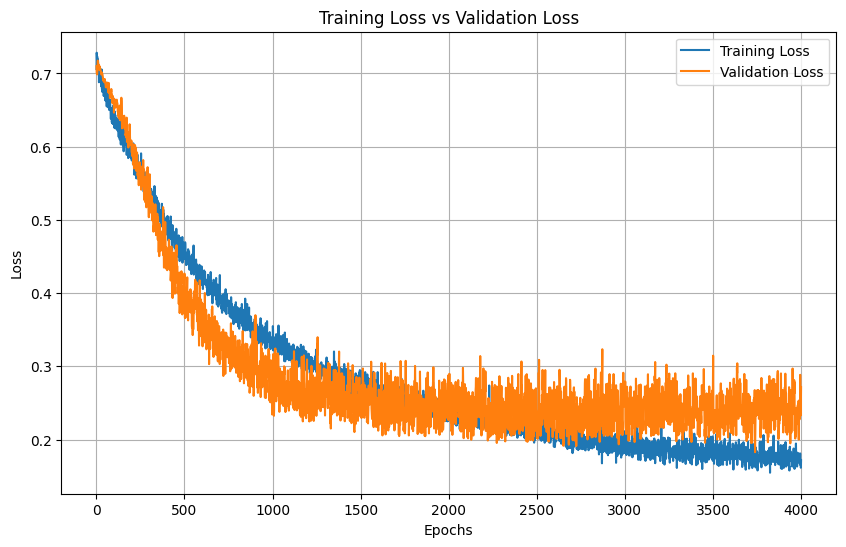

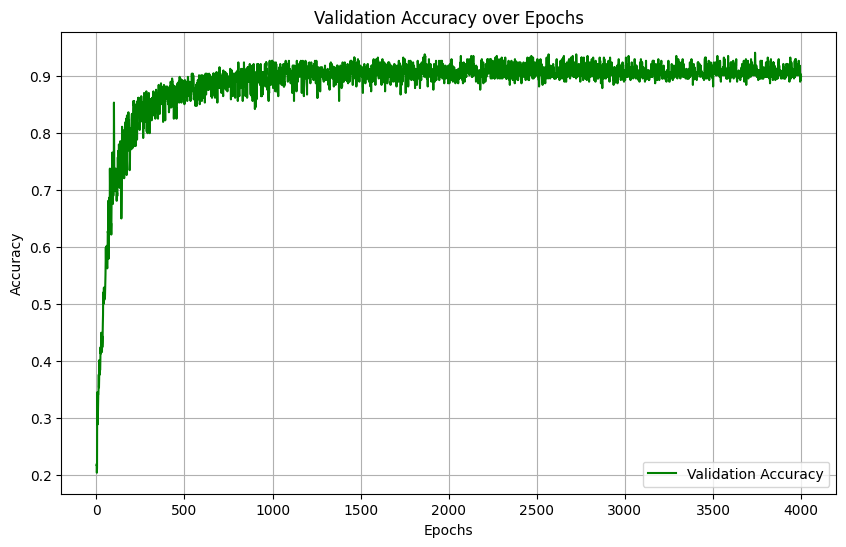

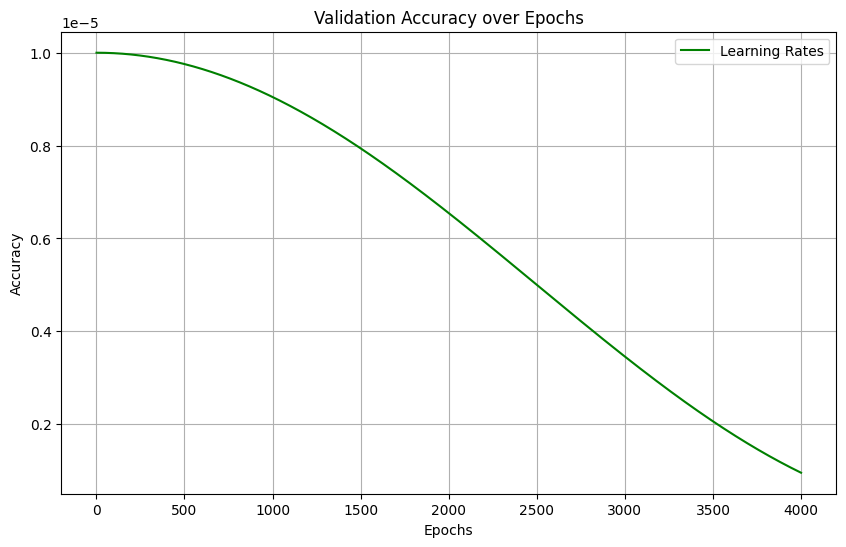

Model for bin 49 saved to GCNModels-5A_exp3/model_bin_49.pth
Training on bin 50/50
Bin 50, Epoch 1/4000, Train Loss: 0.7081, Validation Loss: 0.6811,  Accuracy: 0.7825, LR: 0.000010
Bin 50, Epoch 101/4000, Train Loss: 0.6327, Validation Loss: 0.6226,  Accuracy: 0.8023, LR: 0.000010
Bin 50, Epoch 201/4000, Train Loss: 0.5801, Validation Loss: 0.5574,  Accuracy: 0.8446, LR: 0.000010
Bin 50, Epoch 301/4000, Train Loss: 0.5409, Validation Loss: 0.4833,  Accuracy: 0.8785, LR: 0.000010
Bin 50, Epoch 401/4000, Train Loss: 0.5184, Validation Loss: 0.4440,  Accuracy: 0.8757, LR: 0.000010
Bin 50, Epoch 501/4000, Train Loss: 0.4541, Validation Loss: 0.3701,  Accuracy: 0.8955, LR: 0.000010
Bin 50, Epoch 601/4000, Train Loss: 0.4368, Validation Loss: 0.3277,  Accuracy: 0.9011, LR: 0.000010
Bin 50, Epoch 701/4000, Train Loss: 0.4122, Validation Loss: 0.2929,  Accuracy: 0.9153, LR: 0.000010
Bin 50, Epoch 801/4000, Train Loss: 0.4061, Validation Loss: 0.2677,  Accuracy: 0.9153, LR: 0.000009
Bin 50, Ep

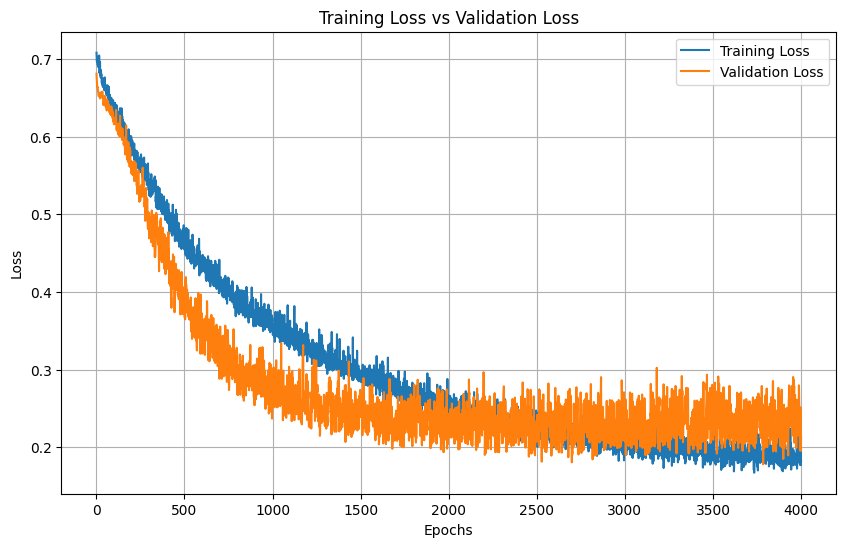

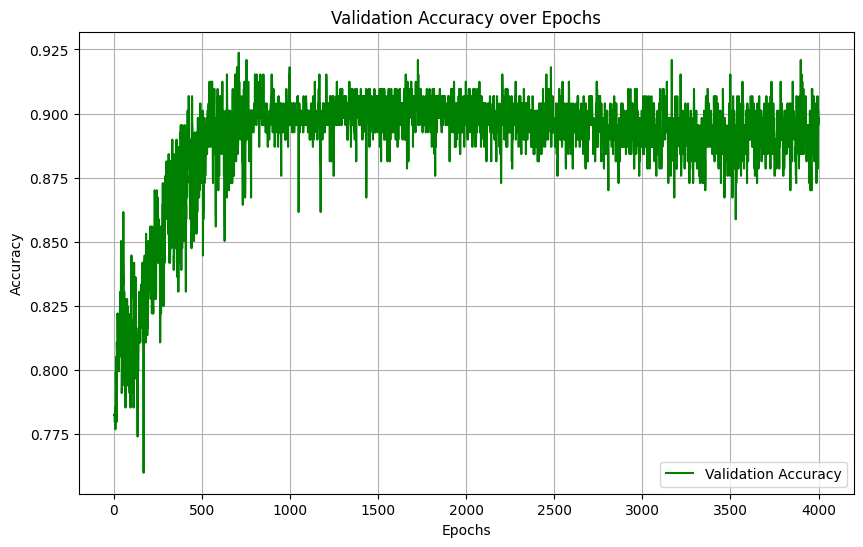

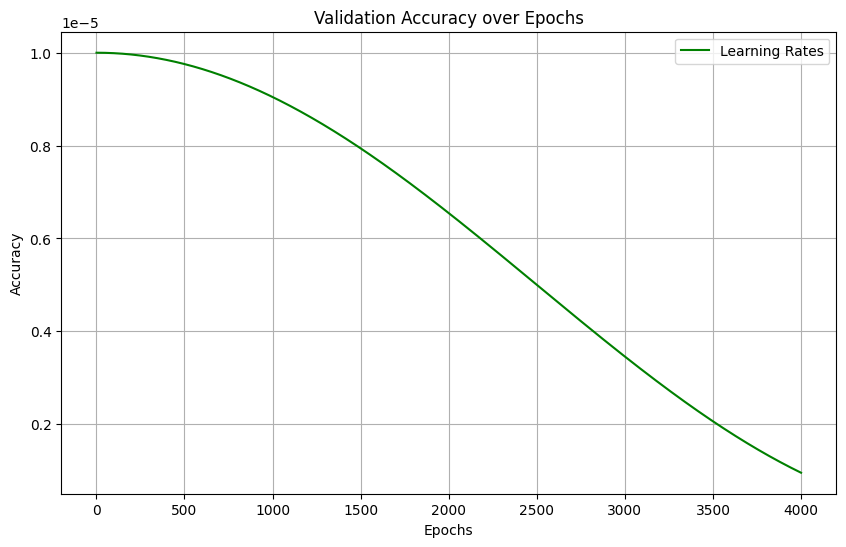

Model for bin 50 saved to GCNModels-5A_exp3/model_bin_50.pth
Training complete.


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
criterion = nn.BCEWithLogitsLoss()

# Define paths for saving models
save_dir = "GCNModels-5A_exp3"
os.makedirs(f"{save_dir}/Models", exist_ok=True)

# Training loop
epochs = 4000
batch_size = 128

# keep 10 positives and 10 negatives for validation data
val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i in range(0, len(bins)):
    model = GCN(input_dim=37).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-10)

    print(f"Training on bin {i+1}/{len(bins)}")
    train_loader = DataLoader(bins[i], batch_size=batch_size, shuffle=True)    

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, val_loader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"Accuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        scheduler.step()

    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

print("Training complete.")